# Model plots for shark and ray meat landings and trade applied to 2014-2019 data

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pyt
import seaborn as sns
import pdb
from matplotlib.gridspec import GridSpec
import xarray as xr
import xarray_einstats
import rdata as rd
import networkx as nx
from mpl_toolkits.basemap import Basemap as bm
import geopandas as gpd
import mcbackend as mb
import clickhouse_driver
from collections import Counter

from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.legend_handler import HandlerPatch
from matplotlib.legend import Legend

In [2]:
# Set figure style.
az.style.use("arviz-darkgrid")
bd = os.getcwd() + "/../Data/"
bf = os.getcwd() + "/../Figures/"

In [3]:
# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo, Ix


# Helper functions
match = lambda a, b: np.array([b.index(x) if x in b else None for x in a])


def unique(series: pd.Series):
    "Helper function to sort and isolate unique values of a Pandas Series"
    return series.sort_values().unique()


def pairplot_divergence(trace, basevar, targetvar, ax=None, divergence=True, color='C3', divergence_color='C2'):
    #theta = trace.get_values(varname=basevar, combine=True)[:, 0]
    theta = trace.posterior[basevar].values.flatten()
    logtau = trace.posterior[targetvar].values.flatten()
    if not ax:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(theta, logtau, 'o', color=color, alpha=.5)
    if divergence:
        divergent = trace.sample_stats.diverging.values.flatten()
        ax.plot(theta[divergent], logtau[divergent], 'o', color=divergence_color)
    ax.set_xlabel(basevar)
    ax.set_ylabel(targetvar)
    ax.set_title('scatter plot between log('+targetvar+') and '+basevar);
    return ax

# A small wrapper function for displaying the MCMC sampler diagnostics as above
def report_trace(trace,basevar,targetvar,logscale=False):
    # plot the trace of log(tau)
    pm.plot_trace({targetvar: trace.posterior[targetvar].values.flatten()});

    # plot the estimate for the mean of log(τ) cumulating mean
    if logscale:
        logtau = np.log(trace.posterior[targetvar].values.flatten())
    else:
        logtau = trace.posterior[targetvar].values.flatten()
    mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
    plt.figure(figsize=(15, 4))
    #plt.axhline(0.7657852, lw=2.5, color='gray')
    plt.plot(mlogtau, lw=2.5)
    plt.ylim(0, 2)
    plt.xlabel('Iteration')
    plt.ylabel('MCMC mean of log('+targetvar+')')
    plt.title('MCMC estimation of log('+targetvar+')')
    plt.show()

    # display the total number and percentage of divergent
    divergent = trace.sample_stats.diverging.values.flatten()
    print('Number of Divergent %d' % divergent.nonzero()[0].size)
    divperc = divergent.nonzero()[0].size / len(trace) * 100
    print('Percentage of Divergent %.1f' % divperc)

    # scatter plot between log(tau) and theta[0]
    # for the identifcation of the problematic neighborhoods in parameter space
    pairplot_divergence(trace,basevar,targetvar);

def ssq(x,y):
    return (y-x)**2

def drawPieMarker(xs, ys, ratios, sizes, colors, ax):
    assert sum(ratios) <= 1, 'sum of ratios needs to be < 1'

    markers = []
    previous = 0
    # calculate the points of the pie pieces
    for color, ratio in zip(colors, ratios):
        this = 2 * np.pi * ratio + previous
        x  = [0] + np.cos(np.linspace(previous, this, 10)).tolist() + [0]
        y  = [0] + np.sin(np.linspace(previous, this, 10)).tolist() + [0]
        xy = np.column_stack([x, y])
        previous = this
        markers.append({'marker':xy, 's':np.abs(xy).max()**2*np.array(sizes), 'facecolor':color, 'edgecolor':'black'})

    # scatter each of the pie pieces to create pies
    for marker in markers:
        ax.scatter(xs, ys, **marker, zorder=10)


def letter_annotation(ax, xoffset, yoffset, letter, sz=12):
 ax.text(xoffset, yoffset, letter, transform=ax.transAxes,
         size=sz, weight='bold')

## Load data

In [4]:
# Load data
exec(open("Joint_Trade_Landings_Data_AUGM_Perth.py").read())

Data loaded!


<string>:844: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
<string>:844: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
<string>:844: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
<string>:844: FutureWarning: The behavior of DataFrame concatenation with em

In [5]:
# Numerical year
sdata['Year'] = sdata.year_spp_id+2012
txdata['Year'] = txdata.year_tax_id+2012
# Long country name
sdata['Country'] = biggest_countries_long[sdata.country_spp_id]
txdata['Country'] = biggest_countries_long[txdata.country_tax_id]
# un-log landings
sdata['Reported_species_landings'] = np.exp(sdata['logReported_species_landings'])
txdata['Reported_taxon_landings'] = np.exp(txdata['logReported_taxon_landings'])

# Make agumented objects
sdata_aug = sdata
txdata_aug = txdata

In [6]:
# Grab augmented country list
biggest_countries_long_a = biggest_countries_long
biggest_countries_a = biggest_countries
country_a = country_

In [7]:
# Load data
exec(open("Joint_Trade_Landings_Data_Perth.py").read())

Data loaded!


<string>:845: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
<string>:845: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
<string>:845: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
<string>:845: FutureWarning: The behavior of DataFrame concatenation with em

# Import landings inference object

In [8]:
# Initalize backend
#ch_client = clickhouse_driver.Client(host="129.173.118.118", password='buKcek-qetsyj-pynci7', database='gsmtdb')
#ch_client = clickhouse_driver.Client(host="129.173.118.118", password='buKcek-qetsyj-pynci7', database='gsmtdb', send_receive_timeout = 7200, settings={'max_execution_time': 7200})
# Backend object
#ch_backend = mb.ClickHouseBackend(ch_client)

In [9]:
# List backend runs available
#ch_backend.get_runs()

In [10]:
# Fetch the run from the database (downloads just metadata)
#model_run = ch_backend.get_run('C341T')

In [11]:
# Import MultiTrace objects
idata_landings_x = az.from_netcdf("idata-landings-model_Perth.nc")
idata_trade_x = az.from_netcdf("idata-trade-model_Perth.nc")

# Import MultiTrace objects
idata_trade_a = az.from_netcdf("idata-trade-model_AUGM_Perth.nc")

In [12]:
# Import MultiTrace objects from server
idata_landings_a = az.from_netcdf("idata_landings_a.nc")
#idata_landings_a = model_run.to_inferencedata(var_names=['Latent_landings','CountrySPP_landings','CountrySPP_Taxonlandings'])

In [13]:
# Import species by habitat
hdata = pd.read_csv(bd+'Habitat.csv')
hdata = hdata[hdata.Superorder!='Holocephalimorpha']

In [14]:
# ArviZ doesn't handle MultiIndex yet
# Making it aware of the real data labeling at the obs level
more_coords = {
    "Exporter": ("exporter", biggest_countries_long),
    "Importer": ("importer", biggest_countries_long)
}

more_coords_a = {
    "Exporter": ("exporter", biggest_countries_long_a),
    "Importer": ("importer", biggest_countries_long_a)
}

# Update landings coords
idata_landings_x.prior = idata_landings_x.prior.assign_coords(more_coords)
idata_landings_x.prior_predictive = idata_landings_x.prior_predictive.assign_coords(more_coords)
idata_landings_x.posterior = idata_landings_x.posterior.assign_coords(more_coords)
idata_landings_x.posterior_predictive = idata_landings_x.posterior_predictive.assign_coords(
    more_coords
)
idata_landings_x.observed_data = idata_landings_x.observed_data.assign_coords(more_coords)
idata_landings_x.constant_data = idata_landings_x.constant_data.assign_coords(more_coords)

# Update trade coords
idata_trade_x.prior = idata_trade_x.prior.assign_coords(more_coords)
idata_trade_x.prior_predictive = idata_trade_x.prior_predictive.assign_coords(more_coords)
idata_trade_x.posterior = idata_trade_x.posterior.assign_coords(more_coords)
idata_trade_x.posterior_predictive = idata_trade_x.posterior_predictive.assign_coords(
    more_coords
)
idata_trade_x.observed_data = idata_trade_x.observed_data.assign_coords(more_coords)
idata_trade_x.constant_data = idata_trade_x.constant_data.assign_coords(more_coords)


# Update landings coords
#idata_landings_a.prior = idata_landings_a.prior.assign_coords(more_coords_a)
#idata_landings_a.prior_predictive = idata_landings_a.prior_predictive.assign_coords(more_coords_a)
idata_landings_a.posterior = idata_landings_a.posterior.assign_coords(more_coords_a)
#idata_landings_a.posterior_predictive = idata_landings_a.posterior_predictive.assign_coords(    more_coords_a)
#idata_landings_x.observed_data = idata_landings_a.observed_data.assign_coords(more_coords_a)
#idata_landings_x.constant_data = idata_landings_a.constant_data.assign_coords(more_coords_a)

# Update trade coords
#idata_trade_a.prior = idata_trade_a.prior.assign_coords(more_coords_a)
#idata_trade_a.prior_predictive = idata_trade_a.prior_predictive.assign_coords(more_coords_a)
idata_trade_a.posterior = idata_trade_a.posterior.assign_coords(more_coords_a)
idata_trade_a.posterior_predictive = idata_trade_a.posterior_predictive.assign_coords(
    more_coords_a
)
idata_trade_a.observed_data = idata_trade_a.observed_data.assign_coords(more_coords_a)
idata_trade_a.constant_data = idata_trade_a.constant_data.assign_coords(more_coords_a)

#"""

# Global summaries

## Grab temporal trends

In [15]:
# Annual augmented species landings
SppLandingsYear = (sdata_aug
                   .groupby('Year').sum()
                   .reset_index()[['Year','Reported_species_landings']]
                   .rename(columns={'Reported_species_landings':'Species'})
                  )
# Annual augmented taxon landings
TaxLandingsYear = (txdata_aug
                    .groupby('Year').sum()
                    .reset_index()[['Year','Reported_taxon_landings']]
                    .rename(columns={'Reported_taxon_landings':'NEI'}))
# Landings/year
LandingsYear = SppLandingsYear
LandingsYear['NEI'] = TaxLandingsYear.NEI
LandingsYear = LandingsYear.set_index(LandingsYear.Year).drop(columns=('Year'))

## Supplemental figure - NEI landings proportion

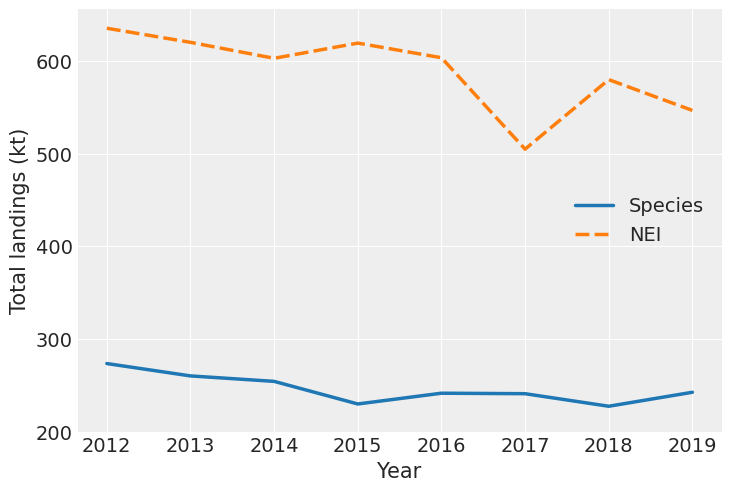

In [16]:
p = sns.lineplot(data=LandingsYear/1000, palette="tab10", linewidth=2.5)
p.set(yticks=(200,300,400,500,600),ylabel=('Total landings (kt)'))
plt.savefig(bf+'/Global/'+'Species_NEI_Landings.jpg',dpi=300);

In [17]:
# Average NEI landings proportion
np.mean(LandingsYear.NEI/(LandingsYear.NEI+LandingsYear.Species))

0.7048447338758752

## Plot reported and augmented latent landings

In [18]:
# Plot reported and augmented estimated latent landings
c_landings_x = idata_landings_x.posterior['Latent_landings'].sum('species').to_dataframe().reset_index()
c_landings_x['Dataset'] = 'Reported'
c_landings_a = idata_landings_a.posterior['Latent_landings'].sum('species').to_dataframe().reset_index()
c_landings_a['Dataset'] = 'Augmented'
c_landings = c_landings_x.merge(c_landings_a,how='outer')
masxk = c_landings.Exporter=="Other Asia, nes"
c_landings.loc[masxk,'Exporter'] = 'Taiwan'
plot_order = c_landings.groupby('Exporter')['Latent_landings'].sum().sort_values(ascending=False).index.values

In [19]:
c_landings[c_landings.exporter=='CHN']

chain  draw exporter Exporter  Latent_landings    Dataset
10          0     0      CHN    China           1681.5   Reported
77          0     1      CHN    China           1681.5   Reported
144         0     2      CHN    China           1681.5   Reported
211         0     3      CHN    China           1681.5   Reported
278         0     4      CHN    China           1681.5   Reported
...       ...   ...      ...      ...              ...        ...
149070      3   495      CHN    China          31269.5  Augmented
149138      3   496      CHN    China          31269.5  Augmented
149206      3   497      CHN    China          31269.5  Augmented
149274      3   498      CHN    China          31269.5  Augmented
149342      3   499      CHN    China          31269.5  Augmented

[2200 rows x 6 columns]

/Users/aaronmacneil/miniforge3/envs/gsm-project/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


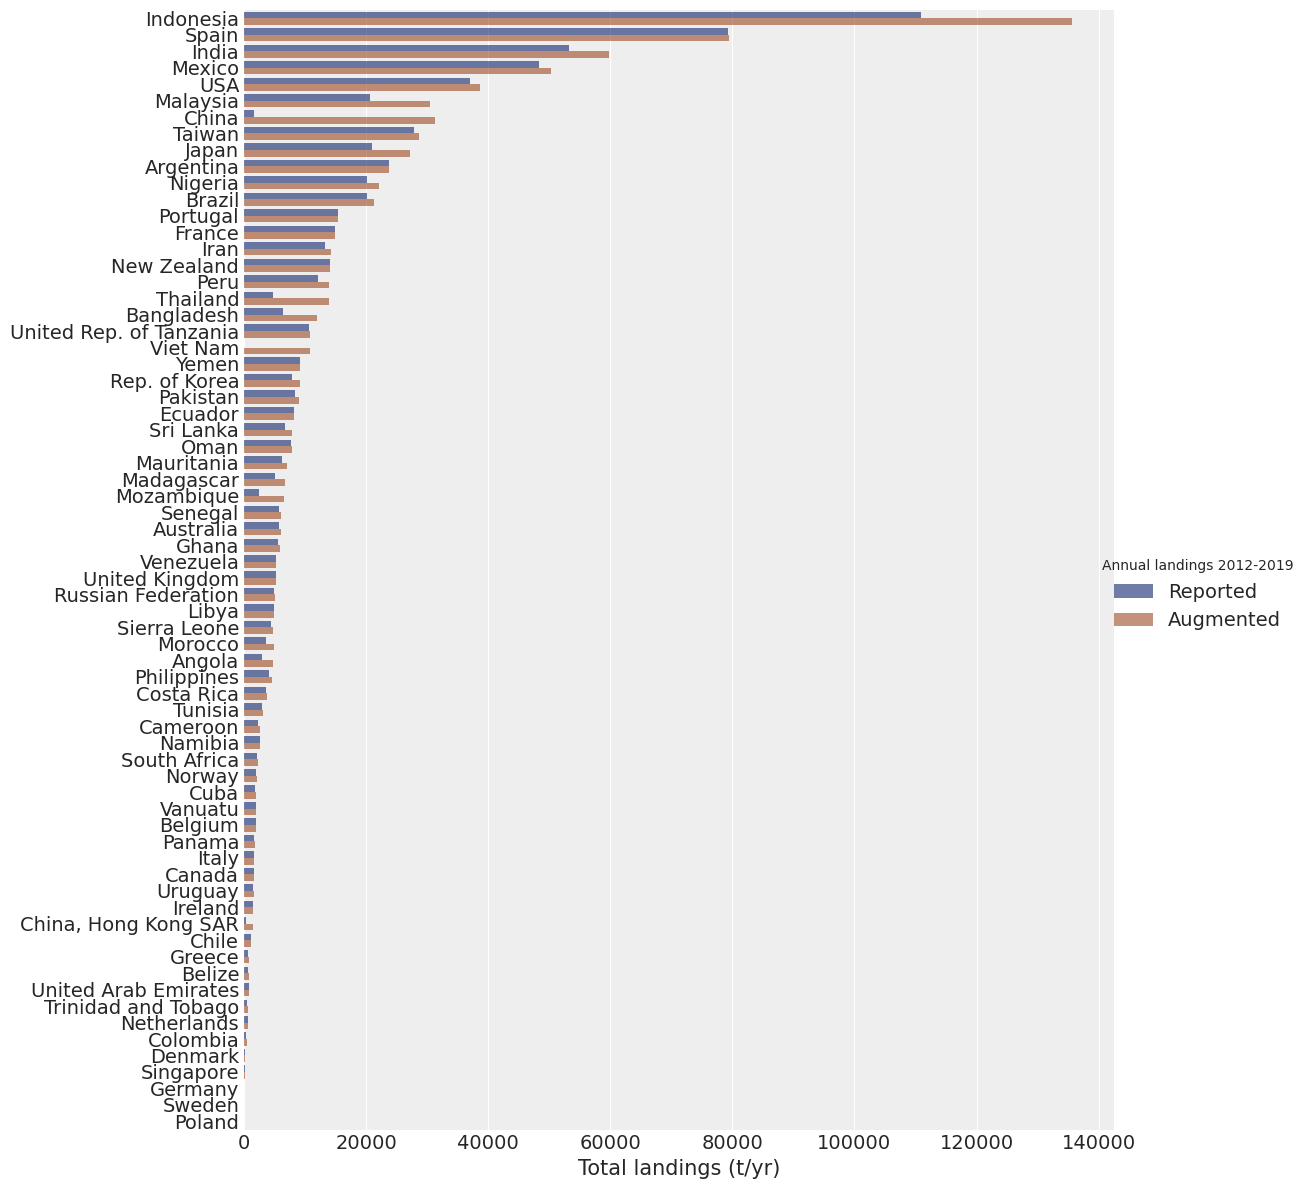

In [20]:
# Draw a nested barplot
g = sns.catplot(
    data=c_landings, kind="bar",
    y="Exporter", x="Latent_landings", hue="Dataset", order=plot_order,
    errorbar="ci", palette="dark", alpha=.6, height=12,
    
)
g.despine(left=True)
g.set_axis_labels("Total landings (t/yr)","")
#g.legend.set_title("")
g.legend.set_title("Annual landings 2012-2019")
plt.savefig(bf+'/Global/'+'Latent_landings_reported_augmented_all.jpg',dpi=300);

/Users/aaronmacneil/miniforge3/envs/gsm-project/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


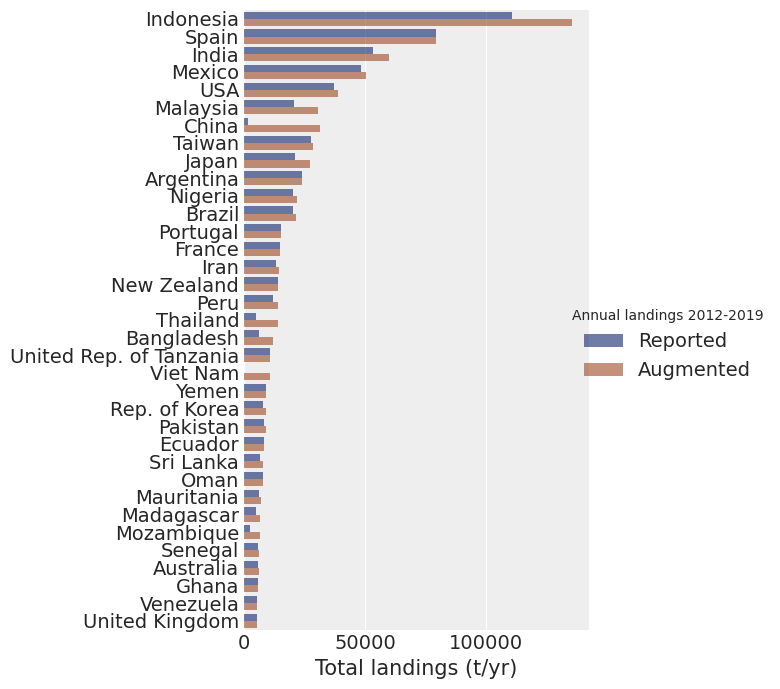

In [21]:
# Grab top N exporters
N = 35
exps = (c_landings.drop(columns=['exporter','Dataset'])
        .groupby('Exporter').sum().reset_index()
        .sort_values('Latent_landings',ascending=False)
        .Exporter[:N].values
       )
# Draw a nested barplot
g = sns.catplot(
    data=c_landings[c_landings.Exporter.isin(exps)], kind="bar",
    y="Exporter", x="Latent_landings", hue="Dataset", order=plot_order[match(exps,list(plot_order))],
    errorbar=('ci', 95), palette="dark", alpha=.6, height=7,
    
)
g.despine(left=True)
g.set_axis_labels("Total landings (t/yr)","")
#g.legend.set_title("")
g.legend.set_title("Annual landings 2012-2019")
plt.savefig(bf+'/Global/'+'Latent_landings_reported_augmented_top_'+str(N)+'.jpg',dpi=300);

## Plot average percent re-exports among top 10 re-exporters

In [22]:
ReExportz = ReExports_AUGM.groupby(['Exporter','year']).sum().sort_values(by='Net_diff',ascending=False).drop(columns='exporter').reset_index()
ReExportz['Prop_ReEx'] = 1-ReExportz.Reduced/ReExportz.Original
ReExportz['Perc_ReEx'] = np.round(ReExportz['Prop_ReEx']*100,2)
ReExportz = ReExportz[ReExportz.Prop_ReEx!=1]
ReExportz = ReExportz[ReExportz.Net_diff>100]
plot_order = ReExportz.groupby('Exporter')['Net_diff'].mean().sort_values(ascending=False).index.values
ReExportz['hue'] = 'Landings'

/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_46734/556126643.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


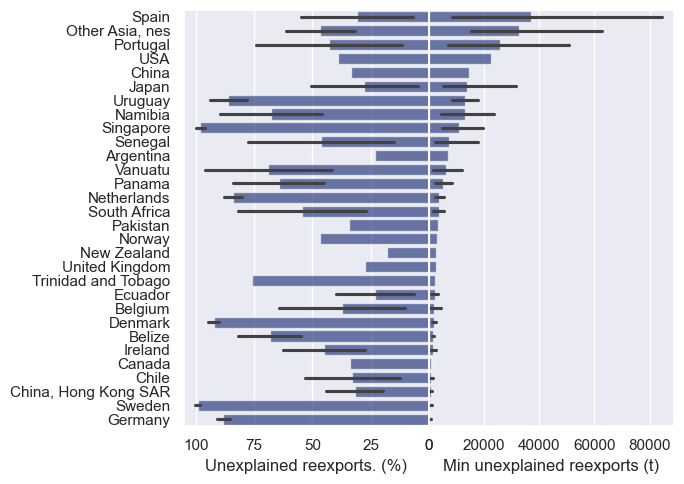

In [23]:
sns.set_theme()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(7, 5), sharey=True, gridspec_kw={'wspace': 0})

# draw total re-exports to the right
sns.barplot(
    data=ReExportz, hue='hue',
    y="Exporter", x="Net_diff", order=plot_order,
    errorbar="ci", palette="dark", alpha=.6, dodge=True, ax=ax2)

ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='y', labelright=False, right=False)
ax2.legend_.remove()  # remove the legend; the legend will be in ax1
ax2.set_xlabel('Min unexplained reexports (t)')

# draw percent re-exports to the left
sns.barplot(
    data=ReExportz, hue='hue',
    y="Exporter", x="Perc_ReEx", order=plot_order,
    errorbar="sd", palette="dark", alpha=.6, dodge=True, 
    ax=ax1
    )

ax1.invert_xaxis()  # reverse the direction
#ax1.tick_params(labelleft=False, left=False)
ax1.set_ylabel('')
ax1.legend_.remove() 
ax1.set_xlabel('Unexplained reexports. (%)')
plt.tight_layout()
plt.savefig(bf+'/Global/'+'Avg_min_ReExports.jpg',dpi=300);

## Estimated numbers of sharks and rays annually

In [24]:
tidata = pd.read_csv(bd+'tax_iucn_size.csv')
tidata

Class Superorder            Order         Family      Genus  \
0     Elasmobranchii   Batoidea  Myliobatiformes    Aetobatidae  Aetobatus   
1     Elasmobranchii   Batoidea  Myliobatiformes    Aetobatidae  Aetobatus   
2     Elasmobranchii   Batoidea  Myliobatiformes    Aetobatidae  Aetobatus   
3     Elasmobranchii   Batoidea  Myliobatiformes    Aetobatidae  Aetobatus   
4     Elasmobranchii   Batoidea  Myliobatiformes    Aetobatidae  Aetobatus   
...              ...        ...              ...            ...        ...   
1212  Elasmobranchii   Batoidea  Myliobatiformes  Urotrygonidae  Urotrygon   
1213  Elasmobranchii   Batoidea  Myliobatiformes  Urotrygonidae  Urotrygon   
1214  Elasmobranchii   Batoidea  Myliobatiformes  Urotrygonidae  Urotrygon   
1215  Elasmobranchii   Batoidea  Myliobatiformes    Zanobatidae  Zanobatus   
1216  Elasmobranchii   Batoidea  Myliobatiformes    Zanobatidae  Zanobatus   

            species_binomial    EDGE.Scientific.name OldRLCategory  OldRLYear  \
0        Aetobatus flagellum     Aetobatus flagellum            EN     2006.0   
1         Aetobatus laticeps                     NaN            NE        NaN   
2         Aetobatus narinari      Aetobatus narinari            NT     2006.0   
3       Aetobatus narutobiei     Aetobatus flagellum            NE        NaN   
4        Aetobatus ocellatus      Aetobatus narinari            NE        NaN   
...                      ...                     ...           ...        ...   
1212       Urotrygon rogersi       Urotrygon rogersi            DD     2008.0   
1213    Urotrygon simulatrix    Urotrygon simulatrix            VU     2008.0   
1214    Urotrygon venezuelae    Urotrygon venezuelae            NT     2007.0   
1215     Zanobatus maculatus  Zanobatus schoenleinii            NE        NaN   
1216  Zanobatus schoenleinii  Zanobatus schoenleinii            DD     2008.0   

     GSTPRLCategory  GSTRLYear  MaxLinearDimension MeasurementType  \
0                EN     2021.0                90.0              DW   
1                VU     2021.0               230.0              DW   
2                EN     2021.0               226.0              DW   
3                VU     2021.0               150.0              DW   
4                VU     2016.0               330.0              DW   
...             ...        ...                 ...             ...   
1212             NT     2020.0                46.0              DW   
1213             VU     2020.0                27.0              DW   
1214             EN     2020.0                36.0              DW   
1215             NT     2021.0                35.8              TL   
1216             VU     2021.0               100.0              TL   

     BodySizeClass  length.weight.a  length.weight.b       mass_50  \
0           medium           0.0123             3.11   1703.711400   
1            large           0.0123             3.11  31526.473570   
2            large           0.0123             3.11  29852.387520   
3           medium           0.0123             3.11   8343.449479   
4            large           0.0123             3.11  96890.272630   
...            ...              ...              ...           ...   
1212         small           0.0269             3.02    348.473971   
1213         small           0.0269             3.02     69.720463   
1214         small           0.0269             3.02    166.216926   
1215         small           0.0100             3.04     64.368474   
1216        medium           0.0100             3.04   1461.735563   

            mass_75       mass_max  
0       6012.288955   14709.547590  
1     111254.916100  272194.083800  
2     105347.173100  257740.316300  
3      29443.501500   72035.890140  
4     341919.597500  836533.744600  
...             ...            ...  
1212    1185.675776    2826.707894  
1213     237.222492     565.549793  
1214     565.549793    1348.297820  
1215     220.795716     529.424946  
1216    5014.022

In [25]:
txdata.loc[txdata.country=='CHN']

logReported_taxon_landings  taxon_tax_id  country_tax_id  year_tax_id  \
765                     4.26268            19              10            0   
766                     4.60517            19              10            1   

    country    year       taxon  
765     CHN  year_1  Rajiformes  
766     CHN  year_2  Rajiformes

In [26]:
# Total indonesia landings
idata_trade_a.posterior['amount_exported'].sel(exporter='IDN').mean(('chain','draw')).sum().values

array(135690.625)

In [27]:
# Indo blue, silky, bottlenose
idata_trade_a.posterior['amount_exported'].sel(exporter='IDN',species=['Prionace glauca','Carcharhinus falciformis','Rhynchobatus australiae']).mean(('chain','draw')).sum(('importer')).values

array([14807.90726215,  5843.3101414 ,  3101.64071064])

In [28]:
# 


In [29]:
# Traded+retained
trade_spp = (
    idata_trade_a.copy().posterior['amount_exported']
    .rename('')
    .assign_coords({"Group": ("species", group_),"Exporter": ("exporter", biggest_countries_long_a),"Importer": ("importer", biggest_countries_long_a)})
)

# Retain copy 
trade_spp_tot = trade_spp.copy()

# Domestic consumption
domestic_spp = trade_spp*0

# Store domestic and remove from trade
for c in country_a:
    # Add domestic consumption to domestic xarray
    domestic_spp.loc[dict(exporter=c,importer=c)] = trade_spp.sel(exporter=c,importer=c)
    # Remove domestic consumption from trade xarray
    trade_spp.loc[dict(exporter=c,importer=c)] = 0

# Split by group
total_shark_trade = trade_spp[:,:,:,group_=='sharks',:].sum(('species'))
total_ray_trade = trade_spp[:,:,:,group_=='rays',:].sum(('species'))

# Split by group for both trade and retained
total_shark = trade_spp_tot[:,:,:,group_=='sharks',:].sum(('species'))
total_ray = trade_spp_tot[:,:,:,group_=='rays',:].sum(('species'))

# Total trade
total_trade = total_shark_trade+total_ray_trade

In [30]:
# Vector of mass - convert g to tonnes
meanmass = tidata.mass_75.values[match(idata_landings_a.posterior['Latent_landings'].species.values,list(tidata.species_binomial))]/1000000

In [31]:
# Estimated number of sharks landed annually
EstNsharks = (idata_landings_a.posterior['Latent_landings'].sum('exporter')/meanmass[None,None,]).sel(species=species_[group_=='sharks']).sum('species')
# Estimated number of rays landed annually
EstNrays = (idata_landings_a.posterior['Latent_landings'].sum('exporter')/meanmass[None,None,]).sel(species=species_[group_=='rays']).sum('species')

In [32]:
# Estimated number of sharks traded annually
EstNsharks_trade = (trade_spp.sum(('exporter','importer'))/meanmass[None,None,]).sel(species=species_[group_=='sharks']).sum('species')
# Estimated number of rays traded annually
EstNrays_trade = (trade_spp.sum(('exporter','importer'))/meanmass[None,None,]).sel(species=species_[group_=='rays']).sum('species')

In [33]:
# Estimated number of sharks+rays landed annually
EstNtotal = EstNsharks+EstNrays
# Estimated number of sharks+rays traded annually
EstNtotal_trade = EstNsharks_trade+EstNrays_trade

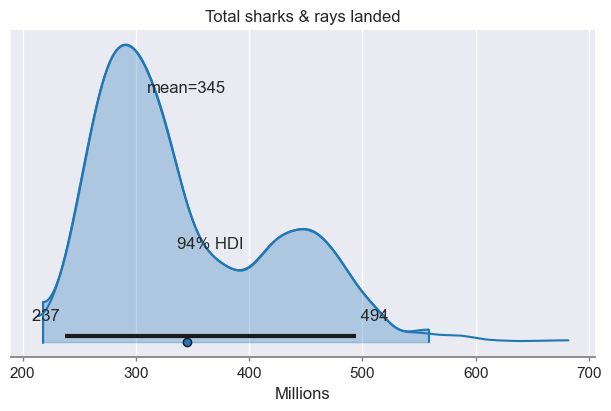

In [34]:
fig, ax = plt.subplots(1, 1,figsize=(6,4))
xout = EstNtotal/1000000
az.plot_posterior(xout, color='#1f77b4', ax=ax)
az.plot_density(xout, colors='#1f77b4', ax=ax, shade=0.3, hdi_prob=0.99)
plt.title('Total sharks & rays landed')
plt.xlabel('Millions')
plt.savefig(bf+'/Global/'+'Estimated_individuals_landed_total.jpg',dpi=300);

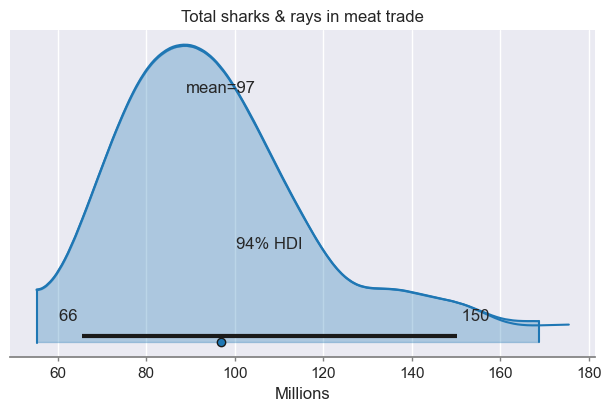

In [35]:
fig, ax = plt.subplots(1, 1,figsize=(6,4))
xout = EstNtotal_trade/1000000
az.plot_posterior(xout, color='#1f77b4', ax=ax)
az.plot_density(xout, colors='#1f77b4', ax=ax, shade=0.3, hdi_prob=0.99)
plt.title('Total sharks & rays in meat trade')
plt.xlabel('Millions')
plt.savefig(bf+'/Global/'+'Estimated_individuals_total.jpg',dpi=300);

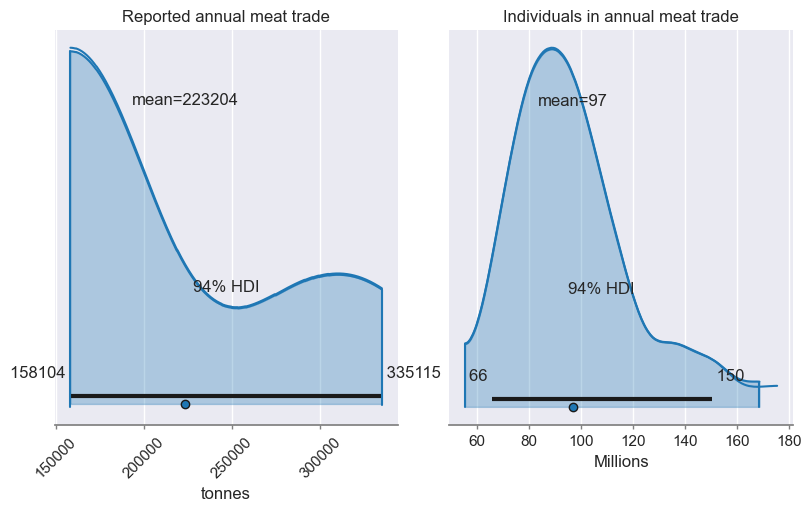

In [36]:
fig, ax = plt.subplots(1, 2,figsize=(8,5))
xout = tdata.groupby(('year_t')).sum().estimated_live_weight.values
az.plot_posterior(xout, color='#1f77b4', ax=ax[0])
az.plot_density(xout, colors='#1f77b4', ax=ax[0], shade=0.3, hdi_prob=0.99)
ax[0].set_title('Reported annual meat trade')
ax[0].set_xlabel('tonnes')
ax[0].tick_params(axis='x', labelrotation=45)

xout = EstNtotal_trade/1000000
az.plot_posterior(xout, color='#1f77b4', ax=ax[1])
az.plot_density(xout, colors='#1f77b4', ax=ax[1], shade=0.3, hdi_prob=0.99)
ax[1].set_title('Individuals in annual meat trade')


plt.xlabel('Millions')
plt.savefig(bf+'/Global/'+'Estimated_reported_total.jpg',dpi=300);

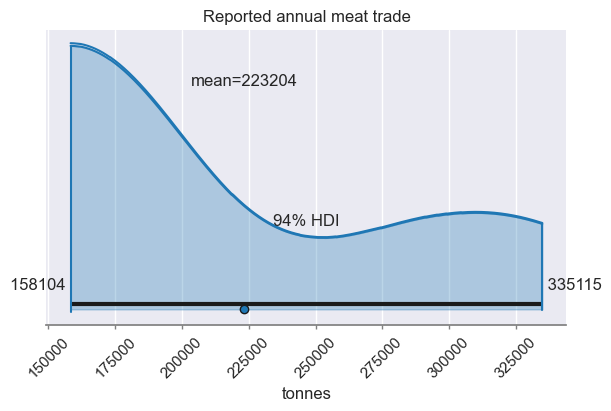

In [37]:
fig, ax = plt.subplots(1, 1,figsize=(6,4))
xout = tdata.groupby(('year_t')).sum().estimated_live_weight.values
az.plot_posterior(xout, color='#1f77b4', ax=ax)
az.plot_density(xout, colors='#1f77b4', ax=ax, shade=0.3, hdi_prob=0.99)
ax.set_title('Reported annual meat trade')
ax.set_xlabel('tonnes')
ax.tick_params(axis='x', labelrotation=45)

plt.savefig(bf+'/Global/'+'Reported_annual_total.jpg',dpi=300);

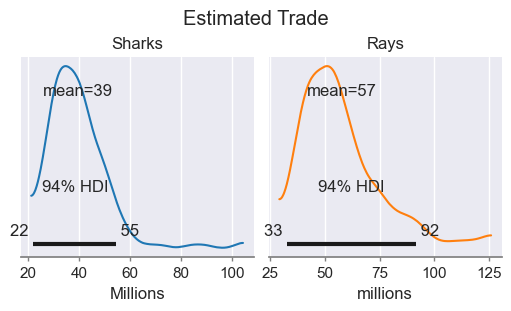

In [38]:
fig, ax = plt.subplots(1, 2,figsize=(5,3))
fig.suptitle("Estimated Trade")


az.plot_posterior(EstNsharks_trade/1000000, color='#1f77b4', ax=ax[0])
ax[0].set_title("Sharks")
ax[0].set_xlabel('Millions')


az.plot_posterior(EstNrays_trade/1000000, color='#ff7f0e', ax=ax[1])
ax[1].set_title("Rays")
ax[1].set_xlabel('millions')

plt.savefig(bf+'/Global/'+'Estimated_individuals.jpg',dpi=300);

## Plot top importers and exporters


In [39]:
country_

array(['AGO', 'ARE', 'ARG', 'AUS', 'BEL', 'BGD', 'BLZ', 'BRA', 'CAN',
       'CHL', 'CHN', 'CMR', 'COL', 'CRI', 'CUB', 'DEU', 'DNK', 'ECU',
       'ESP', 'FRA', 'GBR', 'GHA', 'GRC', 'HKG', 'IDN', 'IND', 'IRL',
       'IRN', 'ITA', 'JPN', 'KOR', 'LBY', 'LKA', 'MAR', 'MDG', 'MEX',
       'MOZ', 'MRT', 'MYS', 'NAM', 'NGA', 'NLD', 'NOR', 'NZL', 'OMN',
       'PAK', 'PAN', 'PER', 'PHL', 'POL', 'PRT', 'RUS', 'SEN', 'SGP',
       'SLE', 'SWE', 'THA', 'TTO', 'TUN', 'TWN', 'TZA', 'URY', 'USA',
       'VEN', 'VUT', 'YEM', 'ZAF'], dtype='<U3')

In [40]:
total_trade.sel(importer='LKA').mean(('chain','draw')).sum()

<xarray.DataArray '' ()>
array(2804.98679139)
Coordinates:
    importer  <U3 'LKA'
    Importer  object 'Sri Lanka'

In [41]:
# Grab top N 
N = 15
plot_order_ex = total_trade.sortby(total_trade.sum('importer').mean(('chain','draw')), ascending=False).exporter[:N]
plot_order_im = total_trade.sortby(total_trade.sum('exporter').mean(('chain','draw')), ascending=False).importer[:N]
plot_order_co = trade_spp_tot.sortby(trade_spp_tot.mean(('chain','draw','exporter','species')), ascending=False).importer[:N]

In [42]:
# Total exports
tt_tmp_ex = total_trade.sum('importer').mean(('chain','draw')).astype(int).sortby(lambda x: x, ascending=False)
# Total percentage of exports represented by top N nations
top_ex_perc = tt_tmp_ex.to_dataframe().reset_index()[:N][''].sum()/tt_tmp_ex.to_dataframe().reset_index()[''].sum()
top_ex_perc

0.8241828097293319

In [43]:
# Total imports
tt_tmp_im = total_trade.sum('exporter').mean(('chain','draw')).astype(int).sortby(lambda x: x, ascending=False)
# Total percentage of imports represented by top N nations
top_im_perc = tt_tmp_im.to_dataframe().reset_index()[:N][''].sum()/tt_tmp_im.to_dataframe().reset_index()[''].sum()
top_im_perc

0.7946485329050821

In [44]:
# Total domestic
tt_tmp_d = domestic_spp.sum(('exporter','importer')).mean(('chain','draw')).astype(int).sortby(lambda x: x, ascending=False)
# Total percentage of domestic consumptoin + imports represented by top N nations
top_d_perc = (tt_tmp_d.to_dataframe().reset_index()[:N][''].sum()+tt_tmp_im.to_dataframe().reset_index()[:N][''].sum())/(tt_tmp_d.to_dataframe().reset_index()[''].sum()+tt_tmp_im.to_dataframe().reset_index()[''].sum())
top_d_perc

0.5548848676916365

In [45]:
tdata.groupby(['year_t','ISOex_i']).sum().groupby(['ISOex_i']).mean('estimated_live_weight').sort_values(by='estimated_live_weight',ascending=False)[:N]

Unnamed: 0  exporter_i  importer_j     hscode_k       value_v  \
ISOex_i                                                                   
ESP      2128763.500   136836.00   76571.625  5742591.250  93084.379875   
USA      1402478.000   109144.25   51579.000  3936993.250  54827.300500   
TWN       403848.375    19845.00   18382.250  1230777.125  31484.948000   
IDN       460071.125    16695.00   20839.250  1408786.125  18517.111000   
ARG       169457.750      812.00   10959.000   771010.125  26562.034625   
JPN       533114.125    20874.00   27159.000  1617726.375  22979.309500   
PRT      1408203.250    75562.50   50726.250  3702706.875  42774.562375   
NZL       725080.625    39057.00   26897.000  2142164.375  13257.542250   
ECU        92800.625     2207.25    6220.375   307239.625   4560.467875   
FRA      1388368.000    34198.75   60363.500  4134516.750  14208.660750   
KOR       347899.125    16553.75   20598.125  1226365.000   2127.320375   
SEN       284408.875    19379.50   13870.125   857766.000   5900.076625   
BRA       357890.875     2194.50   13448.125   877183.250   6511.207875   
GBR       639948.375    45739.75   22845.000  1680879.000   5587.799250   
PAK        89714.250     4907.75    4113.000   254367.000   5396.604875   

           quantity_q  fins    rays  estimated_live_weight  
ISOex_i                                                     
ESP      28422.942918   0.0  47.125           43117.556281  
USA      14907.770874   0.0  59.250           23550.366896  
TWN      17743.447532   0.0   2.750           23246.217829  
IDN       9909.229674   0.0  18.125           18598.875548  
ARG      11719.145683   0.0  16.500           17990.491872  
JPN      12650.024684   0.0  17.625           17397.244781  
PRT      18858.155800   0.0  47.500           15002.071164  
NZL       3504.075270   0.0  31.500            6274.021534  
ECU       3217.707425   0.0   1.375            5855.812738  
FRA       2838.009121   0.0  73.500            5447.751992  
KOR       1657.460861   0.0  24.750            3158.781822  
SEN       2833.988785   0.0   6.125            2965.410068  
BRA       1797.554669   0.0   3.625            2898.390487  
GBR       1712.569623   0.0  28.250            2832.687023  
PAK       1977.219625   0.0   7.125            2638.069250

In [46]:
# Data to locate exporter plot
tmpdata = total_trade.sum('importer').sel(exporter=plot_order_ex)
# Create dataframe for piecharts
piedata = tmpdata.median(('chain','draw')).to_dataframe().reset_index().rename(columns={"": "total_landings"})
piedata['median'] = tmpdata.quantile(.5,('chain','draw')).values
piedata['l90'] = tmpdata.quantile(.05,('chain','draw')).values
piedata['l50'] = tmpdata.quantile(.25,('chain','draw')).values
piedata['u50'] = tmpdata.quantile(.75,('chain','draw')).values
piedata['u90'] = tmpdata.quantile(.95,('chain','draw')).values
# Add sharks and rays
piedata['sharks'] = total_shark_trade.sum('importer').sel(exporter=plot_order_ex).mean(('chain','draw')).to_dataframe().reset_index()[""]
piedata['rays'] = total_ray_trade.sum('importer').sel(exporter=plot_order_ex).mean(('chain','draw')).to_dataframe().reset_index()[""]
# Convert to proportions
piedata['shark_prop'] = piedata['sharks']/(piedata['sharks']+piedata['rays'])
piedata['ray_prop'] = piedata['rays']/(piedata['sharks']+piedata['rays'])
# Add location for y plotting
piedata = piedata.sort_values(by='median',ascending=False).reset_index()
piedata['yloc'] = piedata.index.values[::-1]

# Data to locate importer plot
tmpdata = total_trade.sum('exporter').sel(importer=plot_order_im)
# Create dataframe for piecharts
piedata_im = tmpdata.median(('chain','draw')).to_dataframe().reset_index().rename(columns={"": "total_landings"})
piedata_im['median'] = tmpdata.quantile(.5,('chain','draw')).values
piedata_im['l90'] = tmpdata.quantile(.05,('chain','draw')).values
piedata_im['l50'] = tmpdata.quantile(.25,('chain','draw')).values
piedata_im['u50'] = tmpdata.quantile(.75,('chain','draw')).values
piedata_im['u90'] = tmpdata.quantile(.95,('chain','draw')).values
# Add sharks and rays
piedata_im['sharks'] = total_shark_trade.sum('exporter').sel(importer=plot_order_im).mean(('chain','draw')).to_dataframe().reset_index()[""]
piedata_im['rays'] = total_ray_trade.sum('exporter').sel(importer=plot_order_im).mean(('chain','draw')).to_dataframe().reset_index()[""]
# Convert to proportions
piedata_im['shark_prop'] = piedata_im['sharks']/(piedata_im['sharks']+piedata_im['rays'])
piedata_im['ray_prop'] = piedata_im['rays']/(piedata_im['sharks']+piedata_im['rays'])
# Add location for y plotting
piedata_im = piedata_im.sort_values(by='median',ascending=False).reset_index()
piedata_im['yloc'] = piedata_im.index.values[::-1]


# Data to locate utilizer plot
tmpdata = trade_spp_tot.sum(('exporter','species')).sel(importer=plot_order_co)
# Create dataframe for piecharts
piedata_ut = tmpdata.median(('chain','draw')).to_dataframe().reset_index().rename(columns={"": "total_landings"})
piedata_ut['median'] = tmpdata.quantile(.5,('chain','draw')).values
piedata_ut['l90'] = tmpdata.quantile(.05,('chain','draw')).values
piedata_ut['l50'] = tmpdata.quantile(.25,('chain','draw')).values
piedata_ut['u50'] = tmpdata.quantile(.75,('chain','draw')).values
piedata_ut['u90'] = tmpdata.quantile(.95,('chain','draw')).values
# Add sharks and rays
piedata_ut['sharks'] = total_shark.sum('exporter').sel(importer=plot_order_co).mean(('chain','draw')).to_dataframe().reset_index()[""]
piedata_ut['rays'] = total_ray.sum('exporter').sel(importer=plot_order_co).mean(('chain','draw')).to_dataframe().reset_index()[""]
# Convert to proportions
piedata_ut['shark_prop'] = piedata_ut['sharks']/(piedata_ut['sharks']+piedata_ut['rays'])
piedata_ut['ray_prop'] = piedata_ut['rays']/(piedata_ut['sharks']+piedata_ut['rays'])
# Add location for y plotting
piedata_ut = piedata_ut.sort_values(by='median',ascending=False).reset_index()
piedata_ut['yloc'] = piedata_ut.index.values[::-1]


In [47]:
# Correct names
piedata.loc[piedata.Exporter=='Rep. of Korea','Exporter'] = 'South Korea'
piedata.loc[piedata.Exporter=='Other Asia, nes','Exporter'] = 'Taiwan'
piedata_im.loc[piedata_im.Importer=='Rep. of Korea','Importer'] = 'South Korea'
piedata_im.loc[piedata_im.Importer=='Other Asia, nes','Importer'] = 'Taiwan'
piedata_ut.loc[piedata_ut.Importer=='Rep. of Korea','Importer'] = 'South Korea'
piedata_ut.loc[piedata_ut.Importer=='Other Asia, nes','Importer'] = 'Taiwan'

# Figure 1

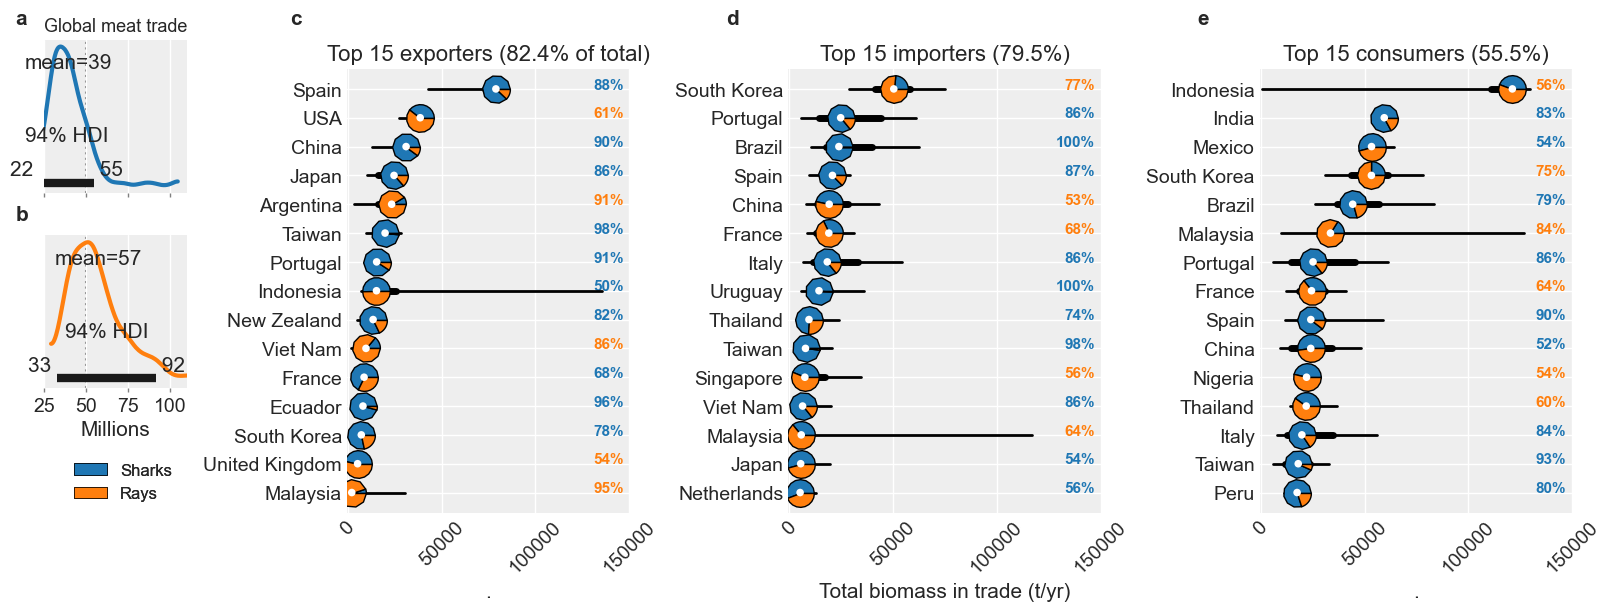

In [48]:
az.style.use("arviz-darkgrid")

fig = plt.figure(figsize=(16, 6))
(lftfig, rtfig1, rtfig2, rtfig3) = fig.subfigures(1,4, width_ratios=(.8,2,2,2))

fsz = 15

# - - - - - - - - - - - - - - - Initialize left plot
(lft_top_axs,lft_bot_axs,lft_dub) = lftfig.subplots(3, 1)

# Plot individuals retained
#az.plot_density(EstNsharks_trade/1000000, colors='#1f77b4', ax=lft_top_axs, shade=0.6, hdi_prob=0.94)
az.plot_posterior(EstNsharks_trade/1000000, color='#1f77b4', ax=lft_top_axs, linewidth=3)
lft_top_axs.set_yticklabels("")
lft_top_axs.set_xticklabels("")
lft_top_axs.set_xlabel('')
lft_top_axs.set_xticks((25,50,75,100))
lft_top_axs.set_title('Global meat trade', fontsize=13)
lft_top_axs.set_xlim(25,110)
lft_top_axs.axvline(x=50,color='grey', linestyle=':', zorder=0)
# Add journal letter
letter_annotation(lft_top_axs, -.2, 1.1, 'a', sz=fsz)

# Plot individuals retained
#az.plot_density(EstNrays_trade/1000000, colors='#ff7f0e', ax=lft_bot_axs, shade=0.6, hdi_prob=0.94)
az.plot_posterior(EstNrays_trade/1000000, color='#ff7f0e', ax=lft_bot_axs, linewidth=3)
lft_bot_axs.set_yticklabels("")
lft_bot_axs.set_xlabel('Millions')
lft_bot_axs.set_title('')
lft_bot_axs.set_xticks((25,50,75,100))
lft_bot_axs.set_xlim(25,110)
lft_bot_axs.axvline(x=50,color='grey', linestyle=':', zorder=0)
# Add journal letter
letter_annotation(lft_bot_axs, -.2, 1.1, 'b', sz=fsz)

# Turn off dummy plot
lft_dub.axis("off")
legend_elements1 = [patches.Patch(facecolor=c, label=i, edgecolor='black', linewidth=0.5) for i,c in zip(['Sharks','Rays'],['#1f77b4','#ff7f0e'])]
legend1 = lft_dub.legend(handles=legend_elements1, fontsize=12, loc='upper right')
lft_dub.add_artist(legend1)

# - - - - - - - - - - - - - - - Initialize next plot
# Max x value
topx = 150000
# Font size for percentages
fsx = 11

rtfig1_axs = rtfig1.subplots(1, 1)

# Exporters
rtfig1_axs.scatter(x=piedata['total_landings'], y=piedata['yloc'], s=30, facecolor='white', edgecolors='none', zorder=11)
rtfig1_axs.plot((piedata['l90'],piedata['u90']), (piedata['yloc'],piedata['yloc']), c='black', linewidth=2, zorder=9)
rtfig1_axs.plot((piedata['l50'],piedata['u50']), (piedata['yloc'],piedata['yloc']), c='black', linewidth=5, zorder=9)
rindx = piedata['ray_prop'].values>0.5
sindx = piedata['ray_prop'].values<0.5
[rtfig1_axs.text(147050,y,str(np.round(z*100,0).astype(int))+'%',horizontalalignment='right',fontsize=fsx,color='#ff7f0e', weight='bold') for y,z in zip(piedata['yloc'][rindx], piedata['ray_prop'].values[rindx])]
[rtfig1_axs.text(147050,y,str(np.round(z*100,0).astype(int))+'%',horizontalalignment='right',fontsize=fsx,color='#1f77b4', weight='bold') for y,z in zip(piedata['yloc'][sindx], piedata['shark_prop'].values[sindx])]

for xx,yy,xxr,yyr in zip(piedata['total_landings'],piedata['yloc'],piedata['shark_prop'].values,piedata['ray_prop'].values):
    drawPieMarker(xs=xx,
                  ys=yy,
                  ratios=[xxr,yyr],
                  sizes=[400],
                  colors=['#1f77b4','#ff7f0e'],
                  ax=rtfig1_axs)

tmp_lab = piedata.Exporter.to_numpy()[::-1]
tmp_lab[tmp_lab=="Other Asia, nes"] = 'Taiwan'
rtfig1_axs.set_yticks(np.arange(len(tmp_lab)))
rtfig1_axs.set_yticklabels(tmp_lab)
[tk.set_visible(True) for tk in rtfig1_axs.get_yticklabels()]
rtfig1_axs.set_xlabel('.')
rtfig1_axs.set_xlim(-500,topx)
rtfig1_axs.set_title('Top '+str(N)+' exporters ('+str(np.round(top_ex_perc*100,1))+'% of total)')
#rtfig1_axs.legend_.remove() 
for tick in rtfig1_axs.get_xticklabels():
    tick.set_rotation(45)
    # Add journal letter
letter_annotation(rtfig1_axs, -.2, 1.1, 'c', sz=fsz)

# - - - - - - - - - - - - - - - Initialize next plot
rtfig2_axs = rtfig2.subplots(1, 1)

# Importers
rtfig2_axs.scatter(x=piedata_im['total_landings'], y=piedata_im['yloc'], s=30, facecolor='white', edgecolors='none', zorder=11)
rtfig2_axs.plot((piedata_im['l90'],piedata_im['u90']), (piedata_im['yloc'],piedata_im['yloc']), c='black', linewidth=2, zorder=9)
rtfig2_axs.plot((piedata_im['l50'],piedata_im['u50']), (piedata_im['yloc'],piedata_im['yloc']), c='black', linewidth=5, zorder=9)
rindx = piedata_im['ray_prop'].values>0.5
sindx = piedata_im['ray_prop'].values<0.5
[rtfig2_axs.text(147050,y,str(np.round(z*100,0).astype(int))+'%',horizontalalignment='right',fontsize=fsx,color='#ff7f0e', weight='bold') for y,z in zip(piedata_im['yloc'][rindx], piedata_im['ray_prop'].values[rindx])]
[rtfig2_axs.text(147050,y,str(np.round(z*100,0).astype(int))+'%',horizontalalignment='right',fontsize=fsx,color='#1f77b4', weight='bold') for y,z in zip(piedata_im['yloc'][sindx], piedata_im['shark_prop'].values[sindx])]


for xx,yy,xxr,yyr in zip(piedata_im['total_landings'],piedata_im['yloc'],piedata_im['shark_prop'].values,piedata_im['ray_prop'].values):
    drawPieMarker(xs=xx,
                  ys=yy,
                  ratios=[xxr,yyr],
                  sizes=[400],
                  colors=['#1f77b4','#ff7f0e'],
                  ax=rtfig2_axs)

tmp_lab = piedata_im.Importer.to_numpy()[::-1]
tmp_lab[tmp_lab=="Other Asia, nes"] = 'Taiwan'
rtfig2_axs.set_yticks(np.arange(len(tmp_lab)))
rtfig2_axs.set_yticklabels(tmp_lab)
[tk.set_visible(True) for tk in rtfig2_axs.get_yticklabels()]
rtfig2_axs.set_xlabel('Total biomass in trade (t/yr)')
rtfig2_axs.set_xlim(-500,topx)
rtfig2_axs.set_title('Top '+str(N)+' importers ('+str(np.round(top_im_perc*100,1))+'%)')
for tick in rtfig2_axs.get_xticklabels():
    tick.set_rotation(45)
# Add journal letter
letter_annotation(rtfig2_axs, -.2, 1.1, 'd', sz=fsz)

# - - - - - - - - - - - - - - - Initialize next plot
rtfig3_axs = rtfig3.subplots(1, 1)

# Utilizers
rtfig3_axs.scatter(x=piedata_ut['total_landings'], y=piedata_ut['yloc'], s=30, facecolor='white', edgecolors='none', zorder=11)
rtfig3_axs.plot((piedata_ut['l90'],piedata_ut['u90']), (piedata_ut['yloc'],piedata_ut['yloc']), c='black', linewidth=2, zorder=9)
rtfig3_axs.plot((piedata_ut['l50'],piedata_ut['u50']), (piedata_ut['yloc'],piedata_ut['yloc']), c='black', linewidth=5, zorder=9)
rindx = piedata_ut['ray_prop'].values>0.5
sindx = piedata_ut['ray_prop'].values<0.5
[rtfig3_axs.text(147050,y,str(np.round(z*100,0).astype(int))+'%',horizontalalignment='right',fontsize=fsx,color='#ff7f0e', weight='bold') for y,z in zip(piedata_ut['yloc'][rindx], piedata_ut['ray_prop'].values[rindx])]
[rtfig3_axs.text(147050,y,str(np.round(z*100,0).astype(int))+'%',horizontalalignment='right',fontsize=fsx,color='#1f77b4', weight='bold') for y,z in zip(piedata_ut['yloc'][sindx], piedata_ut['shark_prop'].values[sindx])]

for xx,yy,xxr,yyr in zip(piedata_ut['total_landings'],piedata_ut['yloc'],piedata_ut['shark_prop'].values,piedata_ut['ray_prop'].values):
    drawPieMarker(xs=xx,
                  ys=yy,
                  ratios=[xxr,yyr],
                  sizes=[400],
                  colors=['#1f77b4','#ff7f0e'],
                  ax=rtfig3_axs)

tmp_lab = piedata_ut.Importer.to_numpy()[::-1]
tmp_lab[tmp_lab=="Other Asia, nes"] = 'Taiwan'
rtfig3_axs.set_yticks(np.arange(len(tmp_lab)))
rtfig3_axs.set_yticklabels(tmp_lab)
[tk.set_visible(True) for tk in rtfig3_axs.get_yticklabels()]
rtfig3_axs.set_xlabel('.')
rtfig3_axs.set_xlim(-500,topx)
rtfig3_axs.set_title('Top '+str(N)+' consumers ('+str(np.round(top_d_perc*100,1))+'%)')
for tick in rtfig3_axs.get_xticklabels():
    tick.set_rotation(45)
# Add journal letter
letter_annotation(rtfig3_axs, -.2, 1.1, 'e', sz=fsz)

plt.savefig(bf+'/Global/'+'Top_trading_nations.jpg',dpi=300);

In [49]:
# Calculate proportion of catch exported
dom = domestic_spp.sum(('species','importer'))
tot = domestic_spp.sum(('species','importer'))+trade_spp.sum(('species','importer'))
prop_ex = 1-(dom/tot)
prop_ex = prop_ex.sortby(prop_ex.median(('chain','draw')))

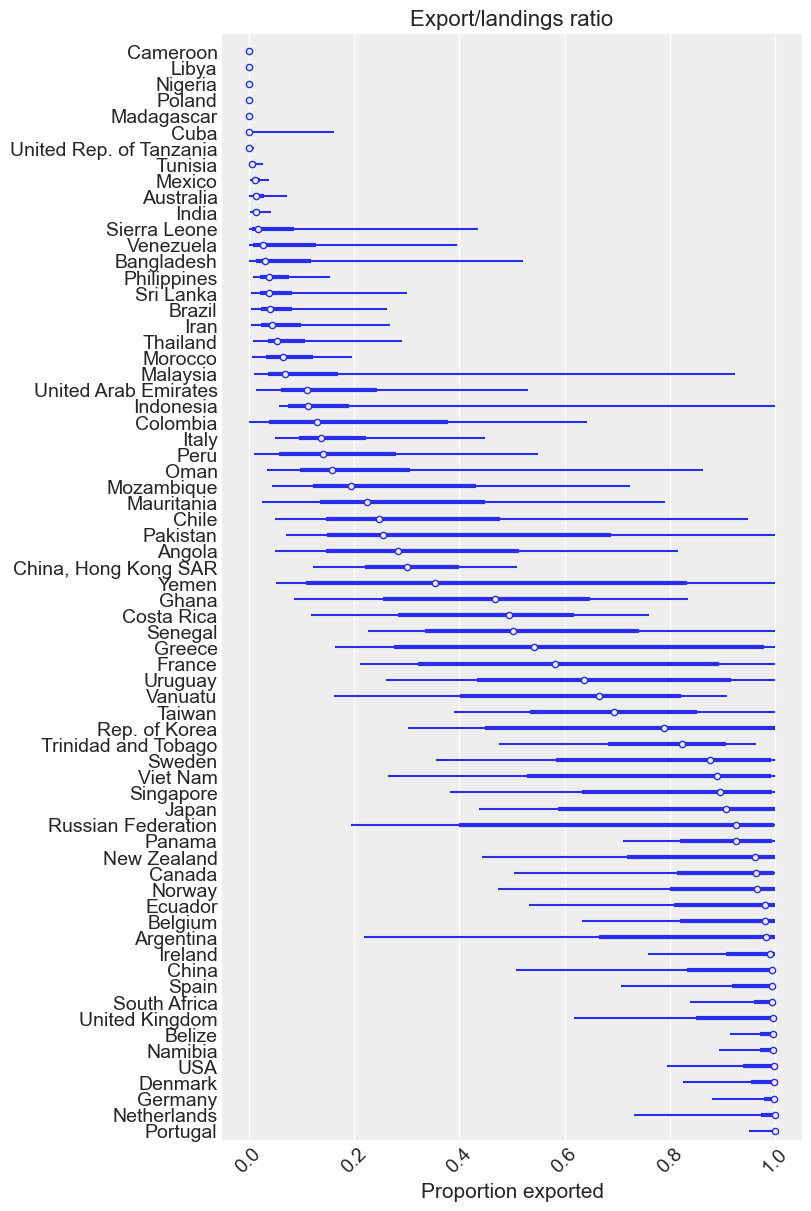

In [50]:
# Plot proportion of trade exported
ax = az.plot_forest(
        prop_ex,
        hdi_prob=0.9,
        combined=True,
        figsize=(8, 12)
        )
ax[0].set(
    title="Export/landings ratio",
    xlabel="Proportion exported",
    ylabel="",
);
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)

tmp_lab = prop_ex.Exporter.to_numpy()[::-1]
tmp_lab[tmp_lab=="Other Asia, nes"] = 'Taiwan'
ax[0].set_yticklabels(tmp_lab)

plt.savefig(bf+'/Global/'+'AUGM_Proportion_exports.jpg',dpi=300);

## Observed bits for plotting


In [51]:
# Grab species level estimates for observed data
Obs_spp_data = np.exp(sdata.drop(columns=['year','year_spp_id','country_spp_id','species_spp_id']
          ).groupby(['country','species']).mean()).rename(columns={"logReported_species_landings": "Reported_landings"})

# Create xarray data of totals by species
Obs_spp_sums = xr.Dataset(Obs_spp_data.groupby(level='species').sum().sort_values(by='Reported_landings', ascending=False))

# Grab taxon level estimates for observed data
Obs_tax_data = np.exp(txdata.drop(columns=['year','year_tax_id','country_tax_id','taxon_tax_id']
          ).groupby(['country','taxon']).mean()).rename(columns={"logReported_taxon_landings": "Reported_landings"})

# Net estimated unreported species-level landings
Net_spp_landings = idata_landings_a.posterior['Latent_landings']-idata_landings_a.posterior['CountrySPP_landings']

## Species proporitons in latent landings

In [52]:
# Select top 10% of traded species
tmp = trade_spp.sum(('exporter','importer')).median(('chain','draw'))
#tmp = idata_landings_a.posterior['Latent_landings'].sum(('exporter')).median(('chain','draw'))
tmp = tmp.sortby(tmp, ascending=False)
sppx_trad = tmp[tmp>np.quantile(tmp,0.90)].species[:15]

late_land = idata_landings_a.posterior['Latent_landings'].sel(species=sppx_trad).sum(('exporter')).rename("")
tmp_ll = late_land.median(('chain','draw')).to_dataframe().reset_index()
tmp_ll.columns = ['species','group','value']
tmp_ll['proportion'] = tmp_ll['value']/sum(tmp_ll['value'])
tmp_ll.sort_values(by='value',ascending=False)

species   group          value  proportion
0            Prionace glauca  sharks  138615.021123    0.504901
2   Carcharhinus falciformis  sharks   30035.935882    0.109405
1          Squalus acanthias  sharks   19134.575568    0.069697
3          Isurus oxyrinchus  sharks   18781.783031    0.068412
6          Alopias pelagicus  sharks   11082.441489    0.040367
4         Leucoraja ocellata    rays    8760.941843    0.031911
7      Scyliorhinus canicula  sharks    7306.477349    0.026614
8               Raja clavata    rays    6541.315130    0.023827
13     Alopias superciliosus  sharks    6211.864514    0.022627
14          Alopias vulpinus  sharks    5756.312068    0.020967
5         Leucoraja erinacea    rays    5674.156101    0.020668
9         Galeorhinus galeus  sharks    5392.547055    0.019642
11           Sphyrna zygaena  sharks    4614.821598    0.016809
12          Leucoraja naevus    rays    3771.409535    0.013737
10            Raja brachyura    rays    2859.367907    0.010415

In [53]:
# Latent trade
late_trad = trade_spp.sel(species=sppx_trad).sum(('exporter','importer')).rename("")
tmp_lt = late_trad.median(('chain','draw')).to_dataframe().reset_index()
tmp_lt.columns = ['species','group','value']
tmp_lt['proportion'] = tmp_lt['value']/sum(tmp_lt['value'])
tmp_lt.sort_values(by='value',ascending=False)

species   group          value  proportion
0            Prionace glauca  sharks  110122.496444    0.560704
1          Squalus acanthias  sharks   16251.736479    0.082748
2   Carcharhinus falciformis  sharks   13782.463095    0.070175
3          Isurus oxyrinchus  sharks   12798.567498    0.065166
4         Leucoraja ocellata    rays    9195.173746    0.046819
5         Leucoraja erinacea    rays    6368.961418    0.032428
6          Alopias pelagicus  sharks    6046.251902    0.030785
7      Scyliorhinus canicula  sharks    4655.283203    0.023703
8               Raja clavata    rays    4118.339950    0.020969
9         Galeorhinus galeus  sharks    3680.916300    0.018742
10            Raja brachyura    rays    2390.382428    0.012171
11           Sphyrna zygaena  sharks    1878.902120    0.009567
12          Leucoraja naevus    rays    1741.214120    0.008866
13     Alopias superciliosus  sharks    1700.543677    0.008659
14          Alopias vulpinus  sharks    1669.161186    0.008499

In [54]:
top_latent = tmp_lt.merge(tmp_ll,on='species').drop(columns=['group_y'])
top_latent.columns = ['species','group','trade','proportion_trade','landings','proportion_land']
top_latent['prop_exported'] = top_latent.trade/top_latent.landings
top_latent

species   group          trade  proportion_trade  \
0            Prionace glauca  sharks  110122.496444          0.560704   
1          Squalus acanthias  sharks   16251.736479          0.082748   
2   Carcharhinus falciformis  sharks   13782.463095          0.070175   
3          Isurus oxyrinchus  sharks   12798.567498          0.065166   
4         Leucoraja ocellata    rays    9195.173746          0.046819   
5         Leucoraja erinacea    rays    6368.961418          0.032428   
6          Alopias pelagicus  sharks    6046.251902          0.030785   
7      Scyliorhinus canicula  sharks    4655.283203          0.023703   
8               Raja clavata    rays    4118.339950          0.020969   
9         Galeorhinus galeus  sharks    3680.916300          0.018742   
10            Raja brachyura    rays    2390.382428          0.012171   
11           Sphyrna zygaena  sharks    1878.902120          0.009567   
12          Leucoraja naevus    rays    1741.214120          0.008866   
13     Alopias superciliosus  sharks    1700.543677          0.008659   
14          Alopias vulpinus  sharks    1669.161186          0.008499   

         landings  proportion_land  prop_exported  
0   138615.021123         0.504901       0.794449  
1    19134.575568         0.069697       0.849339  
2    30035.935882         0.109405       0.458866  
3    18781.783031         0.068412       0.681435  
4     8760.941843         0.031911       1.049565  
5     5674.156101         0.020668       1.122451  
6    11082.441489         0.040367       0.545570  
7     7306.477349         0.026614       0.637145  
8     6541.315130         0.023827       0.629589  
9     5392.547055         0.019642       0.682593  
10    2859.367907         0.010415       0.835983  
11    4614.821598         0.016809       0.407145  
12    3771.409535         0.013737       0.461688  
13    6211.864514         0.022627       0.273757  
14    5756.312068         0.020967       0.289971

## Plot top reported and unreported species

In [55]:
# Select top 10% of traded species
tmp = trade_spp.sum(('exporter','importer')).median(('chain','draw'))
#tmp = idata_landings_a.posterior['Latent_landings'].sum(('exporter')).median(('chain','draw'))
tmp = tmp.sortby(tmp, ascending=False)
sppx_trad = tmp[tmp>np.quantile(tmp,0.90)].species[:15]

# Select reported landings
rep_land = idata_landings_a.posterior['CountrySPP_landings'].sel(species=sppx_trad).sum(('exporter')).rename("")

# Select unreported landings
unrep_land = idata_landings_a.posterior['CountrySPP_Taxonlandings'].sel(species=sppx_trad).sum(('exporter')).rename("")

# Proportion unreported
prop_land = unrep_land/(rep_land+unrep_land)

# Select trade
late_trad = trade_spp.sel(species=sppx_trad).sum(('exporter','importer')).rename("")

# Proporiton of unreported trade
un_trad = late_trad*prop_land

In [56]:
tmp = rep_land.mean(('chain','draw')).to_dataframe().reset_index()
tmp.columns = ['species','group','value']
tmp['proportion'] = tmp['value']/sum(tmp['value'])
tmp.sort_values(by='value',ascending=False)

species   group          value  proportion
0            Prionace glauca  sharks  115735.788876    0.577868
1          Squalus acanthias  sharks   15940.890592    0.079593
3          Isurus oxyrinchus  sharks   12725.788658    0.063540
2   Carcharhinus falciformis  sharks    8522.597797    0.042553
6          Alopias pelagicus  sharks    6960.214745    0.034752
7      Scyliorhinus canicula  sharks    6569.156866    0.032800
4         Leucoraja ocellata    rays    6521.081744    0.032560
8               Raja clavata    rays    5418.348690    0.027054
5         Leucoraja erinacea    rays    4465.460617    0.022296
9         Galeorhinus galeus  sharks    4353.533785    0.021737
12          Leucoraja naevus    rays    3254.568873    0.016250
13     Alopias superciliosus  sharks    2634.866990    0.013156
10            Raja brachyura    rays    2504.414602    0.012505
14          Alopias vulpinus  sharks    2489.406322    0.012430
11           Sphyrna zygaena  sharks    2184.480591    0.010907

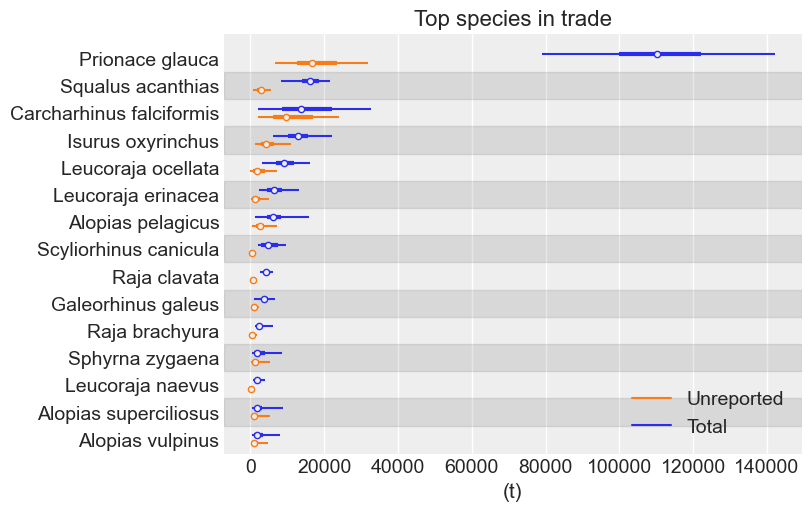

In [57]:
# = = = = = Set up plot
_, ax = plt.subplots(1,1,figsize=(8, 5))

# Exporters
az.plot_forest(
    [late_trad, un_trad],
    model_names=["Total", "Unreported"],
    figsize=(5, 12),
    combined=True,
    ax=ax
)
tmp_lab = sppx_trad.to_numpy()[::-1]
#ax.set_xlim(-2000, 25000)
#ax.set_xscale('log')
ax.set_yticklabels(tmp_lab)
ax.set_title("Top species in trade")
#ax.legend(loc="lower right")

ax.set_xlabel('(t)')
plt.savefig(bf+'/Global/'+'Top_traded_species.jpg',dpi=300);

#### 

## Plot non-blue shark trade

In [58]:
# Select top 10% of traded species
tmp = trade_spp.sum(('exporter','importer')).median(('chain','draw'))
#tmp = idata_landings_a.posterior['Latent_landings'].sum(('exporter')).median(('chain','draw'))
tmp = tmp.sortby(tmp, ascending=False)
# Species with more than 100 tonnes traded globally/year
sppx_trad = tmp[tmp>100].species

In [59]:
# Select top 10% of traded species
tmp = trade_spp.sum(('exporter','importer')).median(('chain','draw'))
#tmp = idata_landings_a.posterior['Latent_landings'].sum(('exporter')).median(('chain','draw'))
tmp = tmp.sortby(tmp, ascending=False)
# Species with more than 100 tonnes traded globally/year
sppx_trad = tmp[tmp>100].species
# blue shark trade
bs_trad = sppx_trad[0]
sppx_trad = sppx_trad[1:]

# Select reported landings
rep_land = idata_landings_a.posterior['CountrySPP_landings'].sel(species=sppx_trad).sum(('exporter')).rename("")
rep_land_bs = idata_landings_a.posterior['CountrySPP_landings'].sel(species=bs_trad).sum(('exporter')).rename("")

# Select unreported landings
unrep_land = idata_landings_a.posterior['CountrySPP_Taxonlandings'].sel(species=sppx_trad).sum(('exporter')).rename("")
unrep_land_bs = idata_landings_a.posterior['CountrySPP_Taxonlandings'].sel(species=bs_trad).sum(('exporter')).rename("")

# Proportion unreported
prop_land = unrep_land/(rep_land+unrep_land)
prop_land_bs = unrep_land_bs/(rep_land_bs+unrep_land_bs)

# Select trade
late_trad = trade_spp.sel(species=sppx_trad).sum(('exporter','importer')).rename("")
late_trad_bs = trade_spp.sel(species=bs_trad).sum(('exporter','importer')).rename("")

# Proporiton of unreported trade
un_trad = late_trad*prop_land
un_trad_bs = late_trad_bs*prop_land_bs

## Skate trade detail

In [60]:
trade_spp.sel(species=['Leucoraja ocellata','Leucoraja erinacea'],exporter='USA',importer=['KOR','FRA']).median(('chain','draw')).sum('species')

<xarray.DataArray '' (importer: 2)>
array([2516.91336265, 2321.6703918 ])
Coordinates:
    exporter  <U3 'USA'
  * importer  (importer) <U3 'KOR' 'FRA'
    Exporter  object 'USA'
    Importer  (importer) object 'Rep. of Korea' 'France'

### Blue shark proportion of total trade

In [61]:
# Blue shark proportion of total trade
bs_prop = late_trad_bs/(late_trad_bs+late_trad.sum('species'))
np.quantile(bs_prop,(0.5, 0.05, 0.95))

array([0.3471884 , 0.26831608, 0.42294257])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


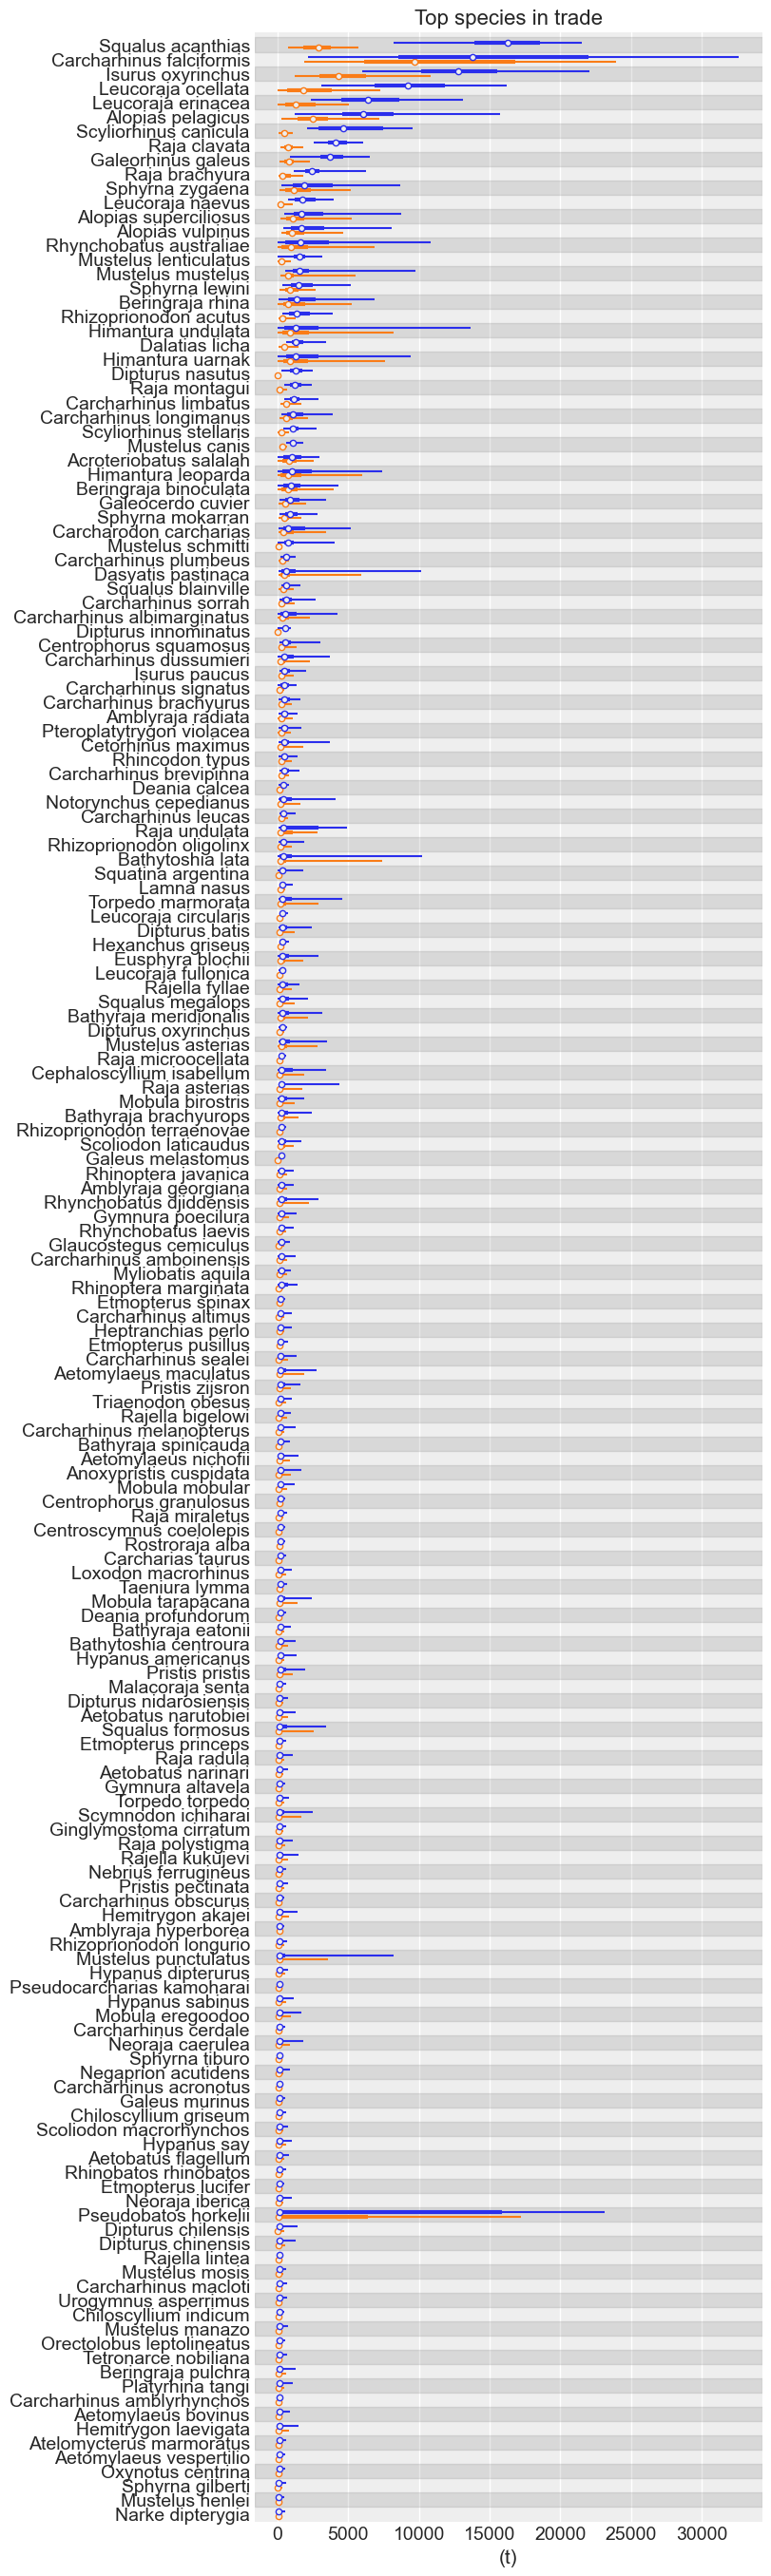

In [62]:
# = = = = = Set up plot
_, ax = plt.subplots(1,1,figsize=(8, 27))

# Exporters
az.plot_forest(
    [late_trad, un_trad],
    model_names=["Total", "Unreported"],
    figsize=(5, 12),
    combined=True,
    ax=ax
)
tmp_lab = sppx_trad.to_numpy()[::-1]
#ax.set_xlim(-2000, 25000)
#ax.set_xscale('log')
ax.set_yticklabels(tmp_lab)
ax.set_title("Top species in trade")
ax.legend(loc="lower right")

ax.set_xlabel('(t)')
plt.savefig(bf+'/Global/'+'Top_traded_species_long.jpg',dpi=300);

## Trade by group

## Plot traded vs CITES and ICUN status

In [63]:
# Download CITES 2013 status
cdata = pd.read_csv(bd+'cites_listing_2013.csv')
#cdata['CITES'] = np.array([s.split('(')[0] for s in list(cdata.CITES_YEAR.values.astype(str))])
#cdata['Year'] = np.array([s.split('(')[1][:-1] for s in list(cdata.CITES_YEAR.values.astype(str))]).astype(int)
CITES = np.array(['Not listed']*len(trade_spp.species))
tmp = match(list(cdata.Species.values),list(trade_spp.species.values))
CITES[np.array(tmp[tmp!=None]).astype(int)] = 'Listed'

In [64]:
# Download CITES status up to 2022
cdata22 = pd.read_csv(bd+'cites_listing.csv')
CITES22 = np.array(['Not listed']*len(trade_spp.species))
tmp = match(list(cdata22.Species.values),list(trade_spp.species.values))
CITES22[np.array(tmp[tmp!=None]).astype(int)] = 'Listed'

In [65]:
# Download redlist status
rdata = pd.read_excel(bd+'SHARKS_species_current_status_full_list.xlsx',header=0).sort_values(by='genus').reset_index()
# Full species name
rdata['species_'] = rdata[['genus','species']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# Grab Current IUCN status
tmp = rdata.Rlcategory[match(species_,list(rdata.species_))].to_numpy()
# Make endangered and critically endangered 
IUCN = np.array(['Not','Endangered'])[((tmp=='CR') + (tmp=='EN'))*1]
# Make endangered and critically endangered plus vulnerable 
IUCN_vu = np.array(['Not','VUENCR'])[((tmp=='CR') + (tmp=='EN') + (tmp=='VU'))*1]
# Make all categories
IUCN_all = tmp

# Grab IUCN 2013 status
tmp = tidata.OldRLCategory[match(species_,list(tidata.species_binomial))].to_numpy()
# Make endangered and critically endangered 
IUCN13 = np.array(['Not','Endangered'])[((tmp=='CR') + (tmp=='EN'))*1]
# Make endangered and critically endangered + vulnerable
IUCN13_vu = np.array(['Not','VUENCR'])[((tmp=='CR') + (tmp=='EN') + (tmp=='VU'))*1]
# Make all categories
IUCN13_all = tmp

In [66]:
cdata

Order          Family                  Species  \
0   Rhinopristiformes       Pristidae   Anoxypristis cuspidata   
1   Rhinopristiformes       Pristidae          Pristis clavata   
2   Rhinopristiformes       Pristidae        Pristis pectinata   
3   Rhinopristiformes       Pristidae          Pristis pristis   
4   Rhinopristiformes       Pristidae          Pristis zijsron   
5         Lamniformes    Cetorhinidae       Cetorhinus maximus   
6    Orectolobiformes  Rhincodontidae          Rhincodon typus   
7         Lamniformes        Lamnidae   Carcharodon carcharias   
8   Carcharhiniformes  Carcharhinidae  Carcharhinus longimanus   
9   Carcharhiniformes      Sphyrnidae           Sphyrna lewini   
10  Carcharhiniformes      Sphyrnidae         Sphyrna mokarran   
11  Carcharhiniformes      Sphyrnidae          Sphyrna zygaena   
12        Lamniformes        Lamnidae              Lamna nasus   
13    Myliobatiformes       Mobulidae           Mobula alfredi   
14    Myliobatiformes       Mobulidae         Mobula birostris   

            CITES_YEAR  CITES_2013  
0    Appendix I (2007)           1  
1    Appendix I (2007)           1  
2    Appendix I (2007)           1  
3    Appendix I (2007)           1  
4    Appendix I (2007)           1  
5   Appendix II (2003)           1  
6   Appendix II (2003)           1  
7   Appendix II (2005)           1  
8   Appendix II (2013)           1  
9   Appendix II (2013)           1  
10  Appendix II (2013)           1  
11  Appendix II (2013)           1  
12  Appendix II (2013)           1  
13  Appendix II (2013)           1  
14  Appendix II (2013)           1

In [67]:
# Total landings in all species
tot_land = (idata_landings_a.posterior['Latent_landings'].sum('exporter').rename("")
            .assign_coords({"CITES": ("species", CITES), 
                            "CITES22": ("species", CITES22), 
                            "IUCN": ("species", IUCN), 
                            "IUCN13": ("species", IUCN13),
                           "IUCN_vu": ("species", IUCN_vu),
                           "IUCN13_vu": ("species", IUCN13_vu)})
           )
mu_tot_land = tot_land.median(('chain','draw')).to_dataframe(name='Landings').reset_index()

# Total trade in all species
tot_trade = (trade_spp.sum(('exporter','importer')).rename("")
             .assign_coords({"CITES": ("species", CITES),
                            "CITES22": ("species", CITES22), 
                             "IUCN": ("species", IUCN), 
                             "IUCN13": ("species", IUCN13),
                           "IUCN_vu": ("species", IUCN_vu),
                           "IUCN13_vu": ("species", IUCN13_vu)})
            )
mu_tot_trade = tot_trade.median(('chain','draw')).to_dataframe(name='Exports').reset_index()

# merge dataframes
mu_tot = mu_tot_land.merge(mu_tot_trade)

# Calculate sum of squares to 1:1 to determine level of domestic consumption
mu_tot['Exports/Landings'] = mu_tot.Exports/mu_tot.Landings

# Create column for boxplots of SSE
mu_tot['Listing'] = np.array(['Not listed']*len(mu_tot['IUCN13']))
mu_tot.loc[(mu_tot.CITES=='Listed')&(mu_tot.IUCN13=='Endangered'),'Listing'] = 'Both'
mu_tot.loc[(mu_tot.CITES!='Listed')&(mu_tot.IUCN13=='Endangered'),'Listing'] = 'Endangered'
mu_tot.loc[(mu_tot.CITES=='Listed')&(mu_tot.IUCN13!='Endangered'),'Listing'] = 'CITES listed'

# Cut to >100 t
maskx = (mu_tot.Exports>100) & (mu_tot.Landings>100)
# Store spp >100t
spp_100 = species_[maskx]
mu_tot = mu_tot.loc[maskx]

In [68]:
# Number of species with >100t of trade
len(spp_100)

173

## Effects on landings model

In [71]:
# Response
ExLand_log = np.log(mu_tot['Landings'])
ExLand_log_z = (ExLand_log-np.mean(ExLand_log))/(2*np.std(ExLand_log))
# IUCN
IUCN_,Ii = indexall(mu_tot.IUCN13)
# CITES
CITES_,Ic = indexall(mu_tot.CITES)
# Coordinates
COORDS = {'cites':CITES_, 'iucn':IUCN_, "observation": ExLand_log.index.values}

In [72]:
with pm.Model(coords=COORDS) as iucn_direct_landings_model:

    # Intercept
    Avg = pm.Normal('Avg', 0, 1.5)
    # CITES direct effect
    b_cites = pm.Normal('CITES', 0, 1.5)
    # IUCN direct effect
    b_iucn = pm.Normal('IUCN', 0, 1.5)

    # Linear model
    mu_listing = pm.Deterministic('mu_listing', Avg+b_cites*Ic+b_iucn*Ii, dims="observation")

    # Variance
    sd_listing = pm.Exponential('sd_listing',1)
    
    # Likelihood
    pm.Normal('Yi', mu_listing, sd_listing, observed=ExLand_log, dims="observation")

    # Average direct IUCN effect on natural scale
    iucn_direct = pm.Deterministic('iucn_direct', pm.math.exp(Avg)-pm.math.exp(Avg+b_iucn))
    
    # Average direct CITES effect on probability scale
    cites_direct = pm.Deterministic('cites_direct', pm.math.exp(Avg)-pm.math.exp(Avg+b_cites))

In [73]:
with iucn_direct_landings_model:
    iucn_direct_land_idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Avg, CITES, IUCN, sd_listing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [74]:
with pm.Model(coords=COORDS) as iucn_total_landings_model:

    # Intercept
    Avg= pm.Normal('Avg', 0, 1.5)
    # IUCN total effect
    b_iucn = pm.Normal('IUCN', 0, 1.5)

    # Linear model
    mu_listing = pm.Deterministic('mu_listing', Avg+b_iucn*Ii, dims="observation")

    # Variance
    sd_listing = pm.Exponential('sd_listing',1)

    # Likelihood
    pm.Normal('Yi', mu_listing, sd_listing, observed=ExLand_log, dims="observation")

    # Average total IUCN effect on natural scale
    iucn_total = pm.Deterministic('iucn_total', pm.math.exp(Avg)-pm.math.exp(Avg+b_iucn))

In [75]:
with iucn_total_landings_model:
    iucn_total_land_idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Avg, IUCN, sd_listing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [76]:
pm.summary(iucn_total_land_idata, var_names=['Avg', 'IUCN', 'iucn_total'])

mean       sd    hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Avg           6.984    0.098     6.785    7.154      0.002    0.001    3826.0   
IUCN          0.325    0.274    -0.177    0.853      0.004    0.003    4459.0   
iucn_total -458.192  413.652 -1230.071  265.584      6.163    4.996    4591.0   

            ess_tail  r_hat  
Avg           2944.0    1.0  
IUCN          2832.0    1.0  
iucn_total    2932.0    1.0

In [77]:
pm.summary(iucn_direct_land_idata, var_names=['Avg','CITES', 'IUCN','iucn_direct','cites_direct'])

mean       sd    hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Avg              6.946    0.101     6.749    7.127      0.002    0.001   
CITES            0.747    0.348     0.083    1.383      0.006    0.004   
IUCN             0.159    0.286    -0.372    0.707      0.005    0.004   
iucn_direct   -220.448  364.212  -887.299  437.258      6.023    4.524   
cites_direct -1281.760  814.680 -2799.623   36.559     13.230    9.483   

              ess_bulk  ess_tail  r_hat  
Avg             3675.0    3222.0    1.0  
CITES           3694.0    2902.0    1.0  
IUCN            3673.0    3245.0    1.0  
iucn_direct     3684.0    3289.0    1.0  
cites_direct    3738.0    2889.0    1.0

## Effects on trade model

In [78]:
# Response
Eprop = (mu_tot['Exports/Landings']*100).astype(int)
Eprop[Eprop>100] = 100
# IUCN
IUCN_,Ii = indexall(mu_tot.IUCN13)
# CITES
CITES_,Ic = indexall(mu_tot.CITES)
# Coordinates
COORDS = {'cites':CITES_, 'iucn':IUCN_, "observation": mu_tot.index.values}

In [79]:
with pm.Model(coords=COORDS) as iucn_direct_model:

    # Intercept
    Avg_prop = pm.Normal('Avg_prop', 0, 1.5)
    # CITES direct effect
    b_cites = pm.Normal('CITES', 0, 1.5)
    # IUCN direct effect
    b_iucn = pm.Normal('IUCN', 0, 1.5)

    # Linear model
    p_listing = pm.Deterministic('p_listing', pm.math.invlogit(Avg_prop+b_cites*Ic+b_iucn*Ii), dims="observation")

    # Likelihood
    pm.Binomial('Yi', n=100, p=p_listing, observed=Eprop, dims="observation")

    # Average direct IUCN effect on probability scale
    iucn_direct = pm.Deterministic('iucn_direct', pm.math.invlogit(Avg_prop)-pm.math.invlogit(Avg_prop+b_iucn))
    # Average direct CITES effect on probability scale
    cites_direct = pm.Deterministic('cites_direct', pm.math.invlogit(Avg_prop)-pm.math.invlogit(Avg_prop+b_cites))

In [80]:
with iucn_direct_model:
    iucn_direct_idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Avg_prop, CITES, IUCN]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [81]:
with pm.Model(coords=COORDS) as iucn_total_model:

    # Intercept
    Avg_prop = pm.Normal('Avg_prop', 0, 1.5)
    # IUCN total effect
    b_iucn = pm.Normal('IUCN', 0, 1.5)

    # Linear model
    p_listing = pm.Deterministic('p_listing', pm.math.invlogit(Avg_prop+b_iucn*Ii), dims="observation")

    # Likelihood
    pm.Binomial('Yi', n=100, p=p_listing, observed=Eprop, dims="observation")

    # Average total IUCN effect on probability scale
    iucn_total = pm.Deterministic('iucn_total', pm.math.invlogit(Avg_prop)-pm.math.invlogit(Avg_prop+b_iucn))

In [82]:
with iucn_total_model:
    iucn_total_idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Avg_prop, IUCN]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [83]:
pm.summary(iucn_total_idata, var_names=['Avg_prop', 'IUCN', 'iucn_total'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Avg_prop   -0.465  0.017  -0.494   -0.431      0.000    0.000    3883.0   
IUCN       -0.349  0.050  -0.443   -0.257      0.001    0.001    3642.0   
iucn_total  0.079  0.011   0.058    0.098      0.000    0.000    3658.0   

            ess_tail  r_hat  
Avg_prop      2718.0    1.0  
IUCN          2537.0    1.0  
iucn_total    2773.0    1.0

In [84]:
pm.summary(iucn_direct_idata, var_names=['Avg_prop','CITES', 'IUCN','iucn_direct','cites_direct'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Avg_prop     -0.438  0.017  -0.471   -0.407      0.000    0.000    3970.0   
CITES        -0.643  0.070  -0.772   -0.510      0.001    0.001    4887.0   
IUCN         -0.209  0.053  -0.309   -0.113      0.001    0.001    4107.0   
iucn_direct   0.049  0.012   0.027    0.071      0.000    0.000    4086.0   
cites_direct  0.139  0.013   0.114    0.163      0.000    0.000    4905.0   

              ess_tail  r_hat  
Avg_prop        2714.0    1.0  
CITES           2977.0    1.0  
IUCN            3093.0    1.0  
iucn_direct     3119.0    1.0  
cites_direct    3069.0    1.0

In [85]:
# Calculate effect sizes - landings
IUCN_direct_l = (iucn_direct_land_idata.posterior['iucn_direct'])
CITES_direct_l = (iucn_direct_land_idata.posterior['cites_direct'])
IUCN_total_l = (iucn_total_land_idata.posterior['iucn_total'])
IUCN_indirect_l = IUCN_total_l-IUCN_direct_l

list_effects_l = pd.DataFrame({'IUCN indirect':IUCN_indirect_l.to_numpy().flatten(),
    'IUCN direct':IUCN_direct_l.to_numpy().flatten(), 
                             'IUCN total':IUCN_total_l.to_numpy().flatten(), 
                             'CITES direct':CITES_direct_l.to_numpy().flatten()}).melt()

# Calculate effect sizes - trade
IUCN_direct = iucn_direct_idata.posterior['iucn_direct']*-100
CITES_direct = iucn_direct_idata.posterior['cites_direct']*-100
IUCN_total = iucn_total_idata.posterior['iucn_total']*-100
IUCN_indirect = IUCN_total-IUCN_direct

list_effects = pd.DataFrame({'IUCN indirect':IUCN_indirect.to_numpy().flatten(),
    'IUCN direct':IUCN_direct.to_numpy().flatten(), 
                             'IUCN total':IUCN_total.to_numpy().flatten(), 
                             'CITES direct':CITES_direct.to_numpy().flatten()}).melt()

# Figure 3

/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_46734/1525425729.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g3 = sns.boxplot(data=list_effects_l, x="value", y="variable",
/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_46734/1525425729.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g2 = sns.boxplot(data=list_effects, x="value", y="variable",


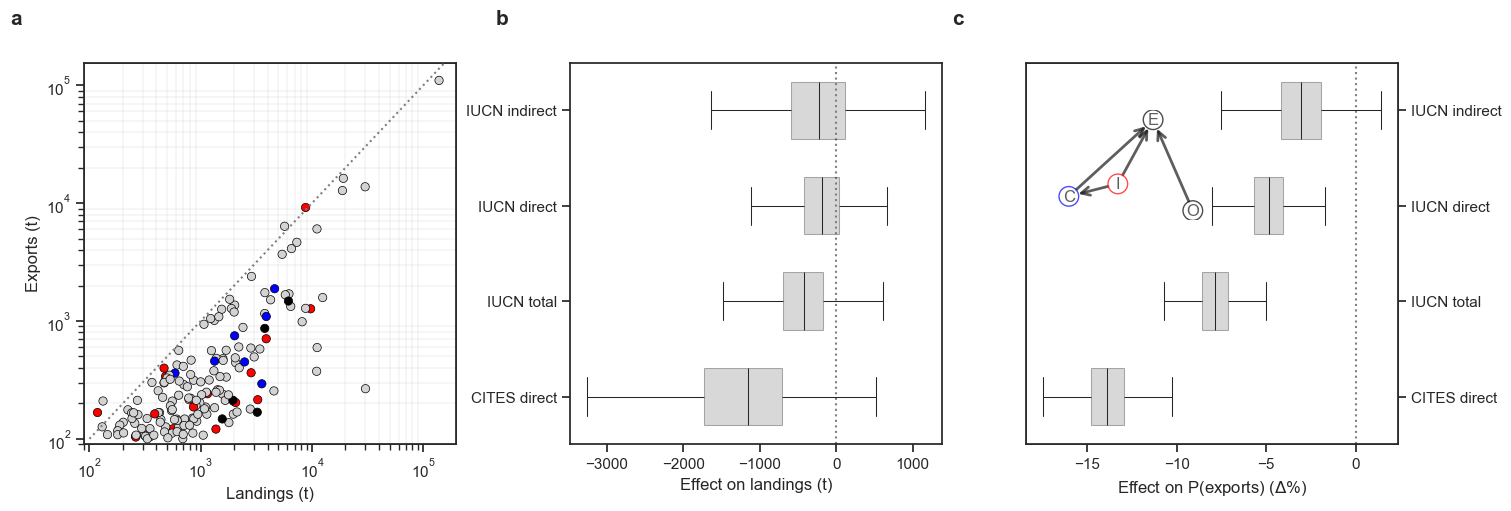

In [89]:
# Set up plot
sns.set_theme(style="ticks", palette="hls")
fsz = 15
#fig, axs = plt.subplots(ncols=2)
fig = plt.figure(figsize=(15,5))
ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)

# -------------------------- Plot CITES Status
g0 = sns.scatterplot(
    data=mu_tot,
    x="Landings", y="Exports",
    hue="Listing",
    palette=('lightgrey','red','black','blue'),
    edgecolor='black', linewidth=.5,
    legend=None,
    ax=ax0
)
g0.set(xscale="log", yscale="log", xlim=(90, None), ylim=(90, None))
g0.xaxis.grid(True, "minor", linewidth=.25)
g0.yaxis.grid(True, "minor", linewidth=.25)
g0.set_xlabel('Landings (t)')
g0.set_ylabel('Exports (t)')

# Add 1:1
ax0.plot((100,10e5), (100,10e5), color='grey', linestyle=':', zorder=10)
# Add journal letter
letter_annotation(ax0, -.2, 1.1, 'a', sz=fsz)

# iterate through each axes and increase the linewidth and add a color
ax0.patch.set_linewidth(.5)
ax0.patch.set_edgecolor('black')
ax2.patch.set_linewidth(.5)
ax2.patch.set_edgecolor('black')

# = = = = = = = = = = = DAG and effects on landings
g3 = sns.boxplot(data=list_effects_l, x="value", y="variable", 
                 #color='#FFFFFF00',
                 palette=('#87cefa','#006db0','#000080','grey'),
                 linewidth=.75, showfliers = False,  ax=ax1, widths = 0.6)
[patch.set(facecolor='grey', edgecolor='black', alpha=0.3) for patch in g3.patches] 
#sns.stripplot(data=list_effects, x="value", y="variable", palette=('#87cefa','#006db0','#000080','grey'), 
#            edgecolor='black', linewidth=.5, zorder=1, ax=ax2)
ax1.yaxis.set_label_position("right")
#ax2.set_yticklabels(['Not listed', 'CITES listed (c. 2013)', 'Endangered (c. 2020)', 'Both'])
ax1.set_ylabel('')
ax1.set_xlabel('Effect on landings (t)')
#ax1.yaxis.tick_right()
ax1.axvline(x=0,color='grey', linestyle=':', zorder=0)
# Add journal letter
letter_annotation(ax1, -.2, 1.1, 'b', sz=fsz)
#ax1.set_xticks((-1,0,1))


# Inset DAG
"""
# These are in unitless percentages of the figure size. (0,0 is bottom left)
#left, bottom, width, height = [0.7, 0.23, 0.124, 0.225]
left, bottom, width, height = [0.51, 0.15, 0.1, 0.225]
ax4 = fig.add_axes([left, bottom, width, height])
# Turn off axes

G1 = nx.DiGraph(directed=True)G1.add_edges_from(
    [('I', 'C'), ('C', 'L'), ('I', 'L'), ('O', 'L')], width=3)
cdict = {'I':'red', 'C':'blue', 'L':'black', 'O':'black'}
options = {
    'node_color': 'white',
    'node_size': 200,
    'width': 2,
    'arrowstyle': '->',
    'arrowsize': 15,
    "edgecolors": [cdict[i] for i in np.array(G1.nodes)],
    "alpha": 0.7
}
nx.draw_networkx(G1, arrows=True, **options, ax=ax4)
ax4.axis("off")
ax4.margins(.1)
"""
# = = = = = = = = = = = DAG and effects on trade
g2 = sns.boxplot(data=list_effects, x="value", y="variable", 
                 #color='#FFFFFF00',
                 palette=('#87cefa','#006db0','#000080','grey'),
                 linewidth=.75, showfliers = False,  ax=ax2, widths = 0.6)
[patch.set(facecolor='grey', edgecolor='black', alpha=0.3) for patch in g2.patches] 
#sns.stripplot(data=list_effects, x="value", y="variable", palette=('#87cefa','#006db0','#000080','grey'), 
#            edgecolor='black', linewidth=.5, zorder=1, ax=ax2)
ax2.yaxis.set_label_position("right")
#ax2.set_yticklabels(['Not listed', 'CITES listed (c. 2013)', 'Endangered (c. 2020)', 'Both'])
ax2.set_ylabel('')
ax2.set_xlabel('Effect on P(exports) ($\Delta$%)')
ax2.yaxis.tick_right()
ax2.axvline(x=0,color='grey', linestyle=':', zorder=0)
# Add journal letter
letter_annotation(ax2, -.2, 1.1, 'c', sz=fsz)
#ax2.axes.get_yaxis().set_visible(False)

# Inset DAG

# These are in unitless percentages of the figure size. (0,0 is bottom left)
#left, bottom, width, height = [0.7, 0.23, 0.124, 0.225]
left, bottom, width, height = [0.7, 0.57, 0.1, 0.22]
ax3 = fig.add_axes([left, bottom, width, height])
# Turn off axes
G = nx.DiGraph(directed=True)
G.add_edges_from(
    [('I', 'C'), ('C', 'E'), ('I', 'E'), ('O', 'E')], width=3)
cdict = {'I':'red', 'C':'blue', 'E':'black', 'O':'black'}
options = {
    'node_color': 'white',
    'node_size': 200,
    'width': 2,
    'arrowstyle': '->',
    'arrowsize': 15,
    "edgecolors": [cdict[i] for i in np.array(G.nodes)],
    "alpha": 0.7
}
nx.draw_networkx(G, arrows=True, **options, ax=ax3)
ax3.axis("off")
#ax3.margins(.1)

#plt.tight_layout()
plt.savefig(bf+'/Global/'+'Landings_vs_trade_CITES_IUCN.jpg',dpi=300);

In [90]:
list_effects_l.value[list_effects_l.variable=='IUCN total'].quantile((0.5,0.05,0.95)).values

array([ -415.8296888 , -1194.11864302,   140.39378936])

In [91]:
list_effects_l.value[list_effects_l.variable=='CITES direct'].quantile((0.5,0.05,0.95)).values

array([-1154.00761774, -2778.64630553,  -204.30392425])

In [92]:
list_effects.value[list_effects.variable=='CITES direct'].quantile((0.5,0.05,0.95)).values

array([-13.88487057, -16.06059865, -11.66743175])

In [93]:
list_effects.value[list_effects.variable=='IUCN total'].quantile((0.5,0.05,0.95)).values

array([-7.87116014, -9.66716648, -6.0882782 ])

In [94]:
list_effects.value[list_effects.variable=='IUCN direct'].quantile((0.5,0.05,0.95)).values

array([-4.83028822, -6.8073179 , -2.85603184])

In [95]:
list_effects.value[list_effects.variable=='IUCN indirect'].quantile((0.5,0.05,0.95)).values

array([-3.03244193, -5.68917656, -0.33528953])

/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_46734/609543978.py:37: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


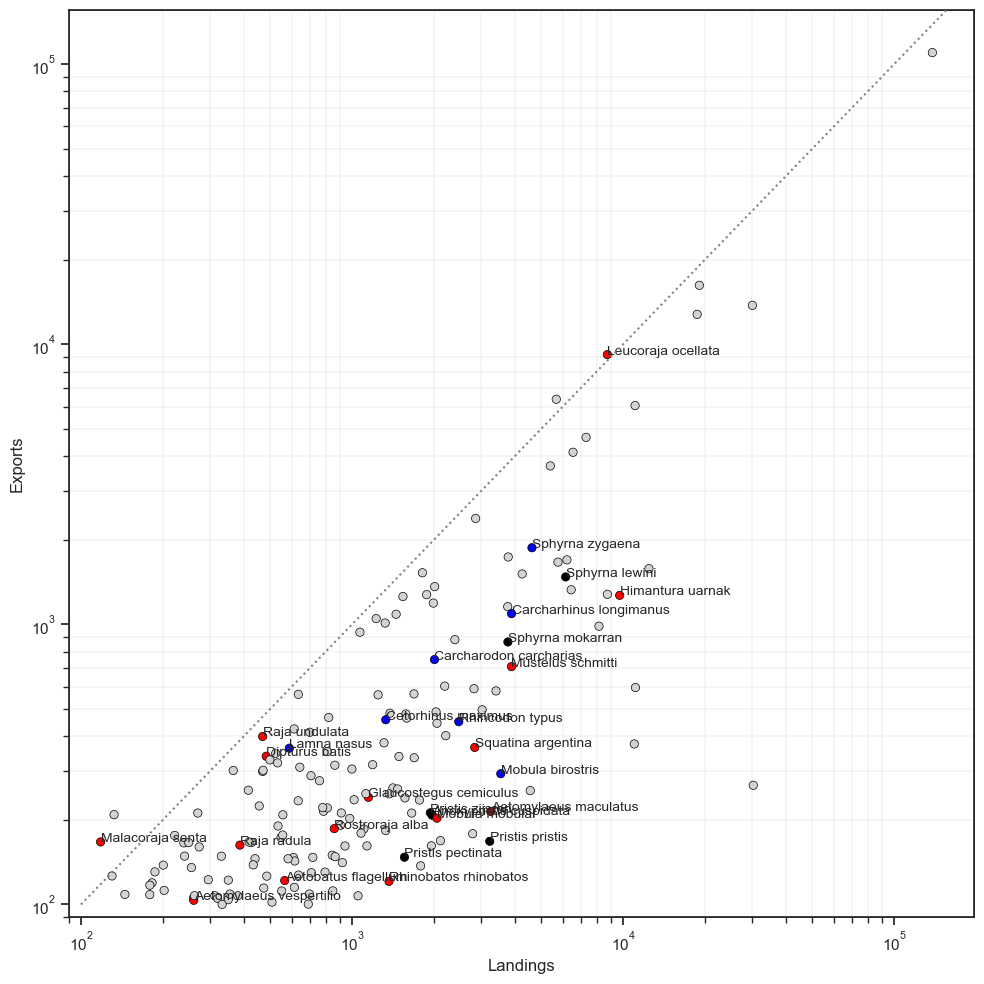

In [96]:
def label_point(x, y, val, ax, sz=10):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), fontsize=sz)

# Set up plot
sns.set_theme(style="ticks", palette="hls")

#fig, axs = plt.subplots(ncols=2)
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
#ax2 = fig.add_subplot(122)

# -------------------------- Plot CITES Status
g0 = sns.scatterplot(
    data=mu_tot,
    x="Landings", y="Exports",
    hue="Listing",
    palette=('lightgrey','red','black','blue'),
    edgecolor='black', linewidth=.5,
    legend=None,
    ax=ax0
)
g0.set(xscale="log", yscale="log", xlim=(90, None), ylim=(90, None))
g0.xaxis.grid(True, "minor", linewidth=.25)
g0.yaxis.grid(True, "minor", linewidth=.25)
# Add 1:1
ax0.plot((100,10e5), (100,10e5), color='grey', linestyle=':', zorder=10)

indx = mu_tot.Listing!='Not listed'
label_point(mu_tot.Landings[indx], mu_tot.Exports[indx], mu_tot.species[indx], ax=g0)

# iterate through each axes and increase the linewidth and add a color
ax0.patch.set_linewidth(.5)
ax0.patch.set_edgecolor('black')

plt.tight_layout()
plt.savefig(bf+'/Global/'+'Landings_vs_trade_CITES_IUCN_labels.jpg',dpi=300);

In [97]:
mu_tot[np.array(['Sphyrna' in s for s in mu_tot.species])]

species       CITES CITES22        IUCN      IUCN13 IUCN_vu  \
606    Sphyrna lewini      Listed  Listed  Endangered  Endangered  VUENCR   
608  Sphyrna mokarran      Listed  Listed  Endangered  Endangered  VUENCR   
609    Sphyrna tiburo  Not listed  Listed  Endangered         Not  VUENCR   
611   Sphyrna zygaena      Listed  Listed         Not         Not  VUENCR   

    IUCN13_vu     Landings   Group      Exports  Exports/Landings  \
606    VUENCR  6144.636652  sharks  1477.643693          0.240477   
608    VUENCR  3761.958072  sharks   865.757625          0.230135   
609       Not   795.246175  sharks   130.499580          0.164100   
611    VUENCR  4614.821598  sharks  1878.902120          0.407145   

          Listing  
606          Both  
608          Both  
609    Not listed  
611  CITES listed

In [98]:
mu_tot[np.array(['Himantura' in s for s in mu_tot.species])]

species       CITES     CITES22        IUCN      IUCN13  \
312  Himantura leoparda  Not listed  Not listed         Not         Not   
313    Himantura uarnak  Not listed  Not listed  Endangered  Endangered   
314  Himantura undulata  Not listed  Not listed  Endangered         Not   

    IUCN_vu IUCN13_vu     Landings Group      Exports  Exports/Landings  \
312  VUENCR    VUENCR  8155.699545  rays   985.766819          0.120868   
313  VUENCR    VUENCR  9723.591799  rays  1269.986628          0.130609   
314  VUENCR    VUENCR  8758.021020  rays  1280.397083          0.146197   

        Listing  
312  Not listed  
313  Endangered  
314  Not listed

## Percent listed exports per country

In [99]:
# Species >100t not blue shark
spp_100_noBS = spp_100[spp_100!='Prionace glauca']

In [100]:
# Select top 10 trading countires
tmp = trade_spp.sel(species=spp_100_noBS).sum(('species','importer')).median(('chain','draw'))
tmp = tmp.sortby(tmp, ascending=False)
cou_ex = tmp[tmp>np.quantile(tmp,0.60)].exporter[:10]

tmp = trade_spp.sel(species=spp_100_noBS).sum(('species','exporter')).median(('chain','draw'))
tmp = tmp.sortby(tmp, ascending=False)
cou_im = tmp[tmp>np.quantile(tmp,0.60)].importer[:10]

# Grab countires
trade_cou = np.unique(list(cou_im.values)+list(cou_ex.values))

In [101]:
# Exports
spp_exports = trade_spp.sel(exporter=trade_cou).sum(('importer')).rename("").assign_coords({"CITES": ("species", CITES), 
                            "CITES22": ("species", CITES22)}).sel(species=spp_100_noBS)
listed_exports = spp_exports[:,:,:,spp_exports.CITES=='Listed']
unlisted_exports = spp_exports[:,:,:,spp_exports.CITES!='Listed']
prop_listed_exports = listed_exports.sum('species')/spp_exports.sum('species')

# Imports
spp_imports = trade_spp.sel(importer=trade_cou).sum(('exporter')).rename("").assign_coords({"CITES": ("species", CITES), 
                            "CITES22": ("species", CITES22)}).sel(species=spp_100_noBS)
listed_imports = spp_imports[:,:,spp_imports.CITES=='Listed',:]
unlisted_imports = spp_imports[:,:,spp_imports.CITES!='Listed',:]
prop_listed_imports = listed_imports.sum('species')/spp_imports.sum('species')

In [102]:
plot_order_ex = prop_listed_exports.sortby(prop_listed_exports.sum(('chain','draw')), ascending=False).exporter
plot_order_im = prop_listed_imports.sortby(prop_listed_imports.sum(('chain','draw')), ascending=False).importer

In [103]:
# Habitat
hdata['Group'] = hdata.Superorder
maskx = hdata.Group=='Batoidea'
hdata.loc[maskx,'Group'] = 'Rays'
maskx = hdata.Group=='Selachimorpha'
hdata.loc[maskx,'Group'] = 'Sharks'
hdata['HabitatGroup'] = np.array([x+' '+y for x,y in zip(hdata.PrimaryHabitat, hdata.Group)])
Habitat_ = hdata.HabitatGroup.values[match(species_,list(hdata.species_binomial))]
Habitat = hdata.Dulvy_priority.values[match(species_,list(hdata.species_binomial))]

In [104]:
# Exports
spp_exports = (trade_spp.sel(exporter=plot_order_ex).sum(('importer'))
               .rename("").assign_coords({"IUCN": ("species", IUCN)})
               .assign_coords({"Habitat": ("species", Habitat)})
               .assign_coords({"CITES": ("species", CITES)})
                .assign_coords({"CITES22": ("species", CITES22)})
                .assign_coords({"IUCN_vu": ("species", IUCN_vu)})
              ).sel(species=spp_100_noBS)
tmp_ex = (spp_exports.to_dataframe(name='trade').reset_index()
          .groupby(['Exporter','IUCN','chain','draw']).sum()
          .reset_index().drop(columns=['exporter','Group','species'])
         )
# Imports
spp_imports = (trade_spp.sel(importer=plot_order_im).sum(('exporter')).rename("")
               .assign_coords({"IUCN": ("species", IUCN)}).assign_coords({"Habitat": ("species", Habitat)})
               .assign_coords({"CITES": ("species", CITES)})
                .assign_coords({"CITES22": ("species", CITES22)})
                .assign_coords({"IUCN_vu": ("species", IUCN_vu)})
              ).sel(species=spp_100_noBS)
tmp_im = (spp_imports.to_dataframe(name='trade').reset_index()
          .groupby(['Importer','IUCN','chain','draw']).sum()
          .reset_index().drop(columns=['importer','Group','species'])
         )

tmp_im.Importer.loc[tmp_im.Importer=='Rep. of Korea'] = 'South Korea'
plot_order_imx = plot_order_im
maskx = plot_order_imx.Importer=='Rep. of Korea'
plot_order_imx.Importer.loc[maskx] = 'South Korea'

/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_46734/4225888564.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_im.Importer.loc[tmp_im.Importer=='Rep. of Korea'] = 'South Korea'


In [105]:
# Order for IUCN categories
cat_ord = ['CR', 'EN', 'VU', 'NT', 'LC', 'DD']

In [106]:
plot_order_exx = plot_order_ex.copy()
plot_order_exx.Exporter.loc[plot_order_exx.Exporter=='Other Asia, nes'] = 'Taiwan'

In [107]:
# Original subset of countries for species exports
#spp_exports = trade_spp.sel(exporter=plot_order_ex).sum(('importer')).rename("").assign_coords({"IUCN": ("species", IUCN)}).assign_coords({"Habitat": ("species", Habitat)}).assign_coords({"CITES": ("species", CITES)})
# Exports all countries
spp_exports = (trade_spp.sum(('importer')).rename("").assign_coords({"IUCN": ("species", IUCN)})
               .assign_coords({"IUCN": ("species", IUCN)})
               .assign_coords({"IUCN_vu": ("species", IUCN_vu)})
               .assign_coords({"Habitat": ("species", Habitat)})
               .assign_coords({"CITES": ("species", CITES)})
               .assign_coords({"CITES22": ("species", CITES22)})
               .sel(species=spp_100_noBS)
              )

# Domestic retention all countries
spp_domestic = (domestic_spp.sum(('importer')).rename("").assign_coords({"IUCN": ("species", IUCN)})
               .assign_coords({"IUCN": ("species", IUCN)})
               .assign_coords({"IUCN_vu": ("species", IUCN_vu)})
               .assign_coords({"Habitat": ("species", Habitat)})
               .assign_coords({"CITES": ("species", CITES)})
               .assign_coords({"CITES22": ("species", CITES22)})
               .sel(species=spp_100_noBS)
              )

In [108]:

#"""
# Habitat ordering - DULVY categories
hab_ord = ['Tropical rays', 'Tropical requiem sharks', 'Skates', 
           'Deepwater sharks', 'Other', 'Hammerhead sharks', 
           'Epipelagic sharks', 'Smoothhounds, dogfish, tope']
# Habitat colouring
hab_col = ['#d2b48c', '#654321', '#778899','#000000', 'green', '#add8e6','#00008b', 'pink']
# Dictonary for habitats and colours
hab_dic = dict(zip(hab_ord, hab_col))

"""

# Habitat ordering - Habitat
hab_ord = ['Coastal Rays', 'Coastal Sharks', 'Deepwater Rays',
            'Deepwater Sharks', 'Freshwater Rays', 'Pelagic Rays',
               'Pelagic Sharks']
# Habitat colouring
hab_col = ['#d2b48c', '#654321', '#333333','#000000', '#FFFFFF', '#add8e6','#00008b']
# Dictonary for habitats and colours
hab_dic = dict(zip(hab_ord, hab_col))
#"""


"\n\n# Habitat ordering - Habitat\nhab_ord = ['Coastal Rays', 'Coastal Sharks', 'Deepwater Rays',\n            'Deepwater Sharks', 'Freshwater Rays', 'Pelagic Rays',\n               'Pelagic Sharks']\n# Habitat colouring\nhab_col = ['#d2b48c', '#654321', '#333333','#000000', '#FFFFFF', '#add8e6','#00008b']\n# Dictonary for habitats and colours\nhab_dic = dict(zip(hab_ord, hab_col))\n#"

/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_46734/1712955419.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(plot_order_exx.Exporter.values, rotation=45);


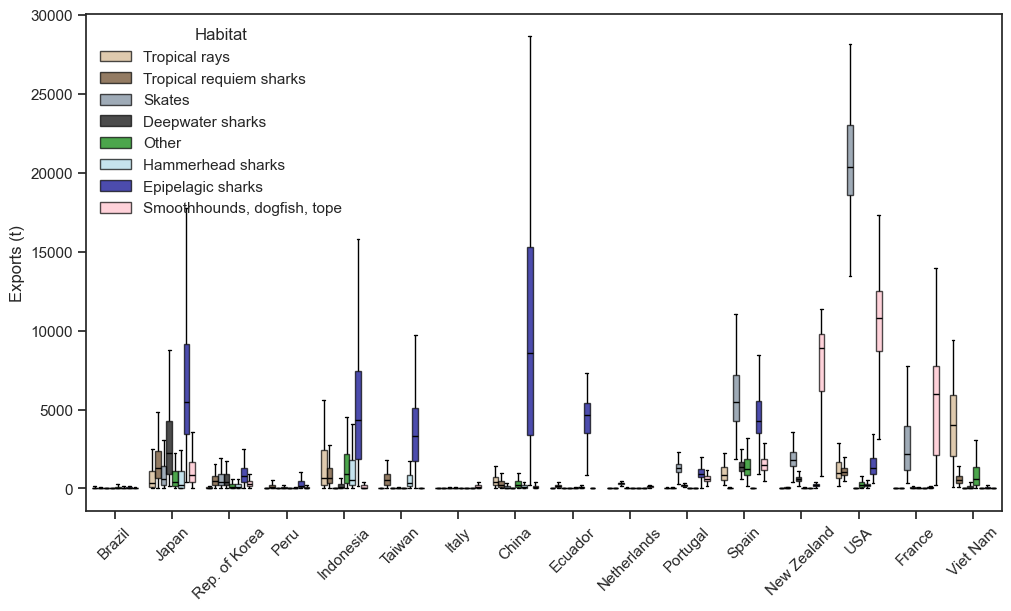

In [109]:
tmp_exH = (spp_exports
           #.drop_sel(species='Prionace glauca')
           .to_dataframe(name='trade').reset_index()
           .groupby(['Exporter','Habitat','chain','draw']).sum()
           .reset_index().drop(columns=['exporter','Group','species'])

          )
# = = = = = Set up plot
_, ax = plt.subplots(1,1,figsize=(10, 6))

# Set colour pallette
sns.set_theme(style="ticks", palette="hls")

# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="Exporter", y="trade",
            hue="Habitat", 
            hue_order=hab_ord,
            palette=hab_col,
            saturation=1,
            data=tmp_exH,
            showfliers=False,
            order=plot_order_ex.Exporter.values,
            ax=ax, 
            boxprops=dict(alpha=.7)
           ).set(
    xlabel='', 
    ylabel='Exports (t)',
)

ax.set_xticklabels(plot_order_exx.Exporter.values, rotation=45);
#plt.savefig(bf+'/Global/'+'Exports_vs_Habitat_by_Country.jpg',dpi=300);

In [110]:
# Grab trade without blue sharks
trade_noBS = (spp_exports
              #.drop_sel(species='Prionace glauca')
           .to_dataframe(name='trade').reset_index()
             .drop(columns=['IUCN','CITES','IUCN_vu','CITES22','Group'])
)
trade_HAB = trade_noBS.drop(columns=['exporter','species','Exporter']).groupby(['Habitat','chain','draw']).sum().reset_index()

# Grab domestic without blue sharks
domestic_noBS = (spp_domestic
              #.drop_sel(species='Prionace glauca')
           .to_dataframe(name='trade').reset_index()
             .drop(columns=['IUCN','CITES','IUCN_vu','CITES22','Group'])
)
domestic_HAB = domestic_noBS.drop(columns=['exporter','species','Exporter']).groupby(['Habitat','chain','draw']).sum().reset_index()

In [111]:
# Calculate order by habtiat group
plot_order_habitat = ((spp_exports
                       #.drop_sel(species='Prionace glauca')
            .mean(('chain','draw','exporter')).to_dataframe(name='trade').reset_index()
            .groupby(['Habitat']).sum()).reset_index().drop(columns=['species','Group','IUCN','CITES','IUCN_vu','CITES22'])
            .sort_values(by='trade').Habitat.values
                     )[::-1]

In [112]:
# Grab reported composition of species
sdata['Habitat'] = hdata.Dulvy_priority.values[match(sdata.species,list(hdata.species_binomial))]
#sdata['Habitat'] = hdata.HabitatGroup.values[match(sdata.species,list(hdata.species_binomial))]
sdata['Reported_species_landings'] = np.exp(sdata.logReported_species_landings)

In [113]:
hprops_old = sdata.groupby('Habitat').sum().drop(columns=['year_spp_id','species_spp_id',
                                             'logReported_species_landings','country',
                                             'year','species','country_spp_id']).loc[plot_order_habitat[:-1]]
hprops_old = hprops_old.Reported_species_landings/hprops_old.Reported_species_landings.sum()

In [114]:
hprops_new = trade_HAB.drop(columns=['draw','chain']).groupby('Habitat').mean().loc[plot_order_habitat]
hprops_new = hprops_new.trade/hprops_new.trade.sum()

In [115]:
# Net difference in species compositions between landings and trade
props_diff = (hprops_new-hprops_old).loc[plot_order_habitat]
# Deal with freshwater rays
props_diff[np.isnan(props_diff)] = 0

In [116]:
# Grab 2020 IUCN status
tmp = rdata.Rlcategory[match(trade_noBS.species,list(rdata.species_))].to_numpy()

In [117]:
np.array(['Not','VUENCR'])[((tmp=='CR') + (tmp=='EN') + (tmp=='VU'))*1]

array(['Not', 'VUENCR', 'VUENCR', ..., 'VUENCR', 'VUENCR', 'VUENCR'],
      dtype='<U6')

In [118]:
# Make endangered and critically endangered 
trade_noBS['iucn'] = np.array(['Not','Endangered'])[((tmp=='CR') + (tmp=='EN'))*1]
trade_noBS['iucn_vu'] = np.array(['Not','VUENCR'])[((tmp=='CR') + (tmp=='EN') + (tmp=='VU'))*1]

In [119]:
trade_noBS

chain  draw exporter                 species      Exporter  \
0            0     0      AGO  Acroteriobatus salalah        Angola   
1            0     0      AGO     Aetobatus flagellum        Angola   
2            0     0      AGO      Aetobatus narinari        Angola   
3            0     0      AGO    Aetobatus narutobiei        Angola   
4            0     0      AGO     Aetomylaeus bovinus        Angola   
...        ...   ...      ...                     ...           ...   
2339195      3    49      ZAF    Tetronarce nobiliana  South Africa   
2339196      3    49      ZAF       Torpedo marmorata  South Africa   
2339197      3    49      ZAF         Torpedo torpedo  South Africa   
2339198      3    49      ZAF       Triaenodon obesus  South Africa   
2339199      3    49      ZAF    Urogymnus asperrimus  South Africa   

                         Habitat         trade        iucn iucn_vu  
0                          Other  4.776515e-08         Not     Not  
1                  Tropical rays  4.157178e-11  Endangered  VUENCR  
2                  Tropical rays  1.471975e+01  Endangered  VUENCR  
3                  Tropical rays  8.801403e-10         Not  VUENCR  
4                  Tropical rays  5.282893e-10  Endangered  VUENCR  
...                          ...           ...         ...     ...  
2339195                    Other  1.778996e+00         Not     Not  
2339196                    Other  6.694365e+00         Not  VUENCR  
2339197                    Other  3.215731e+00         Not  VUENCR  
2339198  Tropical requiem sharks  9.373627e-05         Not  VUENCR  
2339199            Tropical rays  9.374269e-05         Not  VUENCR  

[2339200 rows x 9 columns]

In [120]:
trade_noBS_hi = (trade_noBS.drop(columns=['exporter','species','Exporter','iucn'])
                 .groupby(['chain','draw','Habitat','iucn_vu']).sum()
                 .reset_index())
domestic_noBS_hi = (domestic_noBS.drop(columns=['exporter','species','Exporter'])
                 .groupby(['chain','draw','Habitat']).sum()
                 .reset_index())

In [121]:
# Global proporiton of endangered 2020 species in 2012-2019 meat trade
tmp = trade_noBS_hi.groupby('iucn_vu').mean('trade')
tmp['prop'] = tmp.trade/sum(tmp.trade)
tmp

chain  draw         trade      prop
iucn_vu                                     
Not        1.5  24.5   7659.297324  0.292807
VUENCR     1.5  24.5  18498.887269  0.707193

In [122]:
domestic_noBS_hi

chain  draw                      Habitat          trade
0         0     0             Deepwater sharks   19370.207982
1         0     0            Epipelagic sharks   38139.194875
2         0     0            Hammerhead sharks    7439.905652
3         0     0                        Other   33088.599268
4         0     0                       Skates   14571.732704
...     ...   ...                          ...            ...
1595      3    49                        Other   69721.365389
1596      3    49                       Skates   18957.503669
1597      3    49  Smoothhounds, dogfish, tope   19921.485092
1598      3    49                Tropical rays  126191.332220
1599      3    49      Tropical requiem sharks   72750.057744

[1600 rows x 4 columns]

In [123]:
trade_noBS_hi

chain  draw                      Habitat iucn_vu         trade
0         0     0             Deepwater sharks     Not   5245.323998
1         0     0             Deepwater sharks  VUENCR   3567.061113
2         0     0            Epipelagic sharks     Not    397.401449
3         0     0            Epipelagic sharks  VUENCR  63822.977647
4         0     0            Hammerhead sharks  VUENCR  17288.001293
...     ...   ...                          ...     ...           ...
2995      3    49  Smoothhounds, dogfish, tope  VUENCR  24401.667734
2996      3    49                Tropical rays     Not    753.110042
2997      3    49                Tropical rays  VUENCR  13697.552188
2998      3    49      Tropical requiem sharks     Not   3979.035380
2999      3    49      Tropical requiem sharks  VUENCR   6734.914091

[3000 rows x 5 columns]

In [124]:
# Domestic retention totals by habitat
domestic_hab = (domestic_noBS_hi.drop(columns=['chain','draw'])
                 .groupby(['Habitat']).median()
                 )
domestic_hab

trade
Habitat                                  
Deepwater sharks             13335.141023
Epipelagic sharks            48670.563049
Hammerhead sharks            13111.523696
Other                        50727.108016
Skates                       13553.243035
Smoothhounds, dogfish, tope  16981.500166
Tropical rays                58689.174983
Tropical requiem sharks      77120.143745

In [125]:
tmp = trade_noBS_hi.drop(columns=['chain','draw']).groupby(['Habitat','iucn_vu']).median().reset_index()
trad_hab_en = tmp[tmp.iucn_vu=='VUENCR'][['Habitat','trade']].set_index('Habitat')
trad_hab_no = tmp[tmp.iucn_vu!='VUENCR'][['Habitat','trade']].set_index('Habitat')
trad_hab_no.loc['Hammerhead sharks'] = [0]
trad_hab_no = trad_hab_no.loc[trad_hab_en.index]

In [126]:
# Create IUCN pie for habitat plot
piedata_H = trad_hab_en
piedata_H['Threatened'] = trad_hab_en.trade.values
piedata_H['Not_threatened'] = trad_hab_no.trade.values
piedata_H['trade'] = trad_hab_en.trade.values+trad_hab_no.trade.values
piedata_H['Threatened_prop'] = piedata_H.Threatened.values/(piedata_H.Threatened.values+piedata_H.Not_threatened.values)
piedata_H['Not_prop'] = piedata_H.Not_threatened.values/(piedata_H.Threatened.values+piedata_H.Not_threatened.values)
piedata_H['retained'] = domestic_hab.trade.values
piedata_H['Retained_prop'] = piedata_H['retained']/(piedata_H['trade']+piedata_H['retained'])

In [127]:
piedata_H['l90'] = trade_HAB.groupby(['Habitat']).quantile(0.05).trade.values
piedata_H['l50'] = trade_HAB.groupby(['Habitat']).quantile(0.25).trade.values
piedata_H['u50'] = trade_HAB.groupby(['Habitat']).quantile(0.75).trade.values
piedata_H['u90'] = trade_HAB.groupby(['Habitat']).quantile(0.95).trade.values

In [128]:
# Index order
piedata_H['yloc'] = match(piedata_H.index.values,list(plot_order_habitat[::-1]))

In [129]:
# Label with of species per habitat group
piedata_H['ylab'] = piedata_H.index
piedata_H['ylab_n'] = [x+' ('+str(dict(Counter(trade_noBS.Habitat[match(spp_100_noBS,list(trade_noBS.species))]))[x])+')' for x in piedata_H.index.values]

In [130]:
# Colour
piedata_H['col'] = [hab_dic[x] for x in piedata_H.ylab.values]

In [131]:
# Drop freshwater rays
#piedata_H = piedata_H.drop(['Freshwater Rays'], axis='index')

In [132]:
# Get trade by species without blue shark
tmp = (spp_exports
       #.drop_sel(species='Prionace glauca')
       .median(('chain','draw')).to_dataframe().rename(columns={"":'trade'}).reset_index()
      )
tmp = tmp[tmp.trade>100]
tmp['Habitat'] = hdata.Dulvy_priority.values[match(tmp.species,list(hdata.species_binomial))]
#tmp['Habitat'] = hdata.HabitatGroup.values[match(tmp.species,list(hdata.species_binomial))]

# Grab Habitat numbers of species per habitat >100t in trade
values, counts = np.unique(tmp['Habitat'], return_counts=True)
hab_spp_counts = pd.Series(counts,index=values)[piedata_H['ylab'][:-1]]

In [133]:
# Labels
tmp_lab = piedata_H['ylab']
tmp_lab = [a+' ('+str(b)+')' for a,b in zip(tmp_lab,hab_spp_counts.values[::-1])]

In [134]:
piedata_H

trade    Threatened  Not_threatened  \
Habitat                                                                   
Deepwater sharks              9029.159843   4483.469105     4545.690738   
Epipelagic sharks            47392.154730  47253.639836      138.514893   
Hammerhead sharks             6328.189910   6328.189910        0.000000   
Other                        12735.266827  10706.998897     2028.267929   
Skates                       44976.067197  14874.974456    30101.092741   
Smoothhounds, dogfish, tope  35019.968363  25657.720383     9362.247980   
Tropical rays                14267.647119  13015.929232     1251.717887   
Tropical requiem sharks      13941.342387   9758.732335     4182.610052   

                             Threatened_prop  Not_prop      retained  \
Habitat                                                                
Deepwater sharks                    0.496554  0.503446  13335.141023   
Epipelagic sharks                   0.997077  0.002923  48670.563049   
Hammerhead sharks                   1.000000  0.000000  13111.523696   
Other                               0.840736  0.159264  50727.108016   
Skates                              0.330731  0.669269  13553.243035   
Smoothhounds, dogfish, tope         0.732660  0.267340  16981.500166   
Tropical rays                       0.912269  0.087731  58689.174983   
Tropical requiem sharks             0.699985  0.300015  77120.143745   

                             Retained_prop           l90           l50  \
Habitat                                                                  
Deepwater sharks                  0.596269   6129.490827   7916.583463   
Epipelagic sharks                 0.506654  31276.044379  38705.698326   
Hammerhead sharks                 0.674471   2528.268142   4332.715000   
Other                             0.799326   7266.451745   9667.962666   
Skates                            0.231563  34578.020142  40800.571452   
Smoothhounds, dogfish, tope       0.326558  25663.187622  31529.195841   
Tropical rays                     0.804437   6454.556097  10736.787216   
Tropical requiem sharks           0.846902   8865.214044  12158.700933   

                                      u50           u90  yloc  \
Habitat                                                         
Deepwater sharks             12739.461528  18940.398913     1   
Epipelagic sharks            58395.674389  75359.803270     7   
Hammerhead sharks             8576.729224  14574.154514     0   
Other                        16948.506629  27888.386413     2   
Skates                       48666.739748  54561.296013     6   
Smoothhounds, dogfish, tope  39722.916529  48058.087247     5   
Tropical rays                21786.083046  85408.195517     4   
Tropical requiem sharks      17457.938690  27157.838175     3   

                                                    ylab  \
Habitat                                                    
Deepwater sharks                        Deepwater sharks   
Epipelagic sharks                      Epipelagic sharks   
Hammerhead sharks                      Hammerhead sharks   
Other                                              Other   
Skates                                            Skates   
Smoothhounds, dogfish, tope  Smoothhounds, dogfish, tope   
Tropical rays                              Tropical rays   
Tropical requiem sharks          Tropical requiem sharks   

                                                       ylab_n      col  
Habitat                                                                 
Deepwater sharks                        Deepwater sharks (21)  #000000  
Epipelagic sharks                      Epipelagic sharks (13)  #00008b  
Hammerhead sharks                       Hammerhead sharks (5)  #add8e6  
Other                                              Other (27)    green  
Skates                                            Skates (39)  #778899  
Smoothhounds, dogfish, tope  Smoothhounds, dogfish, tope (14

In [135]:
# Proportion of meat trade that are threatened species
sum(piedata_H.Threatened)/sum(piedata_H.trade)

0.719036423148197

# Figure 2

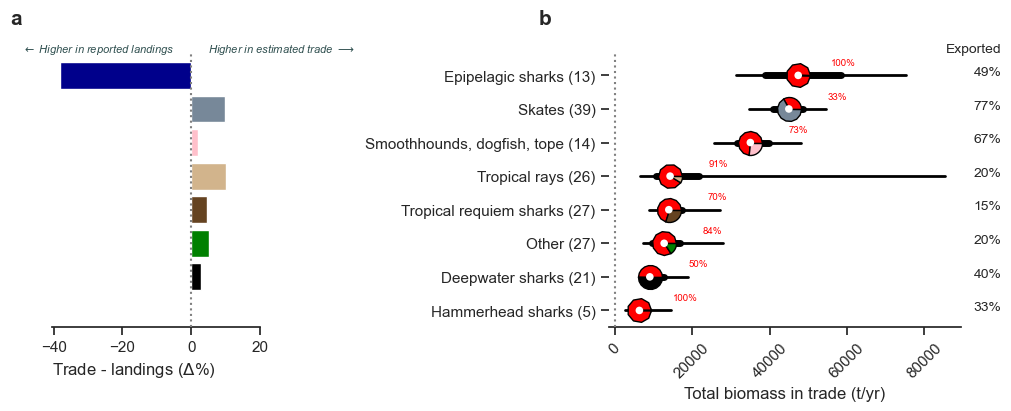

In [136]:
# = = = = = Set up plot
_, ax = plt.subplots(1,2,figsize=(10, 4),width_ratios=(1.3,2.2))

# Set colour pallette
sns.set_style("white")
#sns.set_theme(style="ticks", palette="hls")

# Top location for text
toploc = 7.7

# Barplot of relative change in composition
ax[0].barh(y=np.arange(len(hprops_new)), width=props_diff[::-1]*100, color=[hab_dic[x] for x in plot_order_habitat][::-1],
        )
ax[0].axvline(x=0,color='grey', linestyle=':', zorder=10)
ax[0].set_xlabel('Trade - landings ($\Delta$%)', loc='left')
ax[0].axes.get_yaxis().set_visible(False)
ax[0].spines[['left','right','top']].set_color('none')
#ax[0].set_xlim(-40,80)
ax[0].set_ylim(-.5,toploc)
ax[0].set_xticks((-40,-20,0,20))
# Add text
ax[0].text(-5, toploc, '$\leftarrow$ Higher in reported landings', horizontalalignment='right', fontsize=8, style='italic', c='darkslategrey')
ax[0].text(5, toploc, 'Higher in estimated trade '+'$\longrightarrow$', horizontalalignment='left', fontsize=8, style='italic', c='darkslategrey')


# Add journal letter
letter_annotation(ax[0], -.2, 1.1, 'a', sz=fsz)

# Exporters
ax[1].scatter(x=piedata_H['trade'], y=piedata_H['yloc'], s=30, facecolor='white', edgecolors='none', zorder=11)
ax[1].plot((piedata_H['l90'],piedata_H['u90']), (piedata_H['yloc'],piedata_H['yloc']), c='black', linewidth=2, zorder=9)
ax[1].plot((piedata_H['l50'],piedata_H['u50']), (piedata_H['yloc'],piedata_H['yloc']), c='black', linewidth=5, zorder=9)

for xx,yy,xxr,yyr,c in zip(piedata_H['trade'],
                         piedata_H['yloc'],
                         piedata_H['Threatened_prop'].values,
                         piedata_H['Not_prop'].values-0.001,
                        piedata_H['col'].values):
    drawPieMarker(xs=xx,
                  ys=yy,
                  ratios=[xxr,yyr],
                  sizes=[300],
                  colors=['red', c],
                  #edgecolor='black',
                  ax=ax[1])
tmpx_loc = 100000
[ax[1].text(x+15000,y+0.3,str(np.round(z*100,0).astype(int))+'%',horizontalalignment='right',fontsize=7, color='red') for x,y,z in zip(piedata_H['trade'],piedata_H['yloc'].values, piedata_H['Threatened_prop'].values)]
[ax[1].text(tmpx_loc,y,str(np.round((1-z)*100,0).astype(int))+'%',horizontalalignment='right',fontsize=10) for y,z in zip(piedata_H['yloc'].values, piedata_H['Retained_prop'].values)]
ax[1].text(tmpx_loc,toploc,"Exported", ha='right', fontsize=10)
ax[1].set_yticks(np.arange(len(piedata_H['ylab'])))
ax[1].set_yticklabels(piedata_H.ylab_n.values[match(list(plot_order_habitat),list(piedata_H.ylab),)][::-1])
#[tk.set_visible(True) for tk in ax[1].get_yticklabels()]
ax[1].set_xlabel('Total biomass in trade (t/yr)')
ax[1].set_ylim(-.5,toploc)
#ax[1].set_title('')
#ax[1].legend_.remove()
#legend_elements = [patches.Patch(facecolor='red', label='endangered c.2020')]
#ax[1].legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(1.8, .00))
ax[1].axvline(x=0,color='grey', linestyle=':', zorder=10)
ax[1].tick_params(axis='x', labelrotation=45)
ax[1].spines[['left','right','top']].set_color('none')
# Add journal letter
letter_annotation(ax[1], -.2, 1.1, 'b', sz=fsz)

#plt.tight_layout(pad=0.4)
#ADD NUMBER OF SPECIES>100t IN PARENTHESES NEXT TO GROUP
plt.savefig(bf+'/Global/'+'Exports_vs_Habitat.jpg',dpi=300);

## Plot strong demand scores among top trading nations

In [138]:
spp_demand = trade_spp.sel(importer=trade_cou).sum(('importer')).rename("").assign_coords({"CITES": ("species", CITES)})
listed_exports = spp_exports[:,:,:,spp_exports.CITES=='Listed']
unlisted_exports = spp_exports[:,:,:,spp_exports.CITES!='Listed']
prop_listed_exports = listed_exports.sum('species')/spp_exports.sum('species')

In [139]:
spp_demand = idata_trade_a.posterior['importer_species_effect'].sel(importer=trade_cou)

In [140]:
# Top trading nations species demand scores
demand_spp = []
demand_c = []
for c in trade_cou:
    # Select top 10% of traded species
    tmp = idata_trade_a.posterior['importer_species_effect'].sel(importer=c).mean(('chain'))
    if np.any(tmp.quantile(0.5,dim='draw')>0):
        try:
            spx = tmp.species[tmp.quantile(0.05,dim='draw')>0].values
            demand_spp += list(spx)
            demand_c += [c]*len(spx)
        except:
            pass
demand_spp = np.array(demand_spp).flatten()
demand_c = np.array(demand_c)

In [141]:
# All trading nations species demand scores
demand_spp_A = []
demand_c_A = []
for c in country_:
    # Select top 10% of traded species
    tmp = idata_trade_a.posterior['importer_species_effect'].sel(importer=c).mean(('chain'))
    if np.any(tmp.quantile(0.5,dim='draw')>0):
        try:
            spx = tmp.species[tmp.quantile(0.05,dim='draw')>0].values
            demand_spp_A += list(spx)
            demand_c_A += [c]*len(spx)
        except:
            pass
demand_spp_A = np.array(demand_spp_A).flatten()
demand_c_A = np.array(demand_c_A)

In [142]:
# Grab IUCN for augmented data
IUCN_t = rdata.Rlcategory[match(idata_trade_a.posterior['importer_species_effect'].species,list(rdata.species_))].to_numpy()

# Information prioritization

In [143]:
# Information present for assigning to species in FAO data
IE_obs = -np.log(idata_landings_a.posterior.PsppIdent.sel(species=spp_100))

In [144]:
continent_ = np.array(['Africa', 'Asia', 'South America', 'Oceania',
       'Europe', 'Asia', 'North America', 'South America', 'North America', 'South America',
       'Asia', 'Africa', 'South America', 'North America', 'North America', 'Europe',
       'Europe', 'South America', 'Europe', 'Europe', 'Europe', 'Africa',
       'Europe', 'Asia', 'Oceania', 'Asia', 'Europe',
       'Asia', 'Europe', 'Asia', 'Asia', 'Africa', 'Asia',
       'Africa', 'Africa', 'North America', 'Africa', 'Africa',
       'Asia', 'Africa', 'Africa', 'Europe', 'Europe',
       'Oceania', 'Asia', 'Asia', 'North America', 'South America', 'Asia',
       'Europe', 'Europe', 'Asia', 'Africa', 'Asia',
       'Africa', 'Europe', 'Asia', 'North America',
       'Africa', 'Asia', 'Africa', 'South America',
       'North America', 'South America', 'Asia', 'Oceania', 'Asia', 'Africa'])

In [145]:
# Average information gap per species
mean_IG_spp = IE_obs.where(IE_obs != 0.).mean(('chain','draw','exporter'))

# Average information gap per exporter - calculated for species >0 (i.e. that are present)
mean_IG_ex = IE_obs.where(IE_obs != 0.).mean(('chain','draw','species'), skipna=None)

# Trade object
tmp_trade = idata_trade_a.posterior.amount_exported.mean(('chain','draw'))

# REMOVE DOMESTIC RETENTION
for c in country_a:
    # Remove domestic consumption
    tmp_trade.loc[dict(exporter=c,importer=c)] = 0

# Total biomass in the trade
trade_vol_spp = (tmp_trade.sum(('exporter','importer'))
                 .assign_coords({"IUCN": ("species", IUCN_all)})
                #.assign_coords({"Habitat": ("species", hdata.HabitatGroup[match(species_,list(hdata.species_binomial))].values)})
                 .assign_coords({"Habitat": ("species", hdata.Dulvy_priority.values[match(species_,list(hdata.species_binomial))])})
                 .sel(species=spp_100)
                )
                
# Exporter's volume of trade
trade_vol_ex = tmp_trade.sel(species=spp_100).sum(('species','importer')).assign_coords({"Continent": ("exporter", continent_)})
# Exporter's proportion of trade
trade_vol_prop = trade_vol_ex/sum(trade_vol_ex)

# Total information per country
total_IG_ex = IE_obs.mean(('chain','draw')).sum('species')

# Exporter's volume of trade per species
trade_vol_ex_spp = tmp_trade.sum(('importer')).assign_coords({"Continent": ("exporter", continent_)}).sel(species=spp_100)
# Exporter's proportion of trade per species
tmp = trade_vol_ex_spp.sum('species').values
tmp[tmp==0] = -1
trade_prop_ex_spp = (trade_vol_ex_spp.values/tmp[:,None])

# Weighted information per country over species
mean_IGw_ex = (IE_obs.mean(('chain','draw')).values*trade_prop_ex_spp).sum(1)

# Weighted information per species over country
mean_IGw_spp = (IE_obs.mean(('chain','draw')).values*trade_prop_ex_spp).sum(0)




# Figure 4

/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_46734/2994356882.py:118: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.5)


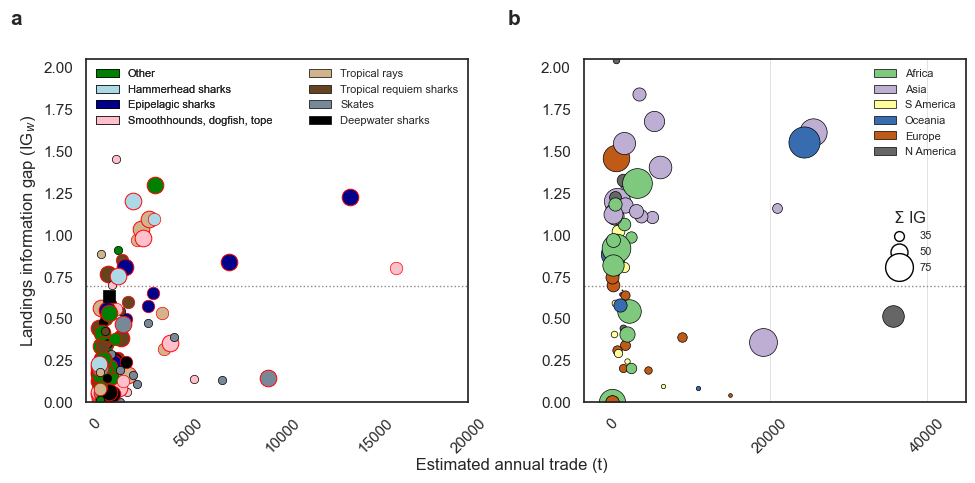

In [146]:
# = = = = = Set up plot
fig, ax = plt.subplots(1,2,figsize=(10, 5))

# Set up plot
sns.set_theme(style="ticks", palette="hls")

# ylimits
miy = 0.
may = 2.05

# legend font size
fsx = 8

# a) Average information gap vs biomass in the trade, coloured by IUCN category
cony = ['DD', 'LC', 'NT', 'VU', 'EN', 'CR']
ccoy = np.array([3,2,2,3,4,4])[match(trade_vol_spp.IUCN,cony)]
ccox = np.array(['black','black','black','red','red','red'])[match(trade_vol_spp.IUCN,cony)]
ccow = np.array([.5,.5,.5,.5,.7,.7])[match(trade_vol_spp.IUCN,cony)]
ccoz = np.array(['s',"o","o","o","o","o"])[match(trade_vol_spp.IUCN,cony)]
#conx = ['Coastal Rays','Coastal Sharks','Deepwater Rays','Deepwater Sharks','Pelagic Rays','Pelagic Sharks']
#colx = ['#d2b48c', '#654321', '#555555','#000000', '#add8e6','#00008b']
conx = hab_ord
colx = hab_col
ccol = np.array(colx)[match(trade_vol_spp.sel(species=spp_100).Habitat,conx)]
cutz = match(spp_100,list(species_))
icol = ccol
[ax[0].scatter(x, y, facecolor=c, s=(3*s)**2, marker=m,
               edgecolor=z,linewidth=w) for x,y,c,s,m,z,w in zip(
                (trade_vol_spp.sel(species=spp_100)), 
                mean_IGw_spp, 
                icol,
                ccoy,
                ccoz,
                ccox,
                ccow
                )]

#legend_elements = [patches.Patch(facecolor='red', label='Endangered c.2020', edgecolor='black', linewidth=0.5)]
sx = 4
legend_elements1 = [patches.Patch(facecolor=c, label=i, edgecolor='black', linewidth=0.5) for i,c in zip(conx[:sx], colx[:sx])]
legend1 = ax[0].legend(handles=legend_elements1, fontsize=fsx, loc='upper right')
ax[0].add_artist(legend1)

legend_elements1b = [patches.Patch(facecolor=c, label=i, edgecolor='black', linewidth=0.5) for i,c in zip(conx[sx:], colx[sx:])]
legend1b = ax[0].legend(handles=legend_elements1b, fontsize=fsx, loc='upper left')
ax[0].add_artist(legend1b)



#ax[0].legend()
ax[0].set_xlabel('')
ax[0].set_ylabel('Landings information gap (IG$_{w}$)')
ax[0].set(
    #xscale="log", 
    xlim=(-500, 20000),
    ylim=(miy, may)
)
ax[0].xaxis.grid(True, "minor", linewidth=.5)
ax[0].yaxis.grid(False)
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)
#ax[0].axvline(x=10000, color='#88888855', zorder=0, linewidth=.5)
ax[0].axhline(y=-np.log(0.5), color='#888888', zorder=0, linewidth=1, linestyle=":")
# Add journal letter
letter_annotation(ax[0], -.2, 1.1, 'a', sz=fsz)

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = #
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = #


# b) Average information gap per species vs total weighted information gap per country, shapes/colours by continent
conx = ['Africa', 'Asia', 'S America', 'Oceania', 'Europe','N America']
colx = mp.colormaps['Accent'].resampled(len(conx))
ccol = colx(match(trade_vol_ex.Continent.values,['Africa', 'Asia', 'South America', 'Oceania', 'Europe','North America']))
[ax[1].scatter(x,y,color=c, s=(s/10)**3, edgecolor='black', linewidth=0.5) for x,y,s,c in zip(trade_vol_ex, mean_IGw_ex, total_IG_ex, ccol)]
legend_elements1 = [patches.Patch(facecolor=c, label=i, edgecolor='black', linewidth=0.5) for i,c in zip(conx, colx(np.arange(len(conx))))]
legend1 = ax[1].legend(handles=legend_elements1, fontsize=fsx)
ax[1].add_artist(legend1)

gll = plt.scatter([],[], s=5, marker='o', color='white', edgecolor='black')
gl = plt.scatter([],[], s=50, marker='o', color='white', edgecolor='black')
ga = plt.scatter([],[], s=150, marker='o', color='white', edgecolor='black')
gk = plt.scatter([],[], s=400, marker='o', color='white', edgecolor='black')

ax[1].legend((gl,ga,gk),
       ('35', '50','75'),
       scatterpoints=1,
       loc='lower left',
       ncol=1,
       fontsize=fsx,
        title='$\Sigma$ IG',
        bbox_to_anchor=(.77, .35))


ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set(
    #xscale="log", 
    xlim=(None, 45000),
    ylim=(miy, may)
)
ax[1].xaxis.grid(True, "minor", linewidth=.5)
for tick in ax[1].get_xticklabels():
    tick.set_rotation(45)
ax[1].set_xticks((0, 20000, 40000))
#ax[1].axes.get_yaxis().set_visible(False)
ax[1].axvline(x=20000, color='#88888855', zorder=0, linewidth=.5)
ax[1].axvline(x=40000, color='#88888855', zorder=0, linewidth=.5)
#ax[1].axvline(x=60000, color='#88888855', zorder=0, linewidth=.5)
#ax[1].axvline(x=80000, color='#88888855', zorder=0, linewidth=.5)

ax[1].axhline(y=-np.log(0.5), color='#888888', zorder=0, linewidth=1, linestyle=":")
# Add journal letter
letter_annotation(ax[1], -.2, 1.1, 'b', sz=fsz)

# Set common labels
fig.text(.5, 0.03, '         Estimated annual trade (t)', ha='center', va='center')
plt.tight_layout(pad=1.5)
plt.savefig(bf+'/Global/'+'Information_gaps.jpg',dpi=300);

In [147]:
# Silky numbers x
trade_vol_spp.sel(species=spp_100)[spp_100=='Carcharhinus falciformis'].values

array([15970.6498921])

In [148]:
# Silky numbers y
mean_IGw_spp[spp_100=='Carcharhinus falciformis']

array([3.17350581])

In [149]:
trade_vol_ex.sel(exporter='ESP')

<xarray.DataArray 'amount_exported' ()>
array(72521.87320101)
Coordinates:
    exporter   <U3 'ESP'
    Exporter   object 'Spain'
    Continent  <U13 'Europe'

In [150]:
total_IG_ex.sel(exporter='ESP')

<xarray.DataArray 'PsppIdent' ()>
array(76.69370404)
Coordinates:
    exporter  <U3 'ESP'
    Exporter  object 'Spain'

In [151]:
mean_IGw_ex[country_a=='ESP']

array([0.13463131])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_46734/3202567278.py:62: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.5)


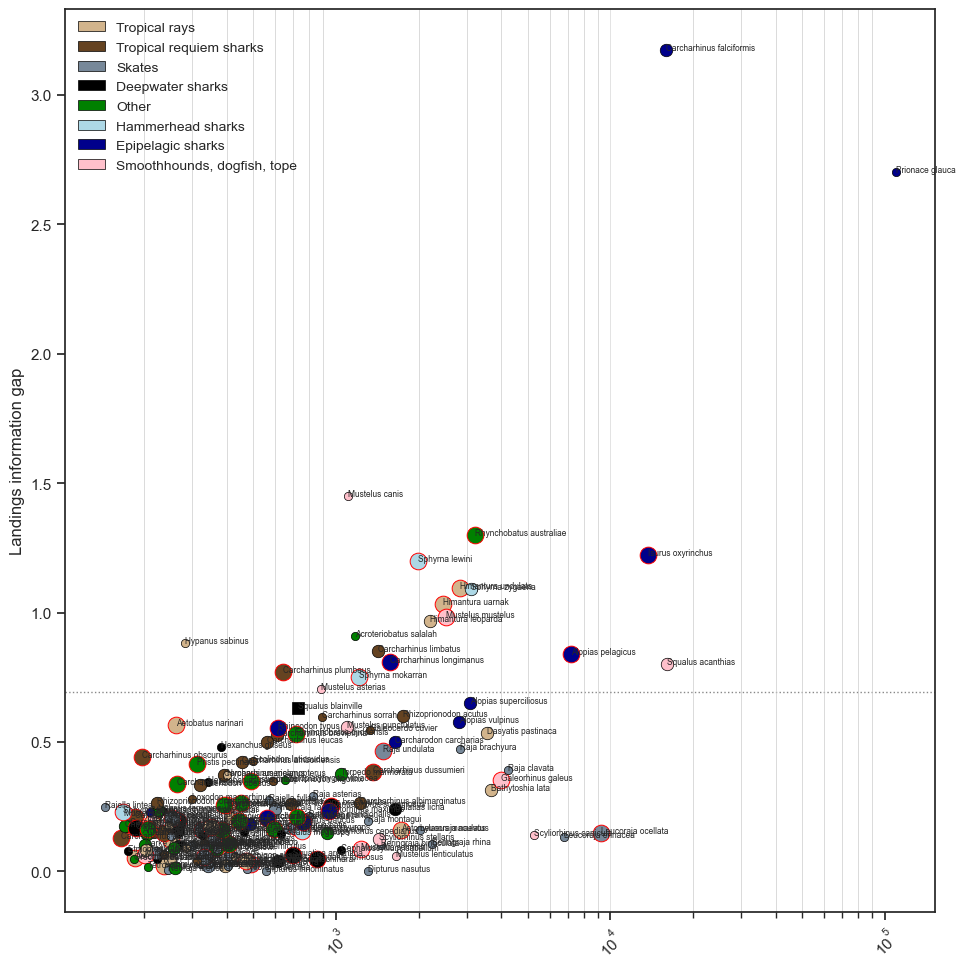

In [152]:
# = = = = = Set up plot
_, ax = plt.subplots(1,1,figsize=(10, 10))

# Set up plot
sns.set_theme(style="ticks", palette="hls")

miy = 0.15
may = 1.4

# a) Average information gap vs biomass in the trade, coloured by dulvy groups
cony = ['DD', 'LC', 'NT', 'VU', 'EN', 'CR']
ccoy = np.array([3,2,2,3,4,4])[match(trade_vol_spp.IUCN,cony)]
ccox = np.array(['black','black','black','black','red','red'])[match(trade_vol_spp.IUCN,cony)]
ccow = np.array([.5,.5,.5,.5,.7,.7])[match(trade_vol_spp.IUCN,cony)]
ccoz = np.array(['s',"o","o","o","o","o"])[match(trade_vol_spp.IUCN,cony)]
#conx = ['Coastal Rays','Coastal Sharks','Deepwater Rays','Deepwater Sharks','Pelagic Rays','Pelagic Sharks']
#colx = ['#d2b48c', '#654321', '#555555','#000000', '#add8e6','#00008b']
conx = hab_ord
colx = hab_col
ccol = np.array(colx)[match(trade_vol_spp.sel(species=spp_100).Habitat,conx)]
cutz = match(spp_100,list(species_))
icol = ccol
[ax.scatter(x, y, facecolor=c, s=(3*s)**2, marker=m,
               edgecolor=z,linewidth=w) for x,y,c,s,m,z,w in zip(
                (trade_vol_spp.sel(species=spp_100)), 
                mean_IGw_spp, 
                icol,
                ccoy,
                ccoz,
                ccox,
                ccow
                )]
[ax.text(x, y, t, fontsize=6) for x,y,t in zip(
                trade_vol_spp.sel(species=spp_100), 
                mean_IGw_spp, 
                spp_100
                )]

#legend_elements = [patches.Patch(facecolor='red', label='Endangered c.2020', edgecolor='black', linewidth=0.5)]
legend_elements1 = [patches.Patch(facecolor=c, label=i, edgecolor='black', linewidth=0.5) for i,c in zip(conx, colx)]
legend1 = ax.legend(handles=legend_elements1, fontsize=10)
ax.add_artist(legend1)
ax.legend(fontsize=10)
ax.set_xlabel('')
ax.set_ylabel('Landings information gap')
ax.set(
    xscale="log", 
    #xlim=(1000, 20000),
    #ylim=(miy, may)
)
ax.xaxis.grid(True, "minor", linewidth=.5)
ax.yaxis.grid(False)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.axvline(x=10000, color='#88888855', zorder=0, linewidth=.5)
ax.axhline(y=-np.log(0.5), color='#888888', zorder=0, linewidth=1, linestyle=":")



# Set common labels
fig.text(.5, 0.04, '         Estimated trade (t)', ha='center', va='center')
plt.tight_layout(pad=1.5)
plt.savefig(bf+'/Global/'+'Information_gaps_spp_labels.jpg',dpi=300);

In [153]:
trade_vol_spp.sel(species='Carcharhinus falciformis'), mean_IGw_spp[spp_100=='Carcharhinus falciformis']

(<xarray.DataArray 'amount_exported' ()>
 array(15970.6498921)
 Coordinates:
     species  <U33 'Carcharhinus falciformis'
     IUCN     object 'VU'
     Habitat  object 'Epipelagic sharks',
 array([3.17350581]))

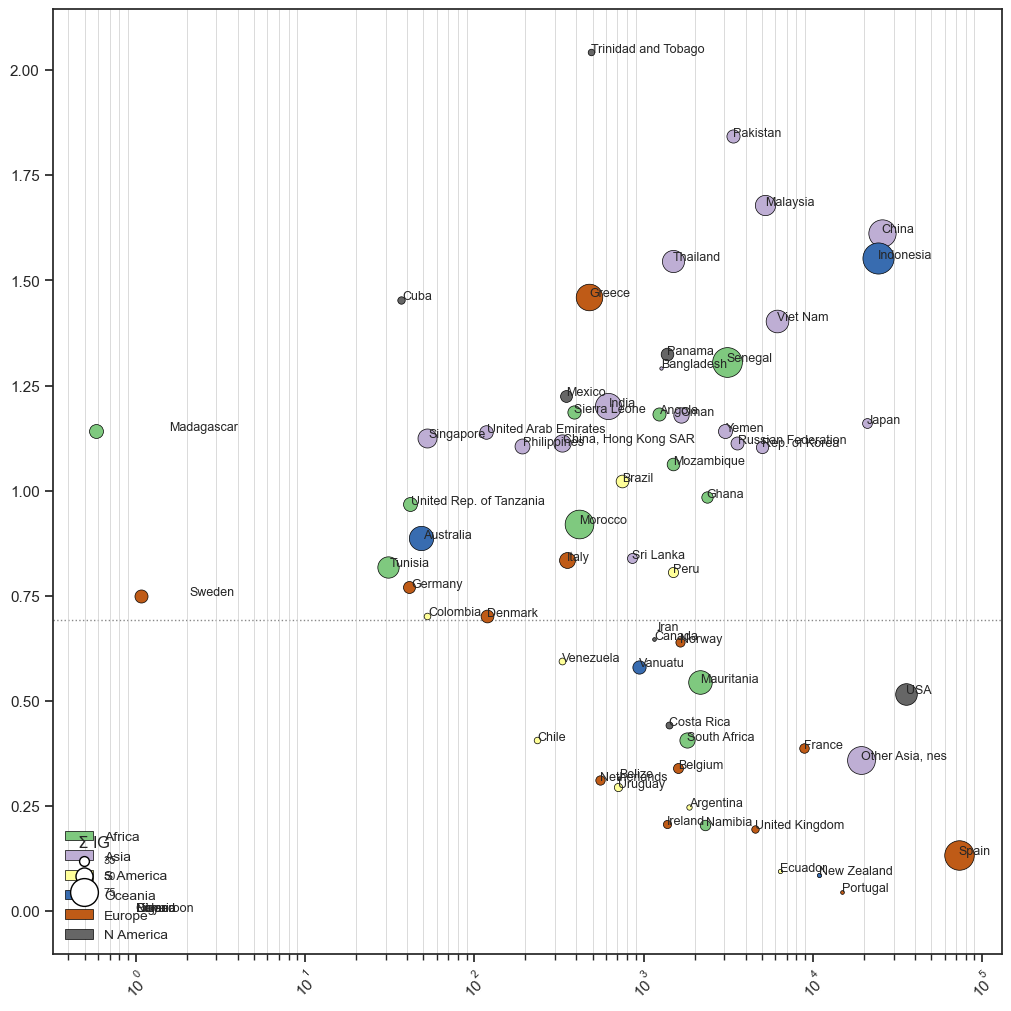

In [154]:
# = = = = = Set up plot
_, ax = plt.subplots(1,1,figsize=(10, 10))

# b) Average information gap per species vs total weighted information gap per country, shapes/colours by continent
conx = ['Africa', 'Asia', 'S America', 'Oceania', 'Europe','N America']
colx = mp.colormaps['Accent'].resampled(len(conx))
ccol = colx(match(trade_vol_ex.Continent.values,['Africa', 'Asia', 'South America', 'Oceania', 'Europe','North America']))
[ax.scatter(x,y,color=c, s=(s/10)**3, edgecolor='black', linewidth=0.5) for x,y,s,c in zip(trade_vol_ex, mean_IGw_ex, total_IG_ex, ccol)]
[ax.text(x+1,s, t, fontsize=9) for x,s,t in zip(trade_vol_ex, mean_IGw_ex, biggest_countries_long_a)]

legend_elements1 = [patches.Patch(facecolor=c, label=i, edgecolor='black', linewidth=0.5) for i,c in zip(conx, colx(np.arange(len(conx))))]
legend1 = ax.legend(handles=legend_elements1, fontsize=10, loc='lower left')
ax.add_artist(legend1)

gll = plt.scatter([],[], s=5, marker='o', color='white', edgecolor='black')
gl = plt.scatter([],[], s=50, marker='o', color='white', edgecolor='black')
ga = plt.scatter([],[], s=150, marker='o', color='white', edgecolor='black')
gk = plt.scatter([],[], s=400, marker='o', color='white', edgecolor='black')

ax.legend((gl,ga,gk),
       ('35', '50','75'),
       scatterpoints=1,
       loc='lower left',
       ncol=1,
       fontsize=8,
        title='$\Sigma$ IG',
        bbox_to_anchor=(.01, .05))


ax.set_xlabel('')
ax.set_ylabel('')
ax.set(
    xscale="log", 
    #xlim=(1000, None),
    #ylim=(miy, may)
)
ax.xaxis.grid(True, "minor", linewidth=.5)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
#ax.axes.get_yaxis().set_visible(False)
ax.axhline(y=-np.log(0.5), color='#888888', zorder=0, linewidth=1, linestyle=":")



/var/folders/0t/qrl_lm21285bvxnv0dg58ycm0000gn/T/ipykernel_46734/3294094414.py:119: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.5)


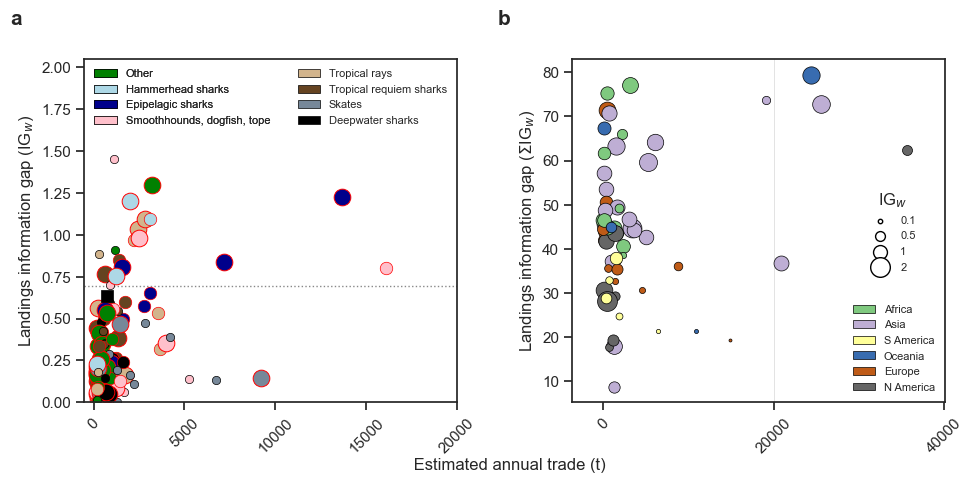

In [155]:
# = = = = = Set up plot
fig, ax = plt.subplots(1,2,figsize=(10, 5))

# Set up plot
sns.set_theme(style="ticks", palette="hls")

# ylimits
miy = 0.
may = 2.05

# legend font size
fsx = 8

# a) Average information gap vs biomass in the trade, coloured by IUCN category
cony = ['DD', 'LC', 'NT', 'VU', 'EN', 'CR']
ccoy = np.array([3,2,2,3,4,4])[match(trade_vol_spp.IUCN,cony)]
ccox = np.array(['black','black','black','red','red','red'])[match(trade_vol_spp.IUCN,cony)]
ccow = np.array([.5,.5,.5,.5,.7,.7])[match(trade_vol_spp.IUCN,cony)]
ccoz = np.array(['s',"o","o","o","o","o"])[match(trade_vol_spp.IUCN,cony)]
#conx = ['Coastal Rays','Coastal Sharks','Deepwater Rays','Deepwater Sharks','Pelagic Rays','Pelagic Sharks']
#colx = ['#d2b48c', '#654321', '#555555','#000000', '#add8e6','#00008b']
conx = hab_ord
colx = hab_col
ccol = np.array(colx)[match(trade_vol_spp.sel(species=spp_100).Habitat,conx)]
cutz = match(spp_100,list(species_))
icol = ccol
[ax[0].scatter(x, y, facecolor=c, s=(3*s)**2, marker=m,
               edgecolor=z,linewidth=w) for x,y,c,s,m,z,w in zip(
                (trade_vol_spp.sel(species=spp_100)), 
                mean_IGw_spp, 
                icol,
                ccoy,
                ccoz,
                ccox,
                ccow
                )]

#legend_elements = [patches.Patch(facecolor='red', label='Endangered c.2020', edgecolor='black', linewidth=0.5)]
sx = 4
legend_elements1 = [patches.Patch(facecolor=c, label=i, edgecolor='black', linewidth=0.5) for i,c in zip(conx[:sx], colx[:sx])]
legend1 = ax[0].legend(handles=legend_elements1, fontsize=fsx, loc='upper right')
ax[0].add_artist(legend1)

legend_elements1b = [patches.Patch(facecolor=c, label=i, edgecolor='black', linewidth=0.5) for i,c in zip(conx[sx:], colx[sx:])]
legend1b = ax[0].legend(handles=legend_elements1b, fontsize=fsx, loc='upper left')
ax[0].add_artist(legend1b)



#ax[0].legend()
ax[0].set_xlabel('')
ax[0].set_ylabel('Landings information gap (IG$_{w}$)')
ax[0].set(
    #xscale="log", 
    xlim=(-500, 20000),
    ylim=(miy, may)
)
ax[0].xaxis.grid(True, "minor", linewidth=.5)
ax[0].yaxis.grid(False)
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)
#ax[0].axvline(x=10000, color='#88888855', zorder=0, linewidth=.5)
ax[0].axhline(y=-np.log(0.5), color='#888888', zorder=0, linewidth=1, linestyle=":")
# Add journal letter
letter_annotation(ax[0], -.2, 1.1, 'a', sz=fsz)

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = #
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = #


# b) Average information gap per species vs total weighted information gap per country, shapes/colours by continent
conx = ['Africa', 'Asia', 'S America', 'Oceania', 'Europe','N America']
colx = mp.colormaps['Accent'].resampled(len(conx))
ccol = colx(match(trade_vol_ex.Continent.values,['Africa', 'Asia', 'South America', 'Oceania', 'Europe','North America']))
[ax[1].scatter(x,s,color=c, s=100*y, edgecolor='black', linewidth=0.5) for x,y,s,c in zip(trade_vol_ex, mean_IGw_ex, total_IG_ex, ccol)]
legend_elements1 = [patches.Patch(facecolor=c, label=i, edgecolor='black', linewidth=0.5) for i,c in zip(conx, colx(np.arange(len(conx))))]
legend1 = ax[1].legend(handles=legend_elements1, fontsize=fsx)
ax[1].add_artist(legend1)

gl = plt.scatter([],[], s=10, marker='o', color='white', edgecolor='black')
glx = plt.scatter([],[], s=50, marker='o', color='white', edgecolor='black')
ga = plt.scatter([],[], s=100, marker='o', color='white', edgecolor='black')
gk = plt.scatter([],[], s=200, marker='o', color='white', edgecolor='black')

ax[1].legend((gl,glx,ga,gk),
       ('0.1','0.5', '1','2'),
       scatterpoints=1,
       loc='lower left',
       ncol=1,
       fontsize=fsx,
        title='IG$_{w}$',
        bbox_to_anchor=(.77, .35))


ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set(
    #xscale="log", 
    xlim=(None, 40100),
    #ylim=(miy, may)
)
ax[1].set_ylabel('Landings information gap ($\Sigma$IG$_{w}$)')
ax[1].xaxis.grid(True, "minor", linewidth=.5)
for tick in ax[1].get_xticklabels():
    tick.set_rotation(45)
ax[1].set_xticks((0, 20000, 40000))
#ax[1].axes.get_yaxis().set_visible(False)
ax[1].axvline(x=20000, color='#88888855', zorder=0, linewidth=.5)
ax[1].axvline(x=40000, color='#88888855', zorder=0, linewidth=.5)
#ax[1].axvline(x=60000, color='#88888855', zorder=0, linewidth=.5)
#ax[1].axvline(x=80000, color='#88888855', zorder=0, linewidth=.5)

#ax[1].axhline(y=-np.log(0.5), color='#888888', zorder=0, linewidth=1, linestyle=":")
# Add journal letter
letter_annotation(ax[1], -.2, 1.1, 'b', sz=fsz)

# Set common labels
fig.text(.5, 0.03, '         Estimated annual trade (t)', ha='center', va='center')
plt.tight_layout(pad=1.5)
plt.savefig(bf+'/Global/'+'Information_gaps.jpg',dpi=300);

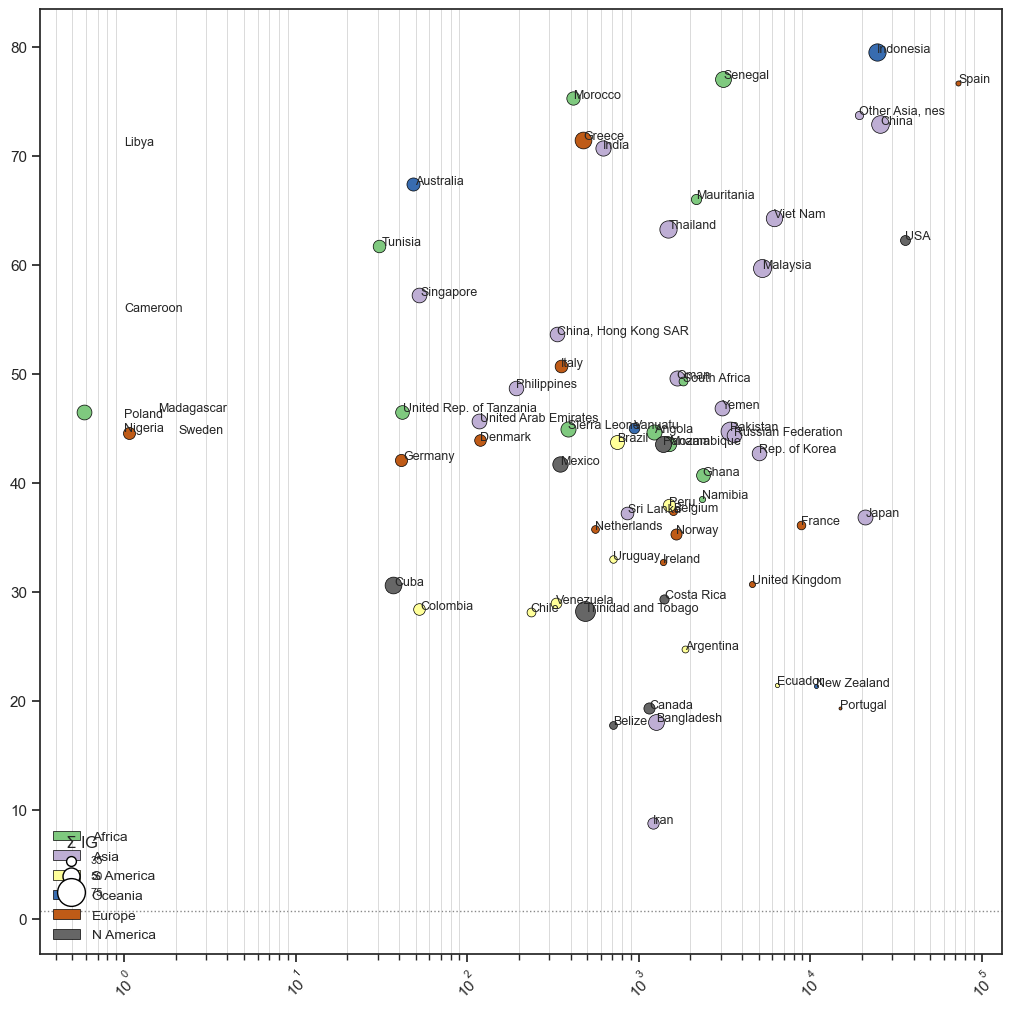

In [156]:
# = = = = = Set up plot
_, ax = plt.subplots(1,1,figsize=(10, 10))

# b) Average information gap per species vs total weighted information gap per country, shapes/colours by continent
conx = ['Africa', 'Asia', 'S America', 'Oceania', 'Europe','N America']
colx = mp.colormaps['Accent'].resampled(len(conx))
ccol = colx(match(trade_vol_ex.Continent.values,['Africa', 'Asia', 'South America', 'Oceania', 'Europe','North America']))
[ax.scatter(x,s,color=c, s=100*y, edgecolor='black', linewidth=0.5) for x,y,s,c in zip(trade_vol_ex, mean_IGw_ex, total_IG_ex, ccol)]
[ax.text(x+1,s, t, fontsize=9) for x,s,t in zip(trade_vol_ex, total_IG_ex, biggest_countries_long_a)]

legend_elements1 = [patches.Patch(facecolor=c, label=i, edgecolor='black', linewidth=0.5) for i,c in zip(conx, colx(np.arange(len(conx))))]
legend1 = ax.legend(handles=legend_elements1, fontsize=10, loc='lower left')
ax.add_artist(legend1)

gll = plt.scatter([],[], s=5, marker='o', color='white', edgecolor='black')
gl = plt.scatter([],[], s=50, marker='o', color='white', edgecolor='black')
ga = plt.scatter([],[], s=150, marker='o', color='white', edgecolor='black')
gk = plt.scatter([],[], s=400, marker='o', color='white', edgecolor='black')

ax.legend((gl,ga,gk),
       ('35', '50','75'),
       scatterpoints=1,
       loc='lower left',
       ncol=1,
       fontsize=8,
        title='$\Sigma$ IG',
        bbox_to_anchor=(.01, .05))


ax.set_xlabel('')
ax.set_ylabel('')
ax.set(
    xscale="log", 
    #xlim=(1000, None),
    #ylim=(miy, may)
)
ax.xaxis.grid(True, "minor", linewidth=.5)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
#ax.axes.get_yaxis().set_visible(False)
ax.axhline(y=-np.log(0.5), color='#888888', zorder=0, linewidth=1, linestyle=":")



# IUCN NUMBERS

In [157]:
# Import species by habitat
xxdata = pd.read_excel(bd+'Upcoming_Red_List_species_June2024.xlsx')

In [158]:
xxdata.head(3)

Family         Scientific name          Common name RL Category  \
0     SQUATINIDAE    Squatina californica  Pacific Angel Shark          NT   
1  HETERODONTIDAE  Heterodontus francisci           Horn Shark          DD   
2    PENTANCHIDAE     Apristurus brunneus       Brown Catshark          DD   

   RL Year  
0     2014  
1     2014  
2     2014

In [159]:
tmp_iucn_spp = xxdata['Scientific name'].values
tmp_iucn_spp

array(['Squatina californica', 'Heterodontus francisci',
       'Apristurus brunneus', 'Apristurus kampae',
       'Apristurus spongiceps', 'Parmaturus xaniurus',
       'Mustelus californicus', 'Mustelus henlei', 'Triakis semifasciata',
       'Pseudobatos productus', 'Bathyraja mariposa',
       'Bathyraja panthera', 'Bathyraja spinosissima',
       'Beringraja binoculata', 'Beringraja inornata',
       'Beringraja stellulata', 'Neoraja caerulea', 'Neoraja iberica',
       'Raja maderensis', 'Myliobatis californicus', 'Urobatis halleri'],
      dtype=object)

In [160]:
tmp_iucn_spp = tmp_iucn_spp[match(tmp_iucn_spp,list(species_))!=None]

In [161]:
# Select top 10% of  species
tmp_trad = (idata_trade_a.posterior['amount_exported'].sel(species=tmp_iucn_spp)
            .sum(('exporter','importer')).quantile((0.5,0.05,0.95),('chain','draw'))
           .to_dataframe().reset_index()
            .pivot(columns=['quantile'],values='amount_exported',index='species').reset_index()
            .to_csv('tmp_iucn_trade.csv')
           )

In [162]:
tmp_land = (idata_landings_a.posterior['Latent_landings'].sel(species=tmp_iucn_spp).sum(('exporter'))
             .quantile((0.5,0.05,0.95),('chain','draw'))
             .to_dataframe().reset_index()
            .pivot(columns=['quantile'],values='Latent_landings',index='species').reset_index()
            #.to_csv('tmp_iucn_landings.csv')
           )
tmp_land.to_csv('tmp_iucn_landings.csv')

In [163]:
idata_landings_a.posterior['Latent_landings'].sel(species='Apristurus spongiceps').mean(('chain','draw')).to_dataframe().reset_index().sort_values(by='Latent_landings',ascending=False)

exporter                species   Exporter  Latent_landings
17      ECU  Apristurus spongiceps    Ecuador     2.408827e+01
25      IND  Apristurus spongiceps      India     1.553824e-01
24      IDN  Apristurus spongiceps  Indonesia     2.298554e-02
27      IRN  Apristurus spongiceps       Iran     7.559498e-03
62      USA  Apristurus spongiceps        USA     4.738514e-03
..      ...                    ...        ...              ...
12      COL  Apristurus spongiceps   Colombia     3.355716e-05
53      SGP  Apristurus spongiceps  Singapore     5.270490e-06
15      DEU  Apristurus spongiceps    Germany     4.602645e-06
49      POL  Apristurus spongiceps     Poland     1.609250e-06
55      SWE  Apristurus spongiceps     Sweden     1.491235e-07

[68 rows x 4 columns]

In [164]:
idata_landings_a.posterior['Latent_landings'].sel(species='Heterodontus francisci').mean(('chain','draw')).to_dataframe().reset_index().sort_values(by='Latent_landings',ascending=False)

exporter                 species   Exporter  Latent_landings
35      MEX  Heterodontus francisci     Mexico     5.192175e+02
62      USA  Heterodontus francisci        USA     1.276525e+00
25      IND  Heterodontus francisci      India     1.553824e-01
24      IDN  Heterodontus francisci  Indonesia     2.298554e-02
27      IRN  Heterodontus francisci       Iran     7.559498e-03
..      ...                     ...        ...              ...
12      COL  Heterodontus francisci   Colombia     3.355716e-05
53      SGP  Heterodontus francisci  Singapore     5.270490e-06
15      DEU  Heterodontus francisci    Germany     4.602645e-06
49      POL  Heterodontus francisci     Poland     1.609250e-06
55      SWE  Heterodontus francisci     Sweden     1.491235e-07

[68 rows x 4 columns]

In [165]:
tmp_land

quantile                  species        0.05          0.5         0.95
0             Apristurus brunneus   13.965219    57.765541   447.591609
1               Apristurus kampae    1.664788    11.665747    94.127805
2           Apristurus spongiceps    1.180066     9.714207    95.669671
3          Bathyraja spinosissima   42.650330   254.991942  1836.382519
4           Beringraja binoculata  113.722063  1070.095365  9675.270426
5             Beringraja inornata   27.129102   209.681492  1933.285148
6          Heterodontus francisci   16.630809   199.219152  2047.188484
7           Mustelus californicus   30.416372   265.286498  1810.559924
8                 Mustelus henlei  162.938941   690.050787  5571.984146
9         Myliobatis californicus   22.917044   241.079623  1915.497016
10               Neoraja caerulea   21.518622   187.430730  2448.788295
11                Neoraja iberica   20.606147   179.490163  2044.409593
12          Pseudobatos productus   48.439361   329.716247  1809.581607
13           Squatina californica  902.326989  1526.881494  5798.430219
14           Triakis semifasciata   24.445963   205.389254  2073.956327
15               Urobatis halleri   35.317595   231.208010  2129.391533

## Inf-doc notes

Senegal (SN);
Oman (OM); Yemen (YE
Sri Lanka (LK)*
Mexico (MX); Indonesia (ID);
China (CN);
Oman (OM);
Sri Lanka (LK); Yemen (YE)
Mexico (MX)


Carcharhinus longimanus
Mobula spp.
Sphyrna lewini



In [166]:
def CITES24(sppx,expx):
    tmp_land = (
        idata_landings_a.posterior['Latent_landings']
        .sel(species=sppx,exporter=expx)
        .quantile((0.5,0.05,0.95),('chain','draw'))
        .to_dataframe().reset_index()
        .sort_values(by='Latent_landings',ascending=False)
        .pivot_table(columns=['quantile'],index=['Exporter'],values='Latent_landings')
        .reset_index()
    )
    tmp_land.columns = [sppx,'l90% UI landings', 'Median landings', 'u90% UI landings']
    tmp_trade = (
            trade_spp
            .sel(species=sppx,exporter=expx)
            .sum(['importer'])
            .quantile((0.5,0.05,0.95),('chain','draw'))
            .to_dataframe().reset_index()
            .sort_values(by='',ascending=False)
            .pivot_table(columns=['quantile'],index=['Exporter'],values='')
            .reset_index()
        )
    tmp_trade.columns = [sppx,'l90% UI trade', 'Median trade', 'u90% UI trade']
    return tmp_land.merge(tmp_trade)

def CITES24_all(sppx):
    tmp_land = (
        idata_landings_a.posterior['Latent_landings']
        .sel(species=sppx)
        .quantile((0.5,0.05,0.95),('chain','draw'))
        .to_dataframe().reset_index()
        .sort_values(by='Latent_landings',ascending=False)
        .pivot_table(columns=['quantile'],index=['Exporter'],values='Latent_landings')
        .reset_index()
    )
    tmp_land.columns = [sppx,'l90% UI landings', 'Median landings', 'u90% UI landings']
    tmp_trade = (
            trade_spp
            .sel(species=sppx)
            .sum(['importer'])
            .quantile((0.5,0.05,0.95),('chain','draw'))
            .to_dataframe().reset_index()
            .sort_values(by='',ascending=False)
            .pivot_table(columns=['quantile'],index=['Exporter'],values='')
            .reset_index()
        )
    tmp_trade.columns = [sppx,'l90% UI trade', 'Median trade', 'u90% UI trade']
    return tmp_land.merge(tmp_trade)

In [167]:
# Grab species
tmp_num = CITES24('Carcharhinus longimanus',['SEN','OMN','YEM'])
# Global estimated trade - excluding domestic
tmp_ex = (trade_spp
            .sel(species=tmp_num.columns[0])
            .sum(['importer','exporter'])
            .quantile((0.5,0.05,0.95),('chain','draw'))).to_dataframe().T
tmp_num['perc_global'] = tmp_num['Median trade']/np.array(tmp_ex[0.50])*100
tmp_num

Carcharhinus longimanus  l90% UI landings  Median landings  \
0                    Oman          3.698798        40.856333   
1                 Senegal          1.480299        16.123196   
2                   Yemen          3.801664        51.562461   

   u90% UI landings  l90% UI trade  Median trade  u90% UI trade  perc_global  
0        399.146305       0.018738      5.418895     129.924676     0.495983  
1        125.379082       0.036376      2.921336      77.484068     0.267385  
2        636.638316       0.004774     10.001415     402.803205     0.915413

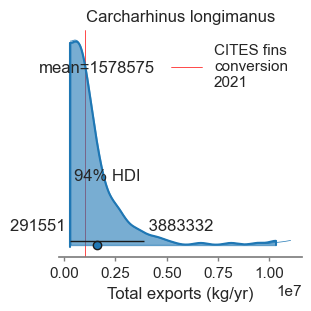

In [168]:
fig, ax = plt.subplots(1, 1,figsize=(3,3))
tmpSpp = tmp_num.columns[0]
xxtmp = trade_spp.sel(species=tmpSpp).sum(('exporter','importer'))*1000
az.plot_density(xxtmp, colors='#1f77b4', ax=ax, shade=0.6, hdi_prob=0.99)
az.plot_posterior(xxtmp, color='#1f77b4',ax=ax, linewidth=.5, )
ax.axvline(x=1027864, color='red', zorder=0, linewidth=.5, label='CITES fins\nconversion\n2021')
plt.legend()
plt.title(tmpSpp)
plt.xlabel('Total exports (kg/yr)')
plt.savefig(bf+'/Species/'+tmpSpp.replace(" ", "_")+'total_trade.jpg',dpi=300);

In [169]:
(trade_spp.sel(species=tmpSpp).sum(('exporter','importer'))).quantile((0.5,0.01,0.945),('chain','draw')).to_dataframe().T

quantile        0.500       0.010        0.945
          1092.557054  331.042538  3888.504406

In [170]:
(trade_spp.sel(species=tmpSpp).sum(('exporter','importer'))).mean()

<xarray.DataArray '' ()>
array(1578.57461751)
Coordinates:
    species  <U33 'Carcharhinus longimanus'
    Group    object 'sharks'

In [171]:
# Reported landings
sdata[sdata.species==tmp_num.columns[0]].groupby('year').sum().Reported_species_landings.mean()*1000

259250.0

In [172]:
# Grab species
tmp_num = CITES24_all('Carcharhinus longimanus')
# Global estimated trade - excluding domestic
tmp_ex = (trade_spp
            .sel(species=tmp_num.columns[0])
            .sum(['importer','exporter'])
            .quantile((0.5,0.03,0.97),('chain','draw'))).to_dataframe().T
tmp_num['perc_global'] = (tmp_num['Median trade']/np.array(tmp_ex[0.50]))*100
tmp_num

Carcharhinus longimanus  l90% UI landings  Median landings  \
0                   Angola          1.444393        20.649282   
1                Argentina          0.323694         3.029939   
2                Australia          0.000642         0.006870   
3               Bangladesh          0.001297         0.003386   
4                  Belgium          0.407385         3.504832   
..                     ...               ...              ...   
63                 Uruguay          0.228423         2.395987   
64                 Vanuatu          2.973097        13.697269   
65               Venezuela          1.421140        13.487501   
66                Viet Nam          0.000117         0.000422   
67                   Yemen          3.801664        51.562461   

    u90% UI landings  l90% UI trade  Median trade  u90% UI trade   perc_global  
0         239.040851   4.140383e-04      4.485793     186.834519  4.105775e-01  
1          34.718763   1.803251e-02      0.410338      10.356446  3.755759e-02  
2           0.083632   7.996064e-09      0.000006       0.003326  5.236691e-07  
3           0.007283   7.100378e-09      0.000044       0.003178  3.986586e-06  
4          31.804160   5.068701e-02      2.246892      24.001901  2.056544e-01  
..               ...            ...           ...            ...           ...  
63         21.053504   1.431389e-02      1.684330      12.582887  1.541641e-01  
64         63.501004   1.211313e-01      7.852610      51.091569  7.187369e-01  
65        107.771450   4.548934e-06      0.030226      15.504717  2.766556e-03  
66          0.001034   7.574638e-05      0.000599       0.001286  5.484648e-05  
67        636.638316   4.774464e-03     10.001415     402.803205  9.154135e-01  

[68 rows x 8 columns]

In [173]:
tmp_num['Median trade'].sum(),tmp_num['perc_global'].sum()

(356.5485056142206, 32.634314547370245)

In [174]:
tmp_ex

quantile         0.50        0.03         0.97
          1092.557054  409.815779  4779.893421

In [175]:
tmp_num = CITES24('Sphyrna lewini',['MEX','IDN','CHN','OMN','LKA','YEM'])
# Global estimated trade - excluding domestic
tmp_ex = (trade_spp
            .sel(species=tmp_num.columns[0])
            .sum(['importer','exporter'])
            .quantile((0.5,0.05,0.95),('chain','draw'))).to_dataframe().T
tmp_num['perc_global'] = tmp_num['Median trade']/np.array(tmp_ex[0.50])*100
tmp_num

Sphyrna lewini  l90% UI landings  Median landings  u90% UI landings  \
0          China          2.424700        31.881796        431.301241   
1      Indonesia         98.782832      1125.102700       5637.028125   
2         Mexico         18.256359       277.682361       1977.483474   
3           Oman          3.293902        42.213318        490.018413   
4      Sri Lanka         12.042299        64.104501        229.596552   
5          Yemen          3.978297        49.988448        647.951377   

   l90% UI trade  Median trade  u90% UI trade  perc_global  
0       0.404802     28.649934     321.551907     1.938893  
1       0.058828     45.393174    1996.933115     3.071997  
2       0.000109      0.117508      28.719933     0.007952  
3       0.011950      5.130357     164.514481     0.347199  
4       0.000077      0.139698      44.074528     0.009454  
5       0.006118     12.299062     197.807337     0.832343

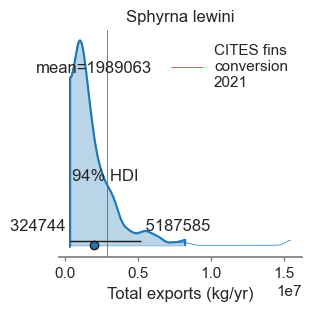

In [176]:
fig, ax = plt.subplots(1, 1,figsize=(3,3))
tmpSpp = tmp_num.columns[0]
xxtmp = trade_spp.sel(species=tmpSpp).sum(('exporter','importer'))*1000
az.plot_density(xxtmp, colors='#1f77b4', ax=ax, shade=0.3, hdi_prob=0.99)
az.plot_posterior(xxtmp, color='#1f77b4',ax=ax, linewidth=.5,)
ax.axvline(x=2885325, color='red', zorder=0, linewidth=.5, label='CITES fins\nconversion\n2021')
plt.legend()
plt.title(tmpSpp)
plt.xlabel('Total exports (kg/yr)')
plt.savefig(bf+'/Species/'+tmpSpp.replace(" ", "_")+'total_trade.jpg',dpi=300);

In [177]:
# Reported landings
sdata[sdata.species==tmp_num.columns[0]].groupby('year').sum().Reported_species_landings.mean()*1000

124625.0

In [178]:
tmp_num = CITES24('Sphyrna mokarran',['MEX'])
# Global estimated trade - excluding domestic
tmp_ex = (trade_spp
            .sel(species=tmp_num.columns[0])
            .sum(['importer','exporter'])
            .quantile((0.5,0.05,0.95),('chain','draw'))).to_dataframe().T
tmp_num['perc_global'] = tmp_num['Median trade']/np.array(tmp_ex[0.50])*100
tmp_num

Sphyrna mokarran  l90% UI landings  Median landings  u90% UI landings  \
0           Mexico          19.24725       252.830656       2035.769531   

   l90% UI trade  Median trade  u90% UI trade  perc_global  
0       0.000052      0.076637      42.978379     0.008852

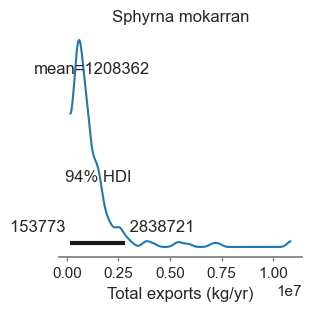

In [179]:
fig, ax = plt.subplots(1, 1,figsize=(3,3))
tmpSpp = tmp_num.columns[0]
az.plot_posterior(spp_exports.sel(species=tmpSpp).sum('exporter')*1000, color='#1f77b4',ax=ax)
plt.title(tmpSpp)
plt.xlabel('Total exports (kg/yr)')
plt.savefig(bf+'/Species/'+tmpSpp.replace(" ", "_")+'total_trade.jpg',dpi=300);

In [180]:
# Reported landings
sdata[sdata.species==tmp_num.columns[0]].groupby('year').sum().Reported_species_landings.mean()*1000

33285.71428571428

In [181]:
tmp_spp = [v for v in list(species_) if v.startswith('Mobula')]
tmp_spp

['Mobula alfredi',
 'Mobula birostris',
 'Mobula eregoodoo',
 'Mobula hypostoma',
 'Mobula japanica',
 'Mobula kuhlii',
 'Mobula mobular',
 'Mobula munkiana',
 'Mobula tarapacana',
 'Mobula thurstoni']

In [182]:
# Sri Lanka estimated trade
(trade_spp
            .sel(species=tmp_spp,exporter='LKA')
            .sum(['importer'])
            .quantile((0.5,0.05,0.95),('chain','draw'))).sum('species').to_dataframe().T

quantile      0.50      0.05       0.95
          0.055136  0.000111  138.15132

In [183]:
# Global estimated trade
(trade_spp
            .sel(species=tmp_spp)
            .sum(['importer','exporter'])
            .quantile((0.5,0.05,0.95),('chain','draw'))).sum('species').to_dataframe().T

quantile         0.50        0.05          0.95
          1061.313828  146.768497  13114.571533

In [184]:
# Reported landings
sdata.iloc[match(tmp_spp,list(sdata.species))[match(tmp_spp,list(sdata.species))!=None]].groupby('year').sum().Reported_species_landings.mean()*1000

102000.00000000003

In [185]:
txdata['Reported_taxon_landings'] = np.exp(txdata.logReported_taxon_landings)

In [186]:
txdata[txdata.taxon=='Sphyrna']

logReported_taxon_landings  taxon_tax_id  country_tax_id  year_tax_id  \
231                    0.693147            25              64            7   

    country    year    taxon  Reported_taxon_landings  
231     VUT  year_8  Sphyrna                      2.0

In [187]:
txdata.taxon.unique()

array(['Pristiophorus', 'Mustelus', 'Potamotrygon', 'Carcharhinus',
       'Alopias', 'Etmopterus', 'Galeus', 'Isurus', 'Scyliorhinus',
       'Bathyraja', 'Squalus', 'Mobula', 'Rhinobatos', 'Sphyrna',
       'Myliobatidae', 'Squatinidae', 'Rajidae', 'Squalidae',
       'Carcharhinidae', 'Sphyrnidae', 'Dasyatidae', 'Scyliorhinidae',
       'Lamnidae', 'Mobulidae', 'Pristidae', 'Rhinobatidae', 'Rajiformes',
       'Selachimorpha', 'Elasmobranchii'], dtype=object)

In [188]:
txdata[txdata.taxon=='Mobulidae'].groupby('year').sum().Reported_taxon_landings.mean()*1000

4538375.0

In [189]:
txdata[(txdata.taxon=='Mobulidae')&(txdata.country=='LKA')].groupby('year').sum().Reported_taxon_landings.mean()*1000

816750.0

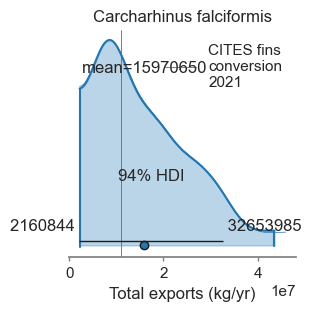

In [190]:
# Grab species
tmp_num = CITES24_all('Carcharhinus falciformis')
# Global estimated trade - excluding domestic
tmp_ex = (trade_spp
            .sel(species=tmp_num.columns[0])
            .sum(['importer','exporter'])
            .quantile((0.5,0.03,0.97),('chain','draw'))).to_dataframe().T
tmp_num['perc_global'] = (tmp_num['Median trade']/np.array(tmp_ex[0.50]))*100

fig, ax = plt.subplots(1, 1,figsize=(3,3))
tmpSpp = tmp_num.columns[0]
xxtmp = trade_spp.sel(species=tmpSpp).sum(('exporter','importer'))*1000
az.plot_density(xxtmp, colors='#1f77b4', ax=ax, shade=0.3, hdi_prob=0.99)
az.plot_posterior(xxtmp, color='#1f77b4',ax=ax, linewidth=.5,)
ax.axvline(x=10985296, color='red', zorder=0, linewidth=.5, label='CITES fins\nconversion\n2021')
plt.legend()
plt.title(tmpSpp)
plt.xlabel('Total exports (kg/yr)')
plt.savefig(bf+'/Species/'+tmpSpp.replace(" ", "_")+'total_trade.jpg',dpi=300);

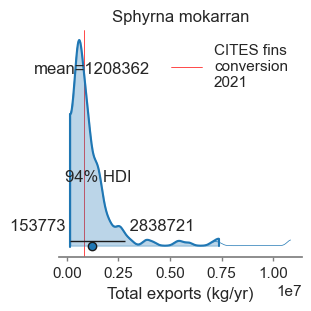

In [191]:
# Grab species
tmp_num = CITES24_all('Sphyrna mokarran')
tmp_finRep = 13727.1
# Global estimated trade - excluding domestic
tmp_ex = (trade_spp
            .sel(species=tmp_num.columns[0])
            .sum(['importer','exporter'])
            .quantile((0.5,0.03,0.97),('chain','draw'))).to_dataframe().T
tmp_num['perc_global'] = (tmp_num['Median trade']/np.array(tmp_ex[0.50]))*100

fig, ax = plt.subplots(1, 1,figsize=(3,3))
tmpSpp = tmp_num.columns[0]
xxtmp = trade_spp.sel(species=tmpSpp).sum(('exporter','importer'))*1000
az.plot_density(xxtmp, colors='#1f77b4', ax=ax, shade=0.3, hdi_prob=0.99)
az.plot_posterior(xxtmp, color='#1f77b4',ax=ax, linewidth=.5,)
ax.axvline(x=tmp_finRep/0.0169, color='red', zorder=0, linewidth=.5, label='CITES fins\nconversion\n2021')
plt.legend()
plt.title(tmpSpp)
plt.xlabel('Total exports (kg/yr)')
plt.savefig(bf+'/Species/'+tmpSpp.replace(" ", "_")+'total_trade.jpg',dpi=300);

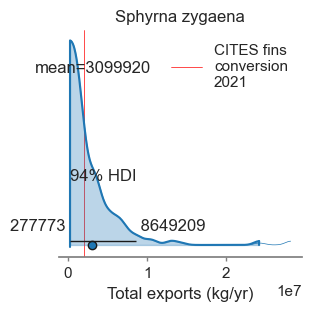

In [192]:
# Grab species
tmp_num = CITES24_all('Sphyrna zygaena')
tmp_finRep = 34335.4
# Global estimated trade - excluding domestic
tmp_ex = (trade_spp
            .sel(species=tmp_num.columns[0])
            .sum(['importer','exporter'])
            .quantile((0.5,0.03,0.97),('chain','draw'))).to_dataframe().T
tmp_num['perc_global'] = (tmp_num['Median trade']/np.array(tmp_ex[0.50]))*100

fig, ax = plt.subplots(1, 1,figsize=(3,3))
tmpSpp = tmp_num.columns[0]
xxtmp = trade_spp.sel(species=tmpSpp).sum(('exporter','importer'))*1000
az.plot_density(xxtmp, colors='#1f77b4', ax=ax, shade=0.3, hdi_prob=0.99)
az.plot_posterior(xxtmp, color='#1f77b4',ax=ax, linewidth=.5,)
ax.axvline(x=tmp_finRep/0.0169, color='red', zorder=0, linewidth=.5, label='CITES fins\nconversion\n2021')
plt.legend()
plt.title(tmpSpp)
plt.xlabel('Total exports (kg/yr)')
plt.savefig(bf+'/Species/'+tmpSpp.replace(" ", "_")+'total_trade.jpg',dpi=300);

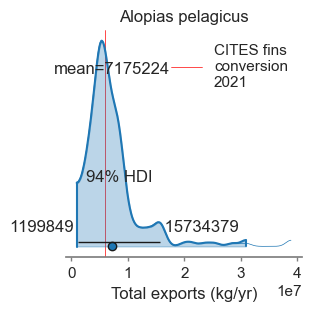

In [193]:
# Grab species
tmp_num = CITES24_all('Alopias pelagicus')
tmp_finRep = 201407.8
# Global estimated trade - excluding domestic
tmp_ex = (trade_spp
            .sel(species=tmp_num.columns[0])
            .sum(['importer','exporter'])
            .quantile((0.5,0.03,0.97),('chain','draw'))).to_dataframe().T
tmp_num['perc_global'] = (tmp_num['Median trade']/np.array(tmp_ex[0.50]))*100

fig, ax = plt.subplots(1, 1,figsize=(3,3))
tmpSpp = tmp_num.columns[0]
xxtmp = trade_spp.sel(species=tmpSpp).sum(('exporter','importer'))*1000
az.plot_density(xxtmp, colors='#1f77b4', ax=ax, shade=0.3, hdi_prob=0.99)
az.plot_posterior(xxtmp, color='#1f77b4',ax=ax, linewidth=.5,)
ax.axvline(x=tmp_finRep/0.0340, color='red', zorder=0, linewidth=.5, label='CITES fins\nconversion\n2021')
plt.legend()
plt.title(tmpSpp)
plt.xlabel('Total exports (kg/yr)')
plt.savefig(bf+'/Species/'+tmpSpp.replace(" ", "_")+'total_trade.jpg',dpi=300);

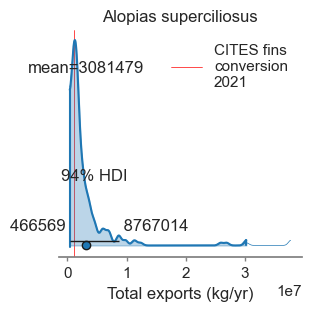

In [194]:
# Grab species
tmp_num = CITES24_all('Alopias superciliosus')
tmp_finRep = 38130.6
# Global estimated trade - excluding domestic
tmp_ex = (trade_spp
            .sel(species=tmp_num.columns[0])
            .sum(['importer','exporter'])
            .quantile((0.5,0.03,0.97),('chain','draw'))).to_dataframe().T
tmp_num['perc_global'] = (tmp_num['Median trade']/np.array(tmp_ex[0.50]))*100

fig, ax = plt.subplots(1, 1,figsize=(3,3))
tmpSpp = tmp_num.columns[0]
xxtmp = trade_spp.sel(species=tmpSpp).sum(('exporter','importer'))*1000
az.plot_density(xxtmp, colors='#1f77b4', ax=ax, shade=0.3, hdi_prob=0.99)
az.plot_posterior(xxtmp, color='#1f77b4',ax=ax, linewidth=.5,)
ax.axvline(x=tmp_finRep/0.0340, color='red', zorder=0, linewidth=.5, label='CITES fins\nconversion\n2021')
plt.legend()
plt.title(tmpSpp)
plt.xlabel('Total exports (kg/yr)')
plt.savefig(bf+'/Species/'+tmpSpp.replace(" ", "_")+'total_trade.jpg',dpi=300);

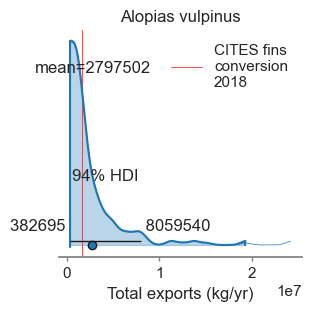

In [195]:
# Grab species
tmp_num = CITES24_all('Alopias vulpinus')
tmp_finRep = 57862.2
# Global estimated trade - excluding domestic
tmp_ex = (trade_spp
            .sel(species=tmp_num.columns[0])
            .sum(['importer','exporter'])
            .quantile((0.5,0.03,0.97),('chain','draw'))).to_dataframe().T
tmp_num['perc_global'] = (tmp_num['Median trade']/np.array(tmp_ex[0.50]))*100

fig, ax = plt.subplots(1, 1,figsize=(3,3))
tmpSpp = tmp_num.columns[0]
xxtmp = trade_spp.sel(species=tmpSpp).sum(('exporter','importer'))*1000
az.plot_density(xxtmp, colors='#1f77b4', ax=ax, shade=0.3, hdi_prob=0.99)
az.plot_posterior(xxtmp, color='#1f77b4',ax=ax, linewidth=.5,)
ax.axvline(x=tmp_finRep/0.0340, color='red', zorder=0, linewidth=.5, label='CITES fins\nconversion\n2018')
plt.legend()
plt.title(tmpSpp)
plt.xlabel('Total exports (kg/yr)')
plt.savefig(bf+'/Species/'+tmpSpp.replace(" ", "_")+'total_trade.jpg',dpi=300);

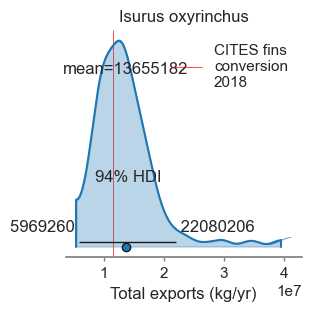

In [196]:
# Grab species
tmp_num = CITES24_all('Isurus oxyrinchus')
tmp_finRep = 194095.4
# Global estimated trade - excluding domestic
tmp_ex = (trade_spp
            .sel(species=tmp_num.columns[0])
            .sum(['importer','exporter'])
            .quantile((0.5,0.03,0.97),('chain','draw'))).to_dataframe().T
tmp_num['perc_global'] = (tmp_num['Median trade']/np.array(tmp_ex[0.50]))*100

fig, ax = plt.subplots(1, 1,figsize=(3,3))
tmpSpp = tmp_num.columns[0]
xxtmp = trade_spp.sel(species=tmpSpp).sum(('exporter','importer'))*1000
az.plot_density(xxtmp, colors='#1f77b4', ax=ax, shade=0.3, hdi_prob=0.99)
az.plot_posterior(xxtmp, color='#1f77b4',ax=ax, linewidth=.5,)
ax.axvline(x=tmp_finRep/0.0169, color='red', zorder=0, linewidth=.5, label='CITES fins\nconversion\n2018')
plt.legend()
plt.title(tmpSpp)
plt.xlabel('Total exports (kg/yr)')
plt.savefig(bf+'/Species/'+tmpSpp.replace(" ", "_")+'total_trade.jpg',dpi=300);

## CITES listed species plot

In [197]:
# Add CITES 2022 and IUCN 2022 to exports object
# Trade object
tmp_trade = idata_trade_a.posterior.amount_exported.mean(('chain','draw'))

# REMOVE DOMESTIC RETENTION
for c in country_a:
    # Remove domestic consumption
    tmp_trade.loc[dict(exporter=c,importer=c)] = 0

# Total biomass in the trade
trade_vol_spp = (tmp_trade.sum(('exporter','importer'))
                 .assign_coords({"IUCN": ("species", IUCN_vu)})
                 .assign_coords({"IUCN_all": ("species", IUCN_all)})
                 .assign_coords({"CITES": ("species", CITES22)})
                 .assign_coords({"Habitat": ("species", hdata.Dulvy_priority.values[match(species_,list(hdata.species_binomial))])})
                 .sel(species=spp_100)
                )

In [198]:
# Grab CITES c2022 listed spp trade
trade_vol_cites = trade_vol_spp.loc[trade_vol_spp.CITES=='Listed']

# Grab IUCN c2022 listed spp trade
trade_vol_iucn = trade_vol_spp.loc[trade_vol_spp.IUCN=='VUENCR']

In [199]:
# Grab weighted reporting rates in trade
rep_prob = trade_vol_cites.species.values
# Proportion of CITES-listed species unreported in trade
tmp_tradevolspp = trade_vol_spp.sel(species=rep_prob)/trade_vol_spp.sum()
tmp_tradRepPspp = 1-idata_landings_a.posterior.PsppIdent.sel(species=rep_prob).mean(('chain','draw','exporter'))

In [200]:
# Unreported CITES-listed species in Landings
(tmp_tradevolspp*tmp_tradRepPspp).sum()

<xarray.DataArray ()>
array(0.19667981)

In [201]:
# Select top 15 of cites traded species
tmp = trade_vol_cites
tmp = tmp.sortby(tmp, ascending=False)
sppx_trad = tmp.species[:16]
sppx_trad = sppx_trad[sppx_trad!='Galeocerdo cuvier']

# Select reported landings
rep_land = idata_landings_a.posterior['CountrySPP_landings'].sel(species=sppx_trad).sum(('exporter')).rename("")

# Select unreported landings
unrep_land = idata_landings_a.posterior['CountrySPP_Taxonlandings'].sel(species=sppx_trad).sum(('exporter')).rename("")

# Proportion unreported
prop_land = unrep_land/(rep_land+unrep_land)

# Select trade
late_trad = trade_spp.sel(species=sppx_trad).sum(('exporter','importer')).rename("")

# Proporiton of unreported trade
un_trad = late_trad*prop_land

In [202]:
tmpspx = late_trad.median(('chain','draw')).to_dataframe().reset_index().species.values
tmpspx

array(['Prionace glauca', 'Carcharhinus falciformis', 'Isurus oxyrinchus',
       'Alopias pelagicus', 'Rhynchobatus australiae', 'Sphyrna zygaena',
       'Alopias superciliosus', 'Alopias vulpinus', 'Sphyrna lewini',
       'Rhizoprionodon acutus', 'Carcharodon carcharias',
       'Carcharhinus longimanus', 'Carcharhinus limbatus',
       'Carcharhinus dussumieri', 'Carcharhinus albimarginatus'],
      dtype=object)

In [203]:
tmpsppkey = {'Prionace glauca':'Blue', 'Carcharhinus falciformis':'Silky', 'Isurus oxyrinchus':'Mako',
       'Alopias pelagicus':'Pelagic thresher', 'Rhynchobatus australiae':'Bottlenose wedgefish', 'Sphyrna zygaena':'Smooth hammerhead',
       'Alopias superciliosus':'Bigeye thresher', 'Alopias vulpinus':'Common thresher', 'Sphyrna lewini':'Scalloped hammerhead',
       'Rhizoprionodon acutus':'Milk', 'Carcharodon carcharias':'White',
       'Carcharhinus longimanus':'Oceanic whitetip', 'Carcharhinus limbatus':'Blacktip',
       'Carcharhinus dussumieri':'Whitecheek', 'Carcharhinus albimarginatus':'Silvertip'}

In [204]:
tmp = late_trad.median(('chain','draw')).to_dataframe().reset_index()
tmp.columns = ['species','group','IUCN','IUCN_all','CITES','habitat','value']
tmp['proportion'] = tmp['value']/sum(tmp['value'])
tmp = tmp.sort_values(by='value',ascending=False)
tmp['common'] = np.array([tmpsppkey[x] for x in tmp.species.values])
tmp

species   group    IUCN IUCN_all   CITES  \
0               Prionace glauca  sharks     Not       NT  Listed   
1      Carcharhinus falciformis  sharks  VUENCR       VU  Listed   
2             Isurus oxyrinchus  sharks  VUENCR       EN  Listed   
3             Alopias pelagicus  sharks  VUENCR       EN  Listed   
5               Sphyrna zygaena  sharks  VUENCR       VU  Listed   
6         Alopias superciliosus  sharks  VUENCR       VU  Listed   
7              Alopias vulpinus  sharks  VUENCR       VU  Listed   
4       Rhynchobatus australiae    rays  VUENCR       CR  Listed   
8                Sphyrna lewini  sharks  VUENCR       CR  Listed   
9         Rhizoprionodon acutus  sharks  VUENCR       VU  Listed   
12        Carcharhinus limbatus  sharks  VUENCR       VU  Listed   
11      Carcharhinus longimanus  sharks  VUENCR       CR  Listed   
10       Carcharodon carcharias  sharks  VUENCR       VU  Listed   
14  Carcharhinus albimarginatus  sharks  VUENCR       VU  Listed   
13      Carcharhinus dussumieri  sharks  VUENCR       EN  Listed   

                    habitat          value  proportion                common  
0         Epipelagic sharks  110122.496444    0.703897                  Blue  
1         Epipelagic sharks   13782.463095    0.088097                 Silky  
2         Epipelagic sharks   12798.567498    0.081808                  Mako  
3         Epipelagic sharks    6046.251902    0.038647      Pelagic thresher  
5         Hammerhead sharks    1878.902120    0.012010     Smooth hammerhead  
6         Epipelagic sharks    1700.543677    0.010870       Bigeye thresher  
7         Epipelagic sharks    1669.161186    0.010669       Common thresher  
4                     Other    1581.832709    0.010111  Bottlenose wedgefish  
8         Hammerhead sharks    1477.643693    0.009445  Scalloped hammerhead  
9   Tropical requiem sharks    1329.494359    0.008498                  Milk  
12  Tropical requiem sharks    1157.390655    0.007398              Blacktip  
11        Epipelagic sharks    1092.557054    0.006984      Oceanic whitetip  
10        Epipelagic sharks     749.160148    0.004789                 White  
14  Tropical requiem sharks     564.751704    0.003610             Silvertip  
13  Tropical requiem sharks     495.565178    0.003168            Whitecheek

In [205]:
# Percentage of total trade covered by CITES-listed species
perc_cites = ((trade_vol_cites.sum()/trade_vol_spp.sum()).values.round(2)*100).astype(str)

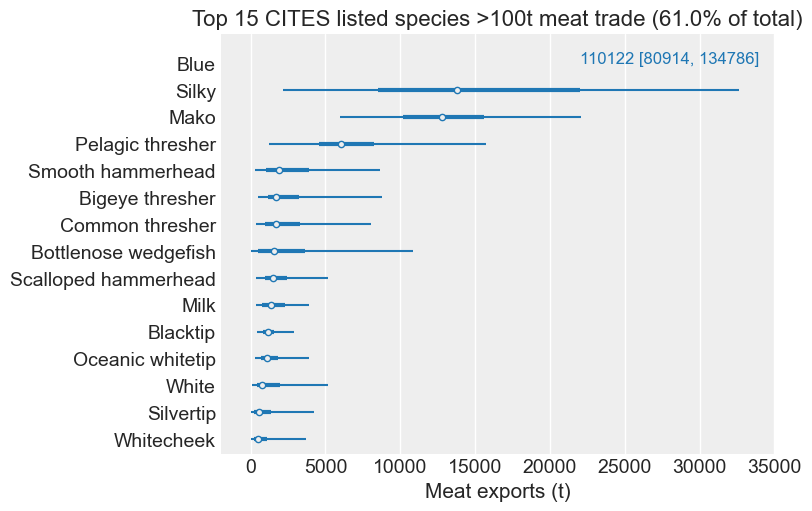

In [206]:
# = = = = = Set up plot
az.style.use("arviz-darkgrid")
_, ax = plt.subplots(1,1,figsize=(8, 5))

# Exporters
az.plot_forest(
    late_trad.sel(species=tmp.species.values),
    figsize=(5, 12),
    combined=True,
    colors='#1f77b4',
    ax=ax
)
tmptxt = late_trad.sel(species='Prionace glauca').quantile((0.5,0.05,0.95)).values.astype(int).astype(str)
plt.text(22000,ax.get_yticks()[-1],tmptxt[0]+' ['+tmptxt[1]+', '+tmptxt[2]+']',color='#1f77b4',)

tmp_lab = tmp.common.values[::-1]
ax.set_xlim(-2000, 35000)
#ax.set_xscale('log')
ax.set_yticklabels(tmp_lab)
ax.set_title("Top 15 CITES listed species >100t meat trade ("+perc_cites+"% of total)")
#ax.legend(loc="lower right")

ax.set_xlabel('Meat exports (t)')
plt.savefig(bf+'/Global/'+'Top_traded_cites_species.jpg',dpi=300);

In [207]:
# Select top 15 of iucn vu+ traded species that are not already cites listed
tmp = trade_vol_iucn.sel(species=np.array(list(set(trade_vol_iucn.species.values) - set(trade_vol_cites.species.values))))
tmp = tmp.sortby(tmp, ascending=False)
sppx_trad2 = tmp.species[:15]

# Select reported landings
rep_land = idata_landings_a.posterior['CountrySPP_landings'].sel(species=sppx_trad2).sum(('exporter')).rename("")

# Select unreported landings
unrep_land = idata_landings_a.posterior['CountrySPP_Taxonlandings'].sel(species=sppx_trad2).sum(('exporter')).rename("")

# Proportion unreported
prop_land = unrep_land/(rep_land+unrep_land)

# Select trade
late_trad = trade_spp.sel(species=sppx_trad2).sum(('exporter','importer')).rename("")

# Proporiton of unreported trade
un_trad = late_trad*prop_land

In [208]:
tmpspx = late_trad.median(('chain','draw')).to_dataframe().reset_index().species.values
tmpspx

array(['Squalus acanthias', 'Leucoraja ocellata', 'Galeorhinus galeus',
       'Bathytoshia lata', 'Dasyatis pastinaca', 'Himantura undulata',
       'Mustelus mustelus', 'Himantura uarnak', 'Himantura leoparda',
       'Aetomylaeus maculatus', 'Dalatias licha', 'Raja undulata',
       'Scyliorhinus stellaris', 'Mustelus schmitti',
       'Mustelus punctulatus'], dtype=object)

In [209]:
tmpsppkey2 = {'Squalus acanthias':'Spiny dogfish', 'Leucoraja ocellata':'Winter skate', 'Galeorhinus galeus':'Tope',
       'Bathytoshia lata':'Broad stingray', 'Dasyatis pastinaca':'Common stingray', 'Himantura undulata':'Honeycomb whipray',
       'Mustelus mustelus':'Common smoothhound', 'Himantura uarnak':'Coach whipray', 'Himantura leoparda':'Lepord whipray',
       'Aetomylaeus maculatus':'Mottled eagle ray', 'Dalatias licha':'Kitefin', 'Raja undulata':'Undulate ray',
       'Scyliorhinus stellaris':'Nursehound', 'Mustelus schmitti':'Narrownose smoothhound',
       'Mustelus punctulatus':'Blackspotted smoothhound'}

In [210]:
tmp = late_trad.median(('chain','draw')).to_dataframe().reset_index()
tmp.columns = ['species','group','IUCN','IUCN_all','CITES','habitat','value']
tmp['proportion'] = tmp['value']/sum(tmp['value'])
tmp = tmp.sort_values(by='value',ascending=False)
tmp['common'] = np.array([tmpsppkey2[x] for x in tmp.species.values])
tmp

species   group    IUCN IUCN_all       CITES  \
0        Squalus acanthias  sharks  VUENCR       VU  Not listed   
1       Leucoraja ocellata    rays  VUENCR       EN  Not listed   
2       Galeorhinus galeus  sharks  VUENCR       CR  Not listed   
6        Mustelus mustelus  sharks  VUENCR       EN  Not listed   
5       Himantura undulata    rays  VUENCR       EN  Not listed   
10          Dalatias licha  sharks  VUENCR       VU  Not listed   
7         Himantura uarnak    rays  VUENCR       EN  Not listed   
12  Scyliorhinus stellaris  sharks  VUENCR       VU  Not listed   
8       Himantura leoparda    rays  VUENCR       VU  Not listed   
13       Mustelus schmitti  sharks  VUENCR       CR  Not listed   
4       Dasyatis pastinaca    rays  VUENCR       VU  Not listed   
11           Raja undulata    rays  VUENCR       EN  Not listed   
3         Bathytoshia lata    rays  VUENCR       VU  Not listed   
9    Aetomylaeus maculatus    rays  VUENCR       EN  Not listed   
14    Mustelus punctulatus  sharks  VUENCR       VU  Not listed   

                        habitat         value  proportion  \
0   Smoothhounds, dogfish, tope  16251.736479    0.416978   
1                        Skates   9195.173746    0.235925   
2   Smoothhounds, dogfish, tope   3680.916300    0.094443   
6   Smoothhounds, dogfish, tope   1514.015936    0.038846   
5                 Tropical rays   1280.397083    0.032852   
10             Deepwater sharks   1277.492717    0.032777   
7                 Tropical rays   1269.986628    0.032585   
12  Smoothhounds, dogfish, tope   1087.231227    0.027896   
8                 Tropical rays    985.766819    0.025292   
13  Smoothhounds, dogfish, tope    706.923459    0.018138   
4                 Tropical rays    595.152095    0.015270   
11                       Skates    398.009348    0.010212   
3                 Tropical rays    374.289768    0.009603   
9                 Tropical rays    214.926989    0.005514   
14  Smoothhounds, dogfish, tope    142.990609    0.003669   

                      common  
0              Spiny dogfish  
1               Winter skate  
2                       Tope  
6         Common smoothhound  
5          Honeycomb whipray  
10                   Kitefin  
7              Coach whipray  
12                Nursehound  
8             Lepord whipray  
13    Narrownose smoothhound  
4            Common stingray  
11              Undulate ray  
3             Broad stingray  
9          Mottled eagle ray  
14  Blackspotted smoothhound

In [211]:
# Trade volume not covered by CITES but with VU+
perc_iucn = ((trade_vol_iucn.sel(species=np.array(list(set(trade_vol_iucn.species.values) - set(trade_vol_cites.species.values))))
             .sum()/trade_vol_spp.sum()).values.round(2)*100).astype(str)

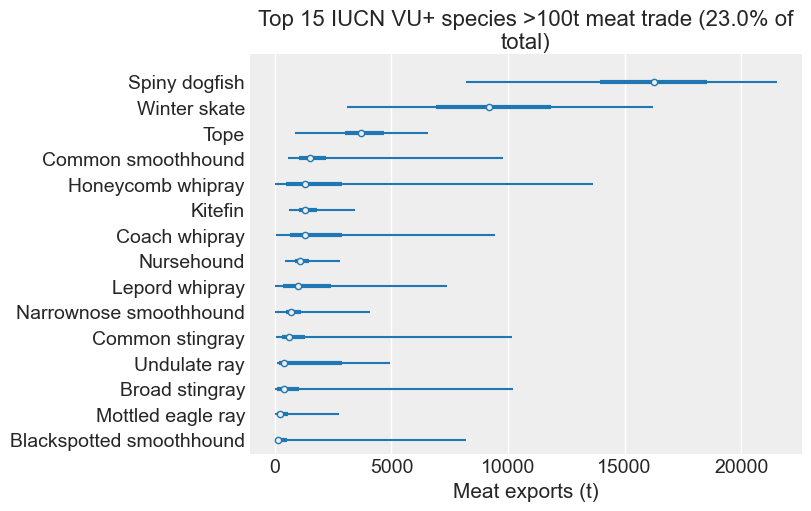

In [212]:
# = = = = = Set up plot
az.style.use("arviz-darkgrid")
_, ax = plt.subplots(1,1,figsize=(8, 5))


# Exporters
az.plot_forest(
    late_trad.sel(species=tmp.species.values),
    #model_names=["Total", "Unreported"],
    figsize=(5, 12),
    colors='#1f77b4',
    combined=True,
    ax=ax
)
tmp_lab = tmp.common.values[::-1]
#ax.set_xlim(-2000, 25000)
#ax.set_xscale('log')
ax.set_yticklabels(tmp_lab)
ax.set_title("Top 15 IUCN VU+ species >100t meat trade ("+perc_iucn+"% of total)")
#ax.legend(loc="lower right")

ax.set_xlabel('Meat exports (t)')
plt.savefig(bf+'/Global/'+'Top_traded_iucn_species.jpg',dpi=300);

In [213]:
for spp in list(sppx_trad.values)+list(sppx_trad2.values)+['Galeorhinus galeus','']:
    # Grab species
    tmp_num = CITES24_all(spp)
    tmpSpp = tmp_num.columns[0]
    # Global estimated trade - excluding domestic
    tmp_ex = (trade_spp
                .sel(species=tmp_num.columns[0])
                .sum(['importer','exporter'])
                .quantile((0.5,0.03,0.97),('chain','draw'))).to_dataframe().T
    tmp_num['perc_global'] = (tmp_num['Median trade']/np.array(tmp_ex[0.50]))*100
    
    # Set up plot
    fig, ax = plt.subplots(1, 2,figsize=(8,4))
    
    # Plot total trade per year
    xxtmp = trade_spp.sel(species=tmpSpp).sum(('exporter','importer'))
    az.plot_density(xxtmp, colors='#1f77b4', ax=ax[0], shade=0.3, hdi_prob=0.99)
    az.plot_posterior(xxtmp, color='#1f77b4',ax=ax[0], linewidth=.5,)
    ax[0].set_title(tmpSpp)
    ax[0].set_xlabel('Total meat exports (t/yr)')

    # Exporters
    tmp = trade_spp.sel(species=tmpSpp).sum(('importer')).median(('chain','draw')).to_dataframe().reset_index()
    tmp.columns = ['exporter','species','Exporter','group','value']
    tmp = tmp.sort_values(by='value',ascending=False)
    tmp_exlist = tmp[tmp.value>10][:15].exporter.values
    tmpEx_x = trade_spp.sel(species=tmpSpp, exporter=tmp_exlist).sum('importer')
    az.plot_forest(
        tmpEx_x,
        #model_names=["Total", "Unreported"],
        colors='#1f77b4',
        figsize=(5, 5),
        combined=True,
        ax=ax[1]
    )
    #ax.set_xlim(-2000, 25000)
    #ax.set_xscale('log')
    tmp_lab = tmpEx_x.Exporter.values[::-1]
    #tmp_lab[tmp_lab=="Other Asia, nes"] = 'Taiwan'
    #tmp_lab[tmp_lab=="Rep. of Korea"] = 'South Korea'
    ax[1].set_yticklabels(tmp_lab)
    ax[1].set_xlabel('Total meat exports (t/yr)')
    
    plt.savefig(bf+'/Species/'+tmpSpp.replace(" ", "_")+'total_trade_x.jpg',dpi=300)
    plt.close();

KeyError: "not all values found in index 'species'. Try setting the `method` keyword argument (example: method='nearest')."

## Threshers

In [ ]:
species_[np.array(['Alopias' in s for s in species_])]

In [ ]:
# Grab species
tmpSpp = species_[np.array(['Alopias' in s for s in species_])]
# Global estimated trade - excluding domestic
tmp_ex = (trade_spp
            .sel(species=tmp_num.columns[0])
            .sum(['importer','exporter'])
            .quantile((0.5,0.03,0.97),('chain','draw'))).to_dataframe().T
tmp_num['perc_global'] = (tmp_num['Median trade']/np.array(tmp_ex[0.50]))*100

# Set up plot
fig, ax = plt.subplots(1, 2,figsize=(8,4))

# Plot total trade per year
xxtmp = trade_spp.sel(species=tmpSpp).sum(('exporter','importer','species'))
az.plot_density(xxtmp, colors='#1f77b4', ax=ax[0], shade=0.3, hdi_prob=0.99)
az.plot_posterior(xxtmp, color='#1f77b4',ax=ax[0], linewidth=.5,)
ax[0].set_title('Alopias Spp.')
ax[0].set_xlabel('Total meat exports (t/yr)')

# Exporters
tmp = trade_spp.sel(species=tmpSpp).sum(('importer','species')).median(('chain','draw')).to_dataframe().reset_index()
tmp.columns = ['exporter','Exporter','value']
tmp = tmp.sort_values(by='value',ascending=False)
tmp_exlist = tmp[tmp.value>10][:15].exporter.values
tmpEx_x = trade_spp.sel(species=tmpSpp, exporter=tmp_exlist).sum(('importer','species'))
az.plot_forest(
    tmpEx_x,
    #model_names=["Total", "Unreported"],
    colors='#1f77b4',
    figsize=(5, 5),
    combined=True,
    ax=ax[1]
)
#ax.set_xlim(-2000, 25000)
#ax.set_xscale('log')
tmp_lab = tmpEx_x.Exporter.values[::-1]
#tmp_lab[tmp_lab=="Other Asia, nes"] = 'Taiwan'
#tmp_lab[tmp_lab=="Rep. of Korea"] = 'South Korea'
ax[1].set_yticklabels(tmp_lab)
ax[1].set_xlabel('Total meat exports (t/yr)')

plt.savefig(bf+'/Species/'+'AlopiasSpp_'+'total_trade_x.jpg',dpi=300)
plt.close();

# Whiprays

In [ ]:
# Grab species
tmpSpp = species_[np.array(['Himantura' in s for s in species_])]
# Global estimated trade - excluding domestic
tmp_ex = (trade_spp
            .sel(species=tmp_num.columns[0])
            .sum(['importer','exporter'])
            .quantile((0.5,0.03,0.97),('chain','draw'))).to_dataframe().T
tmp_num['perc_global'] = (tmp_num['Median trade']/np.array(tmp_ex[0.50]))*100

# Set up plot
fig, ax = plt.subplots(1, 2,figsize=(8,4))

# Plot total trade per year
xxtmp = trade_spp.sel(species=tmpSpp).sum(('exporter','importer','species'))
az.plot_density(xxtmp, colors='#1f77b4', ax=ax[0], shade=0.3, hdi_prob=0.99)
az.plot_posterior(xxtmp, color='#1f77b4',ax=ax[0], linewidth=.5,)
ax[0].set_title('Himantura Spp.')
ax[0].set_xlabel('Total meat exports (t/yr)')

# Exporters
tmp = trade_spp.sel(species=tmpSpp).sum(('importer','species')).median(('chain','draw')).to_dataframe().reset_index()
tmp.columns = ['exporter','Exporter','value']
tmp = tmp.sort_values(by='value',ascending=False)
tmp_exlist = tmp[tmp.value>10][:15].exporter.values
tmpEx_x = trade_spp.sel(species=tmpSpp, exporter=tmp_exlist).sum(('importer','species'))
az.plot_forest(
    tmpEx_x,
    #model_names=["Total", "Unreported"],
    colors='#1f77b4',
    figsize=(5, 5),
    combined=True,
    ax=ax[1]
)
#ax.set_xlim(-2000, 25000)
#ax.set_xscale('log')
tmp_lab = tmpEx_x.Exporter.values[::-1]
#tmp_lab[tmp_lab=="Other Asia, nes"] = 'Taiwan'
#tmp_lab[tmp_lab=="Rep. of Korea"] = 'South Korea'
ax[1].set_yticklabels(tmp_lab)
ax[1].set_xlabel('Total meat exports (t/yr)')

plt.savefig(bf+'/Species/'+'HimanturaSpp_'+'total_trade_x.jpg',dpi=300)
plt.close();

## Smoothhounds

In [ ]:
# Grab species
tmpSpp = ['Mustelus mustelus','Scyliorhinus stellaris','Mustelus schmitti','Mustelus punctulatus']
# Global estimated trade - excluding domestic
tmp_ex = (trade_spp
            .sel(species=tmp_num.columns[0])
            .sum(['importer','exporter'])
            .quantile((0.5,0.03,0.97),('chain','draw'))).to_dataframe().T
tmp_num['perc_global'] = (tmp_num['Median trade']/np.array(tmp_ex[0.50]))*100

# Set up plot
fig, ax = plt.subplots(1, 2,figsize=(8,4))

# Plot total trade per year
xxtmp = trade_spp.sel(species=tmpSpp).sum(('exporter','importer','species'))
az.plot_density(xxtmp, colors='#1f77b4', ax=ax[0], shade=0.3, hdi_prob=0.99)
az.plot_posterior(xxtmp, color='#1f77b4',ax=ax[0], linewidth=.5, hdi_prob=0.99)
ax[0].set_title('Mustelus/Scyliorhinus Spp.')
ax[0].set_xlabel('Total meat exports (t/yr)')

# Exporters
tmp = trade_spp.sel(species=tmpSpp).sum(('importer','species')).median(('chain','draw')).to_dataframe().reset_index()
tmp.columns = ['exporter','Exporter','value']
tmp = tmp.sort_values(by='value',ascending=False)
tmp_exlist = tmp[tmp.value>10][:15].exporter.values
tmpEx_x = trade_spp.sel(species=tmpSpp, exporter=tmp_exlist).sum(('importer','species'))
az.plot_forest(
    tmpEx_x,
    #model_names=["Total", "Unreported"],
    colors='#1f77b4',
    figsize=(5, 5),
    combined=True,
    ax=ax[1]
)
ax[1].set_xlim(-200, 2500)
#ax.set_xscale('log')
tmp_lab = tmpEx_x.Exporter.values[::-1]
#tmp_lab[tmp_lab=="Other Asia, nes"] = 'Taiwan'
#tmp_lab[tmp_lab=="Rep. of Korea"] = 'South Korea'
ax[1].set_yticklabels(tmp_lab)
ax[1].set_xlabel('Total meat exports (t/yr)')

plt.savefig(bf+'/Species/'+'MustelusSpp_'+'total_trade_x.jpg',dpi=300)
plt.close();

# Hammerheads

In [ ]:
# Grab species
tmpSpp = species_[np.array(['Sphyrna' in s for s in species_])]
# Global estimated trade - excluding domestic
tmp_ex = (trade_spp
            .sel(species=tmp_num.columns[0])
            .sum(['importer','exporter'])
            .quantile((0.5,0.03,0.97),('chain','draw'))).to_dataframe().T
tmp_num['perc_global'] = (tmp_num['Median trade']/np.array(tmp_ex[0.50]))*100

# Set up plot
fig, ax = plt.subplots(1, 2,figsize=(8,4))

# Plot total trade per year
xxtmp = trade_spp.sel(species=tmpSpp).sum(('exporter','importer','species'))
az.plot_density(xxtmp, colors='#1f77b4', ax=ax[0], shade=0.3, hdi_prob=0.99)
az.plot_posterior(xxtmp, color='#1f77b4',ax=ax[0], linewidth=.5,)
ax[0].set_title('Sphyrna Spp.')
ax[0].set_xlabel('Total meat exports (t/yr)')

# Exporters
tmp = trade_spp.sel(species=tmpSpp).sum(('importer','species')).median(('chain','draw')).to_dataframe().reset_index()
tmp.columns = ['exporter','Exporter','value']
tmp = tmp.sort_values(by='value',ascending=False)
tmp_exlist = tmp[tmp.value>10][:15].exporter.values
tmpEx_x = trade_spp.sel(species=tmpSpp, exporter=tmp_exlist).sum(('importer','species'))
az.plot_forest(
    tmpEx_x,
    #model_names=["Total", "Unreported"],
    colors='#1f77b4',
    figsize=(5, 5),
    combined=True,
    ax=ax[1]
)
#ax.set_xlim(-2000, 25000)
#ax.set_xscale('log')
tmp_lab = tmpEx_x.Exporter.values[::-1]
#tmp_lab[tmp_lab=="Other Asia, nes"] = 'Taiwan'
#tmp_lab[tmp_lab=="Rep. of Korea"] = 'South Korea'
ax[1].set_yticklabels(tmp_lab)
ax[1].set_xlabel('Total meat exports (t/yr)')

plt.savefig(bf+'/Species/'+'SphyrnaSpp_'+'total_trade_x.jpg',dpi=300)
plt.close();

# Gulpers

In [ ]:
# Grab species 
tmpSpp = species_[np.array(['Centrophorus' in s for s in species_])+np.array(['Deania' in s for s in species_])]
# Global estimated trade - excluding domestic
tmp_ex = (trade_spp
            .sel(species=tmp_num.columns[0])
            .sum(['importer','exporter'])
            .quantile((0.5,0.03,0.97),('chain','draw'))).to_dataframe().T
tmp_num['perc_global'] = (tmp_num['Median trade']/np.array(tmp_ex[0.50]))*100

# Set up plot
fig, ax = plt.subplots(1, 2,figsize=(8,4))

# Plot total trade per year
xxtmp = trade_spp.sel(species=tmpSpp).sum(('exporter','importer','species'))
az.plot_density(xxtmp, colors='#1f77b4', ax=ax[0], shade=0.3, hdi_prob=0.99)
az.plot_posterior(xxtmp, color='#1f77b4',ax=ax[0], linewidth=.5,)
ax[0].set_title('Centrophoridae Spp.')
ax[0].set_xlabel('Total meat exports (t/yr)')

# Exporters
tmp = trade_spp.sel(species=tmpSpp).sum(('importer','species')).median(('chain','draw')).to_dataframe().reset_index()
tmp.columns = ['exporter','Exporter','value']
tmp = tmp.sort_values(by='value',ascending=False)
tmp_exlist = tmp[tmp.value>10][:15].exporter.values
tmpEx_x = trade_spp.sel(species=tmpSpp, exporter=tmp_exlist).sum(('importer','species'))
az.plot_forest(
    tmpEx_x,
    #model_names=["Total", "Unreported"],
    colors='#1f77b4',
    figsize=(5, 5),
    combined=True,
    ax=ax[1]
)
#ax.set_xlim(-2000, 25000)
#ax.set_xscale('log')
tmp_lab = tmpEx_x.Exporter.values[::-1]
#tmp_lab[tmp_lab=="Other Asia, nes"] = 'Taiwan'
#tmp_lab[tmp_lab=="Rep. of Korea"] = 'South Korea'
ax[1].set_yticklabels(tmp_lab)
ax[1].set_xlabel('Total meat exports (t/yr)')

plt.savefig(bf+'/Species/'+'CentrophorusSpp_'+'total_trade_x.jpg',dpi=300)
plt.close();

IUCN Questions

In [ ]:
for spp in ['Apristurus brunneus', 'Apristurus kampae', 'Apristurus spongiceps', 
            'Heterodontus francisci', 'Aetomylaeus caeruleofasciatus', 'Hemitrygon fluviorum',
           'Gymnura australis', 'Narcinops nelsoni','Sphyrna lewini','Sphyrna mokarran','Carcharhinus longimanus']:
    # Grab species
    tmp_num = CITES24_all(spp)
    tmpSpp = tmp_num.columns[0]
    # Global estimated trade - excluding domestic
    tmp_ex = (trade_spp
                .sel(species=tmp_num.columns[0])
                .sum(['importer','exporter'])
                .quantile((0.5,0.03,0.97),('chain','draw'))).to_dataframe().T
    tmp_num['perc_global'] = (tmp_num['Median trade']/np.array(tmp_ex[0.50]))*100
    
    # Set up plot
    fig, ax = plt.subplots(1, 2,figsize=(8,4))
    
    # Plot total trade per year
    xxtmp = trade_spp.sel(species=tmpSpp).sum(('exporter','importer'))
    az.plot_density(xxtmp, colors='#1f77b4', ax=ax[0], shade=0.3, hdi_prob=0.99)
    az.plot_posterior(xxtmp, color='#1f77b4',ax=ax[0], linewidth=.5,)
    ax[0].set_title(tmpSpp)
    ax[0].set_xlabel('Total meat exports (t/yr)')

    # Exporters
    tmp = trade_spp.sel(species=tmpSpp).sum(('importer')).median(('chain','draw')).to_dataframe().reset_index()
    tmp.columns = ['exporter','species','Exporter','group','value']
    tmp = tmp.sort_values(by='value',ascending=False)
    tmp_exlist = tmp[tmp.value>1][:15].exporter.values
    tmpEx_x = trade_spp.sel(species=tmpSpp, exporter=tmp_exlist).sum('importer')
    try:
        az.plot_forest(
            tmpEx_x,
            #model_names=["Total", "Unreported"],
            colors='#1f77b4',
            figsize=(5, 5),
            combined=True,
            ax=ax[1]
        )
    except:
        ax[1].scatter(
            0,0,
        )
    #ax.set_xlim(-2000, 25000)
    #ax.set_xscale('log')
    tmp_lab = tmpEx_x.Exporter.values[::-1]
    #tmp_lab[tmp_lab=="Other Asia, nes"] = 'Taiwan'
    #tmp_lab[tmp_lab=="Rep. of Korea"] = 'South Korea'
    ax[1].set_yticklabels(tmp_lab)
    ax[1].set_xlabel('Total meat exports (t/yr)')
    
    plt.savefig(bf+'/Species/'+tmpSpp.replace(" ", "_")+'total_trade_x.jpg',dpi=300)
    plt.close();

In [ ]:
country_

In [ ]:
taxon_shortlist

# Rajidae in Europe

In [ ]:
EUnations = ['BEL', 'DEU', 'DNK',
       'ESP', 'FRA', 'GBR', 'GRC', 'IRL',
        'ITA', 'NLD', 'NOR',
       'POL', 'PRT', 'SWE']

In [ ]:
rajaEUspecies = ['Raja asterias', 'Raja brachyura', 'Raja clavata',
       'Raja microocellata', 'Raja miraletus', 'Raja montagui',
       'Raja parva', 'Raja polystigma', 'Raja radula', 'Raja straeleni',
       'Raja undulata']

In [ ]:
rajaEUspecies2 = ['Raja asterias', 'Raja brachyura', 'Raja clavata','Raja undulata']

In [ ]:
RajAGG = idata_landings_x.posterior['CountryTaxon_SPP_landings'].sel(exporter=EUnations).sum(('exporter')).sel(taxon=['Rajidae', 'Rajiformes'],species=rajaEUspecies).sum(('species','taxon')).rename('')

In [ ]:
az.plot_density(RajAGG);

In [ ]:
RajSPP = idata_landings_x.posterior.CountrySPP_landings.sel(exporter=EUnations).sum(('exporter')).sel(species=rajaEUspecies).sum(('species')).rename('')

In [ ]:
az.plot_density(RajSPP);

In [ ]:
az.plot_density(RajAGG/(RajSPP+RajAGG));

In [ ]:
(RajAGG/(RajSPP+RajAGG)).mean()

In [ ]:
az.plot_density(idata_landings_a.posterior.Latent_landings.sel(exporter='MEX',species='Sphyrna lewini'))

In [ ]:
az.plot_density(trade_spp.sel(exporter='MEX',species='Sphyrna lewini').sum('importer'))

In [ ]:
species_[np.array(['Sphyrna' in s for s in species_])]

In [ ]:
SppPRIORadj.shape

In [ ]:
tmp = species_[SppPRIORadj[list(country_a).index('CHN'),]>2]
tmp

In [ ]:
SppPRIORadj[list(country_a).index('CHN'),np.array([list(species_).index(x) for x in tmp])]

## Fin trade validation

In [ ]:
country_a

In [ ]:
# Grab Hong Kong Imports
HK_Imports = (trade_spp.sel(importer='HKG')
              .sum(('exporter'))
              .median(('chain','draw'))
              .to_dataframe().reset_index()
              .sort_values(by='',ascending=False)
             )
HK_Imports.columns = ['species','importer','Importer','Group','volume']

In [ ]:
# Grab Hong Kong top spp imports
HK_Imports['Prop'] = np.round(HK_Imports.volume/sum(HK_Imports.volume),2)

In [ ]:
HK_Imports